# Code to validate MC simulation validity

### Imports

In [1]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import itertools

directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
#directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

### Functions and Maps

In [2]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label, histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None

def deltaR_filter(muons, jets, cut, muon_muon=False):
    if muon_muon:
        deltars = muons[:,0].deltaR(muons[:,1])
        valid_events = deltars > cut
    else:
        pairs_2d = ak.cartesian({'jets':jets,'muons':muons})
        pairs_3d = ak.unflatten(pairs_2d, 2, axis=1)
        deltars = pairs_3d['muons'].deltaR(pairs_3d['jets'])
        filtered_deltars = deltars[(deltars>cut)]
        validity_check = ak.num(filtered_deltars, axis=2) == 2
        valid_events = ak.num(filtered_deltars[validity_check]) == ak.num(filtered_deltars)

    valid_muons, valid_jets = muons[valid_events], jets[valid_events]

    return valid_muons, valid_jets

mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

### Data Extraction

In [3]:
tree3_1 = uproot.open(directory + "ttt_304014_mc20a_fullsim.root")
tree4_1 = uproot.open(directory + "tttt_412043_mc20a_fastsim.root")

events_4t_1 = tree4_1["reco;1"].arrays(['jet_e_NOSYS','jet_eta','jet_partonid','jet_phi','jet_pt_NOSYS', 'jet_truthHiggsIndex', 'jet_truthTopIndex', 'jet_truthflav', 'jets_deltaR_NOSYS', 'lepton_0_charge_NOSYS', 'lepton_0_pt_GeV_NOSYS', 'lepton_0plus1_pt_GeV_NOSYS', 'lepton_1_charge_NOSYS', 'lepton_1_pt_GeV_NOSYS', 'lepton_2_charge_NOSYS', 'lepton_2_pt_GeV_NOSYS', 'lepton_3_charge_NOSYS', 'lepton_3_pt_GeV_NOSYS', 'lepton_Id', 'lepton_charge', 'lepton_e_NOSYS', 'lepton_eta', 'lepton_phi', 'lepton_pt_NOSYS', 'lepton_truthCat'])
events_3t_1 = tree3_1["reco;1"].arrays(['jet_e_NOSYS','jet_eta','jet_partonid','jet_phi','jet_pt_NOSYS', 'jet_truthHiggsIndex', 'jet_truthTopIndex', 'jet_truthflav', 'jets_deltaR_NOSYS', 'lepton_0_charge_NOSYS', 'lepton_0_pt_GeV_NOSYS', 'lepton_0plus1_pt_GeV_NOSYS', 'lepton_1_charge_NOSYS', 'lepton_1_pt_GeV_NOSYS', 'lepton_2_charge_NOSYS', 'lepton_2_pt_GeV_NOSYS', 'lepton_3_charge_NOSYS', 'lepton_3_pt_GeV_NOSYS', 'lepton_Id', 'lepton_charge', 'lepton_e_NOSYS', 'lepton_eta', 'lepton_phi', 'lepton_pt_NOSYS', 'lepton_truthCat'])

jets_pt_4t_1 = events_4t_1['jet_pt_NOSYS'][events_4t_1['jet_pt_NOSYS']>27000]/1000
jets_eta_4t_1 = events_4t_1['jet_eta'][events_4t_1['jet_pt_NOSYS']>27000]
jets_phi_4t_1 = events_4t_1['jet_phi'][events_4t_1['jet_pt_NOSYS']>27000]
jets_e_4t_1 = events_4t_1['jet_e_NOSYS'][events_4t_1['jet_pt_NOSYS']>27000]/1000
jets_mass_4t_1 = np.sqrt((jets_e_4t_1**2)-(jets_pt_4t_1**2)*(np.cosh(jets_eta_4t_1)**2))

jets_pt_3t_1 = events_3t_1['jet_pt_NOSYS'][events_3t_1['jet_pt_NOSYS']>27000]/1000
jets_eta_3t_1 = events_3t_1['jet_eta'][events_3t_1['jet_pt_NOSYS']>27000]
jets_phi_3t_1 = events_3t_1['jet_phi'][events_3t_1['jet_pt_NOSYS']>27000]
jets_e_3t_1 = events_3t_1['jet_e_NOSYS'][events_3t_1['jet_pt_NOSYS']>27000]/1000
jets_mass_3t_1 = np.sqrt((jets_e_3t_1**2)-(jets_pt_3t_1**2)*(np.cosh(jets_eta_3t_1)**2))

jets_4t_1 = vector.zip({'pt':jets_pt_4t_1,'eta':jets_eta_4t_1,'phi':jets_phi_4t_1,'mass':jets_mass_4t_1})
jets_3t_1 = vector.zip({'pt':jets_pt_3t_1,'eta':jets_eta_3t_1,'phi':jets_phi_3t_1,'mass':jets_mass_3t_1})

leptons_pt_4t_1 = events_4t_1['lepton_pt_NOSYS'][events_4t_1['lepton_Id'] == 13]/1000
leptons_eta_4t_1 = events_4t_1['lepton_eta'][events_4t_1['lepton_Id'] == 13]
leptons_phi_4t_1 = events_4t_1['lepton_phi'][events_4t_1['lepton_Id'] == 13]
leptons_e_4t_1 = events_4t_1['lepton_e_NOSYS'][events_4t_1['lepton_Id'] == 13]/1000
leptons_mass_4t_1 = np.ones_like(leptons_pt_4t_1) * 0.1056
leptons_charge_4t_1 = events_4t_1['lepton_charge'][events_4t_1['lepton_Id'] == 13]

leptons_pt_3t_1 = events_3t_1['lepton_pt_NOSYS'][events_3t_1['lepton_Id'] == 13]/1000
leptons_eta_3t_1 = events_3t_1['lepton_eta'][events_3t_1['lepton_Id'] == 13]
leptons_phi_3t_1 = events_3t_1['lepton_phi'][events_3t_1['lepton_Id'] == 13]
leptons_e_3t_1 = events_3t_1['lepton_e_NOSYS'][events_3t_1['lepton_Id'] == 13]/1000
leptons_mass_3t_1 = np.ones_like(leptons_pt_3t_1) * 0.1056
leptons_charge_3t_1 = events_3t_1['lepton_charge'][events_3t_1['lepton_Id'] == 13]

leptons_4t_1 = vector.zip({'pt':leptons_pt_4t_1,'eta':leptons_eta_4t_1,'phi':leptons_phi_4t_1,'mass':leptons_mass_4t_1})
leptons_3t_1 = vector.zip({'pt':leptons_pt_3t_1,'eta':leptons_eta_3t_1,'phi':leptons_phi_3t_1,'mass':leptons_mass_3t_1})

leptons_4t_1, jets_4t_1 = deltaR_filter(leptons_4t_1, jets_4t_1, 0.4)
leptons_3t_1, jets_3t_1 = deltaR_filter(leptons_3t_1, jets_3t_1, 0.4)

tree3j_2 = uproot.open(directory + "3tops_tttj_skimmed_combined.root")
tree3W_2 = uproot.open(directory + "3tops_tttW_skimmed_combined.root")
tree4_2 = uproot.open(directory + "4tops_inclusive_17july_combined.root")

events_4t_jets_2 = tree4_2["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.T','Jet.Mass','Jet.Flavor','Jet.BTag','Jet.Charge'])
events_4t_electrons_2 = tree4_2["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi','Electron.T','Electron.Charge','Electron.Particle'])
events_4t_electrons_2['Electron.Mass'] = np.ones_like(events_4t_electrons_2['Electron.PT']) * 0.511E-3
events_4t_muons_2 = tree4_2["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi','Muon.T','Muon.Charge','Muon.Particle'])
events_4t_muons_2['Muon.Mass'] = np.ones_like(events_4t_muons_2['Muon.PT']) * 105.7E-3

jets_pt_4t_2 = events_4t_jets_2['Jet.PT'][(events_4t_jets_2['Jet.Eta']<2.5) & (events_4t_jets_2['Jet.Eta']>-2.5)]
jets_eta_4t_2 = events_4t_jets_2['Jet.Eta'][(events_4t_jets_2['Jet.Eta']<2.5) & (events_4t_jets_2['Jet.Eta']>-2.5)]
jets_phi_4t_2 = events_4t_jets_2['Jet.Phi'][(events_4t_jets_2['Jet.Eta']<2.5) & (events_4t_jets_2['Jet.Eta']>-2.5)]
jets_mass_4t_2 = events_4t_jets_2['Jet.Mass'][(events_4t_jets_2['Jet.Eta']<2.5) & (events_4t_jets_2['Jet.Eta']>-2.5)]

electrons_pt_4t_2 = events_4t_electrons_2['Electron.PT'][(events_4t_electrons_2['Electron.PT'] > 15) & (events_4t_electrons_2['Electron.Eta'] < 2.47) & (events_4t_electrons_2['Electron.Eta'] > -2.47)]
electrons_eta_4t_2 = events_4t_electrons_2['Electron.Eta'][(events_4t_electrons_2['Electron.PT'] > 15) & (events_4t_electrons_2['Electron.Eta'] < 2.47) & (events_4t_electrons_2['Electron.Eta'] > -2.47)]
electrons_phi_4t_2 = events_4t_electrons_2['Electron.Phi'][(events_4t_electrons_2['Electron.PT'] > 15) & (events_4t_electrons_2['Electron.Eta'] < 2.47) & (events_4t_electrons_2['Electron.Eta'] > -2.47)]
electrons_mass_4t_2 = events_4t_electrons_2['Electron.Mass'][(events_4t_electrons_2['Electron.PT'] > 15) & (events_4t_electrons_2['Electron.Eta'] < 2.47) & (events_4t_electrons_2['Electron.Eta'] > -2.47)]
electrons_charge_4t_2 = events_4t_electrons_2['Electron.Charge'][(events_4t_electrons_2['Electron.PT'] > 15) & (events_4t_electrons_2['Electron.Eta'] < 2.47) & (events_4t_electrons_2['Electron.Eta'] > -2.47)]

muons_pt_4t_2 = events_4t_muons_2['Muon.PT'][(events_4t_muons_2['Muon.PT']>15) & (events_4t_muons_2['Muon.Eta']<2.5) & (events_4t_muons_2['Muon.Eta']>-2.5)]
muons_eta_4t_2 = events_4t_muons_2['Muon.Eta'][(events_4t_muons_2['Muon.PT']>15) & (events_4t_muons_2['Muon.Eta']<2.5) & (events_4t_muons_2['Muon.Eta']>-2.5)]
muons_phi_4t_2 = events_4t_muons_2['Muon.Phi'][(events_4t_muons_2['Muon.PT']>15) & (events_4t_muons_2['Muon.Eta']<2.5) & (events_4t_muons_2['Muon.Eta']>-2.5)]
muons_mass_4t_2 = events_4t_muons_2['Muon.Mass'][(events_4t_muons_2['Muon.PT']>15) & (events_4t_muons_2['Muon.Eta']<2.5) & (events_4t_muons_2['Muon.Eta']>-2.5)]
muons_charge_4t_2 = events_4t_muons_2['Muon.Charge'][(events_4t_muons_2['Muon.PT']>15) & (events_4t_muons_2['Muon.Eta']<2.5) & (events_4t_muons_2['Muon.Eta']>-2.5)]

electrons_pt_4t_2 = electrons_pt_4t_2[ak.num(muons_pt_4t_2)==2]
electrons_eta_4t_2 = electrons_eta_4t_2[ak.num(muons_eta_4t_2)==2]
electrons_phi_4t_2 = electrons_phi_4t_2[ak.num(muons_phi_4t_2)==2]
electrons_mass_4t_2 = electrons_mass_4t_2[ak.num(muons_mass_4t_2)==2]
electrons_charges_4t_2 = electrons_charge_4t_2[ak.num(muons_charge_4t_2)==2]

jets_pt_4t_2 = jets_pt_4t_2[ak.num(muons_pt_4t_2)==2]
jets_eta_4t_2 = jets_eta_4t_2[ak.num(muons_eta_4t_2)==2]
jets_phi_4t_2 = jets_phi_4t_2[ak.num(muons_phi_4t_2)==2]
jets_mass_4t_2 = jets_mass_4t_2[ak.num(muons_mass_4t_2)==2]

muons_pt_4t_2 = muons_pt_4t_2[ak.num(muons_pt_4t_2)==2]
muons_eta_4t_2 = muons_eta_4t_2[ak.num(muons_eta_4t_2)==2]
muons_phi_4t_2 = muons_phi_4t_2[ak.num(muons_phi_4t_2)==2]
muons_mass_4t_2 = muons_mass_4t_2[ak.num(muons_mass_4t_2)==2]
muons_charges_4t_2 = muons_charge_4t_2[ak.num(muons_charge_4t_2)==2]

leptons_pt_4t_2 = muons_pt_4t_2
leptons_eta_4t_2 = muons_eta_4t_2
leptons_phi_4t_2 = muons_phi_4t_2
leptons_mass_4t_2 = muons_mass_4t_2
leptons_charge_4t_2 = muons_charges_4t_2

jets_4t_2 = vector.zip({'pt':jets_pt_4t_2,'eta':jets_eta_4t_2,'phi':jets_phi_4t_2,'mass':jets_mass_4t_2})
leptons_4t_2 = vector.zip({'pt':leptons_pt_4t_2,'eta':leptons_eta_4t_2,'phi':leptons_phi_4t_2,'mass':leptons_mass_4t_2})

leptons_4t_2, jets_4t_2 = deltaR_filter(leptons_4t_2, jets_4t_2, 0.1, muon_muon=True)

events_3tj_jets_2 = tree3j_2["Delphes;1"]["Jet"].arrays(['Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.Mass', 'Jet.BTag'])
events_3tj_electrons_2 = tree3j_2["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi','Electron.Charge','Electron.Particle'])
events_3tj_electrons_2['Electron.Mass'] = np.ones_like(events_3tj_electrons_2['Electron.PT'])*0.511E-3
events_3tj_muons_2 = tree3j_2["Delphes;1"]["Muon"].arrays(['Muon.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.Charge', 'Muon.Particle'])
events_3tj_muons_2['Muon.Mass'] = np.ones_like(events_3tj_muons_2['Muon.PT'])*105.7E-3

events_3tW_jets_2 = tree3W_2["Delphes;1"]["Jet"].arrays(['Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.Mass', 'Jet.BTag'])
events_3tW_electrons_2 = tree3W_2["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi','Electron.Charge','Electron.Particle'])
events_3tW_electrons_2['Electron.Mass'] = np.ones_like(events_3tW_electrons_2['Electron.PT'])*0.511E-3
events_3tW_muons_2 = tree3W_2["Delphes;1"]["Muon"].arrays(['Muon.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.Charge', 'Muon.Particle'])
events_3tW_muons_2['Muon.Mass'] = np.ones_like(events_3tW_muons_2['Muon.PT'])*105.7E-3

jets_pt_3tj_2 = events_3tj_jets_2['Jet.PT'][(events_3tj_jets_2['Jet.Eta']<2.5) & (events_3tj_jets_2['Jet.Eta']>-2.5)]
jets_eta_3tj_2 = events_3tj_jets_2['Jet.Eta'][(events_3tj_jets_2['Jet.Eta']<2.5) & (events_3tj_jets_2['Jet.Eta']>-2.5)]
jets_phi_3tj_2 = events_3tj_jets_2['Jet.Phi'][(events_3tj_jets_2['Jet.Eta']<2.5) & (events_3tj_jets_2['Jet.Eta']>-2.5)]
jets_mass_3tj_2 = events_3tj_jets_2['Jet.Mass'][(events_3tj_jets_2['Jet.Eta']<2.5) & (events_3tj_jets_2['Jet.Eta']>-2.5)]

electrons_pt_3tj_2 = events_3tj_electrons_2['Electron.PT'][(events_3tj_electrons_2['Electron.PT']>15)&(events_3tj_electrons_2['Electron.Eta']<2.47)&(events_3tj_electrons_2['Electron.Eta']>-2.47)]
electrons_eta_3tj_2 = events_3tj_electrons_2['Electron.Eta'][(events_3tj_electrons_2['Electron.PT']>15)&(events_3tj_electrons_2['Electron.Eta']<2.47)&(events_3tj_electrons_2['Electron.Eta']>-2.47)]
electrons_phi_3tj_2 = events_3tj_electrons_2['Electron.Phi'][(events_3tj_electrons_2['Electron.PT']>15)&(events_3tj_electrons_2['Electron.Eta']<2.47)&(events_3tj_electrons_2['Electron.Eta']>-2.47)]
electrons_mass_3tj_2 = events_3tj_electrons_2['Electron.Mass'][(events_3tj_electrons_2['Electron.PT']>15)&(events_3tj_electrons_2['Electron.Eta']<2.47)&(events_3tj_electrons_2['Electron.Eta']>-2.47)]
electrons_charge_3tj_2 = events_3tj_electrons_2['Electron.Charge'][(events_3tj_electrons_2['Electron.PT']>15)&(events_3tj_electrons_2['Electron.Eta']<2.47)&(events_3tj_electrons_2['Electron.Eta']>-2.47)]

muons_pt_3tj_2 = events_3tj_muons_2['Muon.PT'][(events_3tj_muons_2['Muon.PT']>15)&(events_3tj_muons_2['Muon.Eta']<2.5)&(events_3tj_muons_2['Muon.Eta']>-2.5)]
muons_eta_3tj_2 = events_3tj_muons_2['Muon.Eta'][(events_3tj_muons_2['Muon.PT']>15)&(events_3tj_muons_2['Muon.Eta']<2.5)&(events_3tj_muons_2['Muon.Eta']>-2.5)]
muons_phi_3tj_2 = events_3tj_muons_2['Muon.Phi'][(events_3tj_muons_2['Muon.PT']>15)&(events_3tj_muons_2['Muon.Eta']<2.5)&(events_3tj_muons_2['Muon.Eta']>-2.5)]
muons_mass_3tj_2 = events_3tj_muons_2['Muon.Mass'][(events_3tj_muons_2['Muon.PT']>15)&(events_3tj_muons_2['Muon.Eta']<2.5)&(events_3tj_muons_2['Muon.Eta']>-2.5)]
muons_charge_3tj_2 = events_3tj_muons_2['Muon.Charge'][(events_3tj_muons_2['Muon.PT']>15)&(events_3tj_muons_2['Muon.Eta']<2.5)&(events_3tj_muons_2['Muon.Eta']>-2.5)]

electrons_pt_3tj_2 = electrons_pt_3tj_2[ak.num(muons_pt_3tj_2)==2]
electrons_eta_3tj_2 = electrons_eta_3tj_2[ak.num(muons_eta_3tj_2)==2]
electrons_phi_3tj_2 = electrons_phi_3tj_2[ak.num(muons_phi_3tj_2)==2]
electrons_mass_3tj_2 = electrons_mass_3tj_2[ak.num(muons_mass_3tj_2)==2]
electrons_charge_3tj_2 = electrons_charge_3tj_2[ak.num(muons_charge_3tj_2)==2]

jets_pt_3tj_2 = jets_pt_3tj_2[ak.num(muons_pt_3tj_2)==2]
jets_eta_3tj_2 = jets_eta_3tj_2[ak.num(muons_eta_3tj_2)==2]
jets_phi_3tj_2 = jets_phi_3tj_2[ak.num(muons_phi_3tj_2)==2]
jets_mass_3tj_2 = jets_mass_3tj_2[ak.num(muons_mass_3tj_2)==2]

muons_pt_3tj_2 = muons_pt_3tj_2[ak.num(muons_pt_3tj_2)==2]
muons_eta_3tj_2 = muons_eta_3tj_2[ak.num(muons_eta_3tj_2)==2]
muons_phi_3tj_2 = muons_phi_3tj_2[ak.num(muons_phi_3tj_2)==2]
muons_mass_3tj_2 = muons_mass_3tj_2[ak.num(muons_mass_3tj_2)==2]
muons_charge_3tj_2 = muons_charge_3tj_2[ak.num(muons_charge_3tj_2)==2]

jets_pt_3tW_2 = events_3tW_jets_2['Jet.PT'][(events_3tW_jets_2['Jet.Eta']<2.5) & (events_3tW_jets_2['Jet.Eta']>-2.5)]
jets_eta_3tW_2 = events_3tW_jets_2['Jet.Eta'][(events_3tW_jets_2['Jet.Eta']<2.5) & (events_3tW_jets_2['Jet.Eta']>-2.5)]
jets_phi_3tW_2 = events_3tW_jets_2['Jet.Phi'][(events_3tW_jets_2['Jet.Eta']<2.5) & (events_3tW_jets_2['Jet.Eta']>-2.5)]
jets_mass_3tW_2 = events_3tW_jets_2['Jet.Mass'][(events_3tW_jets_2['Jet.Eta']<2.5) & (events_3tW_jets_2['Jet.Eta']>-2.5)]

electrons_pt_3tW_2 = events_3tW_electrons_2['Electron.PT'][(events_3tW_electrons_2['Electron.PT']>15)&(events_3tW_electrons_2['Electron.Eta']<2.47)&(events_3tW_electrons_2['Electron.Eta']>-2.47)]
electrons_eta_3tW_2 = events_3tW_electrons_2['Electron.Eta'][(events_3tW_electrons_2['Electron.PT']>15)&(events_3tW_electrons_2['Electron.Eta']<2.47)&(events_3tW_electrons_2['Electron.Eta']>-2.47)]
electrons_phi_3tW_2 = events_3tW_electrons_2['Electron.Phi'][(events_3tW_electrons_2['Electron.PT']>15)&(events_3tW_electrons_2['Electron.Eta']<2.47)&(events_3tW_electrons_2['Electron.Eta']>-2.47)]
electrons_mass_3tW_2 = events_3tW_electrons_2['Electron.Mass'][(events_3tW_electrons_2['Electron.PT']>15)&(events_3tW_electrons_2['Electron.Eta']<2.47)&(events_3tW_electrons_2['Electron.Eta']>-2.47)]
electrons_charge_3tW_2 = events_3tW_electrons_2['Electron.Charge'][(events_3tW_electrons_2['Electron.PT']>15)&(events_3tW_electrons_2['Electron.Eta']<2.47)&(events_3tW_electrons_2['Electron.Eta']>-2.47)]

muons_pt_3tW_2 = events_3tW_muons_2['Muon.PT'][(events_3tW_muons_2['Muon.PT']>15)&(events_3tW_muons_2['Muon.Eta']<2.5)&(events_3tW_muons_2['Muon.Eta']>-2.5)]
muons_eta_3tW_2 = events_3tW_muons_2['Muon.Eta'][(events_3tW_muons_2['Muon.PT']>15)&(events_3tW_muons_2['Muon.Eta']<2.5)&(events_3tW_muons_2['Muon.Eta']>-2.5)]
muons_phi_3tW_2 = events_3tW_muons_2['Muon.Phi'][(events_3tW_muons_2['Muon.PT']>15)&(events_3tW_muons_2['Muon.Eta']<2.5)&(events_3tW_muons_2['Muon.Eta']>-2.5)]
muons_mass_3tW_2 = events_3tW_muons_2['Muon.Mass'][(events_3tW_muons_2['Muon.PT']>15)&(events_3tW_muons_2['Muon.Eta']<2.5)&(events_3tW_muons_2['Muon.Eta']>-2.5)]
muons_charge_3tW_2 = events_3tW_muons_2['Muon.Charge'][(events_3tW_muons_2['Muon.PT']>15)&(events_3tW_muons_2['Muon.Eta']<2.5)&(events_3tW_muons_2['Muon.Eta']>-2.5)]

electrons_pt_3tW_2 = electrons_pt_3tW_2[ak.num(muons_pt_3tW_2)==2]
electrons_eta_3tW_2 = electrons_eta_3tW_2[ak.num(muons_eta_3tW_2)==2]
electrons_phi_3tW_2 = electrons_phi_3tW_2[ak.num(muons_phi_3tW_2)==2]
electrons_mass_3tW_2 = electrons_mass_3tW_2[ak.num(muons_mass_3tW_2)==2]
electrons_charge_3tW_2 = electrons_charge_3tW_2[ak.num(muons_charge_3tW_2)==2]

jets_pt_3tW_2 = jets_pt_3tW_2[ak.num(muons_pt_3tW_2)==2]
jets_eta_3tW_2 = jets_eta_3tW_2[ak.num(muons_eta_3tW_2)==2]
jets_phi_3tW_2 = jets_phi_3tW_2[ak.num(muons_phi_3tW_2)==2]
jets_mass_3tW_2 = jets_mass_3tW_2[ak.num(muons_mass_3tW_2)==2]

muons_pt_3tW_2 = muons_pt_3tW_2[ak.num(muons_pt_3tW_2)==2]
muons_eta_3tW_2 = muons_eta_3tW_2[ak.num(muons_eta_3tW_2)==2]
muons_phi_3tW_2 = muons_phi_3tW_2[ak.num(muons_phi_3tW_2)==2]
muons_mass_3tW_2 = muons_mass_3tW_2[ak.num(muons_mass_3tW_2)==2]
muons_charge_3tW_2 = muons_charge_3tW_2[ak.num(muons_charge_3tW_2)==2]

leptons_pt_3tW_2 = muons_pt_3tW_2
leptons_eta_3tW_2 = muons_eta_3tW_2
leptons_phi_3tW_2 = muons_phi_3tW_2
leptons_mass_3tW_2 = muons_mass_3tW_2
leptons_charge_3tW_2 = muons_charge_3tW_2

leptons_pt_3tj_2 = muons_pt_3tj_2
leptons_eta_3tj_2 = muons_eta_3tj_2
leptons_phi_3tj_2 = muons_phi_3tj_2
leptons_mass_3tj_2 = muons_mass_3tj_2
leptons_charge_3tj_2 = muons_charge_3tj_2

leptons_pt_3t_2 = ak.concatenate([leptons_pt_3tW_2,leptons_pt_3tj_2])
leptons_eta_3t_2 = ak.concatenate([leptons_eta_3tW_2,leptons_eta_3tj_2])
leptons_phi_3t_2 = ak.concatenate([leptons_phi_3tW_2,leptons_phi_3tj_2])
leptons_mass_3t_2 = ak.concatenate([leptons_mass_3tW_2,leptons_mass_3tj_2])
leptons_charge_3t_2 = ak.concatenate([leptons_charge_3tW_2,leptons_charge_3tj_2])

jets_pt_3t_2 = ak.concatenate([jets_pt_3tW_2,jets_pt_3tj_2])
jets_eta_3t_2 = ak.concatenate([jets_eta_3tW_2,jets_eta_3tj_2])
jets_phi_3t_2 = ak.concatenate([jets_phi_3tW_2,jets_phi_3tj_2])
jets_mass_3t_2 = ak.concatenate([jets_mass_3tW_2,jets_mass_3tj_2])

leptons_3t_2 = vector.zip({'pt':leptons_pt_3t_2,'eta':leptons_eta_3t_2,'phi':leptons_phi_3t_2,'mass':leptons_mass_3t_2})
jets_3t_2 = vector.zip({'pt':jets_pt_3t_2,'eta':jets_eta_3t_2,'phi':jets_phi_3t_2,'mass':jets_mass_3t_2})

leptons_3t_2, jets_3t_2 = deltaR_filter(leptons_3t_2, jets_3t_2, 0.2, muon_muon=True)

filtered_jets_3t_1 = jets_3t_1[(ak.num(leptons_3t_1)>=2) & (ak.num(jets_3t_1)>=3)]
filtered_leptons_3t_1 = leptons_3t_1[(ak.num(jets_3t_1)>=3) & (ak.num(leptons_3t_1)>=2)]
filtered_leptons_charge_3t_1 = leptons_charge_3t_1[(ak.num(jets_3t_1)>=3) & (ak.num(leptons_3t_1)>=2)]

jets_3t_1 = filtered_jets_3t_1
leptons_3t_1 = filtered_leptons_3t_1
leptons_charge_3t_1 = filtered_leptons_charge_3t_1

filtered_jets_4t_1 = jets_4t_1[(ak.num(leptons_4t_1)>=2) & (ak.num(jets_4t_1)>=3)]
filtered_leptons_4t_1 = leptons_4t_1[(ak.num(jets_4t_1)>=3) & (ak.num(leptons_4t_1)>=2)]
filtered_leptons_charge_4t_1 = leptons_charge_4t_1[(ak.num(jets_4t_1)>=3) & (ak.num(leptons_4t_1)>=2)]

jets_4t_1 = filtered_jets_4t_1
leptons_4t_1 = filtered_leptons_4t_1
leptons_charge_4t_1 = filtered_leptons_charge_4t_1

filtered_jets_3t_2 = jets_3t_2[(ak.num(leptons_3t_2)>=2) & (ak.num(jets_3t_2)>=3)]
filtered_leptons_3t_2 = leptons_3t_2[(ak.num(jets_3t_2)>=3) & (ak.num(leptons_3t_2)>=2)]
filtered_leptons_charge_3t_2 = leptons_charge_3t_2[(ak.num(jets_3t_2)>=3) & (ak.num(leptons_3t_2)>=2)]

jets_3t_2 = filtered_jets_3t_2
leptons_3t_2 = filtered_leptons_3t_2
leptons_charge_3t_2 = filtered_leptons_charge_3t_2

filtered_jets_4t_2 = jets_4t_2[(ak.num(leptons_4t_2)>=2) & (ak.num(jets_4t_2)>=3)]
filtered_leptons_4t_2 = leptons_4t_2[(ak.num(jets_4t_2)>=3) & (ak.num(leptons_4t_2)>=2)]
filtered_leptons_charge_4t_2 = leptons_charge_4t_2[(ak.num(jets_4t_2)>=3) & (ak.num(leptons_4t_2)>=2)]

jets_4t_2 = filtered_jets_4t_2
leptons_4t_2 = filtered_leptons_4t_2
leptons_charge_4t_2 = filtered_leptons_charge_4t_2

all_products_4t_1 = ak.concatenate((jets_4t_1,leptons_4t_1), axis=1)
all_products_3t_1 = ak.concatenate((jets_3t_1,leptons_3t_1), axis=1)
all_products_4t_2 = ak.concatenate((jets_4t_2,leptons_4t_2), axis=1)
all_products_3t_2 = ak.concatenate((jets_3t_2,leptons_3t_2), axis=1)

/Users/archiebrooks/opt/anaconda3/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:249: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


### Selection Cuts

In [4]:
deltars = leptons_4t_1[:,0].deltaR(leptons_4t_1[:,1])
valid_test = deltars>0.5


In [5]:
leptons_4t_1[valid_test]

<MomentumArray4D [[{rho: 74.1, phi: ..., ...}, ...], ...] type='39590 * var...'>

In [6]:
pairs_2d = ak.cartesian({'jets':jets_4t_1,'muons':leptons_4t_1})
pairs_3d = ak.unflatten(pairs_2d, 2, axis=1)
deltars = pairs_3d['muons'].deltaR(pairs_3d['jets'])
filtered_deltars = deltars[deltars>0.4]
validity_check = ak.num(filtered_deltars, axis=2) == 2
valid_events = ak.num(filtered_deltars[validity_check]) == ak.num(filtered_deltars)

In [7]:
leptons_4t_1[:,0]

<MomentumArray4D [{rho: 74.1, phi: 0.377, ...}, ...] type='40238 * Momentum...'>

In [8]:
deltars[0]

<Array [[3.92, 2], [3.61, 1.67], ..., [3.03, 2.84]] type='8 * 2 * float32'>

In [9]:
filtered_deltars[0]

<Array [[3.92, 2], [3.61, ...], ..., [3.03, 2.84]] type='8 * var * float32'>

In [10]:
pairs_2d = ak.cartesian({'muons':leptons_4t_1,'jets':jets_4t_1})
pairs_3d = ak.unflatten(pairs_2d, 2, axis=1)

deltars = pairs_3d['muons'].deltaR(pairs_3d['jets'])
id_pairs_3d = id_pairs_3d[deltars > 0.4]

NameError: name 'id_pairs_3d' is not defined

In [11]:
deltaR_filter(leptons_4t_1, jets_4t_1)

TypeError: deltaR_filter() missing 1 required positional argument: 'cut'

In [12]:
#pt
highest_pt_jet_4t_1 = vector.zip({'pt':jets_4t_1.rho[:,0],'eta':jets_4t_1.eta[:,0],'phi':jets_4t_1.phi[:,0], 'mass':jets_4t_1.m[:,0]})
highest_pt_jet_3t_1 = vector.zip({'pt':jets_3t_1.rho[:,0],'eta':jets_3t_1.eta[:,0],'phi':jets_3t_1.phi[:,0], 'mass':jets_3t_1.m[:,0]})

second_highest_pt_jet_4t_1 = vector.zip({'pt':jets_4t_1.rho[:,1],'eta':jets_4t_1.eta[:,1],'phi':jets_4t_1.phi[:,1], 'mass':jets_4t_1.m[:,1]})
second_highest_pt_jet_3t_1 = vector.zip({'pt':jets_3t_1.rho[:,1],'eta':jets_3t_1.eta[:,1],'phi':jets_3t_1.phi[:,1], 'mass':jets_3t_1.m[:,1]})

third_highest_pt_jet_4t_1 = vector.zip({'pt':jets_4t_1.rho[:,2],'eta':jets_4t_1.eta[:,2],'phi':jets_4t_1.phi[:,2], 'mass':jets_4t_1.m[:,2]})
third_highest_pt_jet_3t_1 = vector.zip({'pt':jets_3t_1.rho[:,2],'eta':jets_3t_1.eta[:,2],'phi':jets_3t_1.phi[:,2], 'mass':jets_3t_1.m[:,2]})

leading_jets_3t_1 = ak.concatenate(([highest_pt_jet_3t_1],[second_highest_pt_jet_3t_1], [third_highest_pt_jet_3t_1]), axis=0)
leading_jets_4t_1 = ak.concatenate(([highest_pt_jet_4t_1],[second_highest_pt_jet_4t_1], [third_highest_pt_jet_4t_1]), axis=0)

leading_jets_3t_total_1 = highest_pt_jet_3t_1+second_highest_pt_jet_3t_1+third_highest_pt_jet_3t_1
leading_jets_4t_total_1 = highest_pt_jet_4t_1+second_highest_pt_jet_4t_1+third_highest_pt_jet_4t_1

#pt
highest_pt_jet_4t_2 = vector.zip({'pt':jets_4t_2.rho[:,0],'eta':jets_4t_2.eta[:,0],'phi':jets_4t_2.phi[:,0], 'mass':jets_4t_2.m[:,0]})
highest_pt_jet_3t_2 = vector.zip({'pt':jets_3t_2.rho[:,0],'eta':jets_3t_2.eta[:,0],'phi':jets_3t_2.phi[:,0], 'mass':jets_3t_2.m[:,0]})

second_highest_pt_jet_4t_2 = vector.zip({'pt':jets_4t_2.rho[:,1],'eta':jets_4t_2.eta[:,1],'phi':jets_4t_2.phi[:,1], 'mass':jets_4t_2.m[:,1]})
second_highest_pt_jet_3t_2 = vector.zip({'pt':jets_3t_2.rho[:,1],'eta':jets_3t_2.eta[:,1],'phi':jets_3t_2.phi[:,1], 'mass':jets_3t_2.m[:,1]})

third_highest_pt_jet_4t_2 = vector.zip({'pt':jets_4t_2.rho[:,2],'eta':jets_4t_2.eta[:,2],'phi':jets_4t_2.phi[:,2], 'mass':jets_4t_2.m[:,2]})
third_highest_pt_jet_3t_2 = vector.zip({'pt':jets_3t_2.rho[:,2],'eta':jets_3t_2.eta[:,2],'phi':jets_3t_2.phi[:,2], 'mass':jets_3t_2.m[:,2]})

leading_jets_3t_2 = ak.concatenate(([highest_pt_jet_3t_2],[second_highest_pt_jet_3t_2], [third_highest_pt_jet_3t_2]), axis=0)
leading_jets_4t_2 = ak.concatenate(([highest_pt_jet_4t_2],[second_highest_pt_jet_4t_2], [third_highest_pt_jet_4t_2]), axis=0)

leading_jets_3t_total_2 = highest_pt_jet_3t_2+second_highest_pt_jet_3t_2+third_highest_pt_jet_3t_2
leading_jets_4t_total_2 = highest_pt_jet_4t_2+second_highest_pt_jet_4t_2+third_highest_pt_jet_4t_2

In [13]:
arr = np.array(((0,1),(0,1)))
print(arr[:,0])

[0 0]


In [14]:
jet_duos_3t_1 = {}
jet_duos_4t_1 = {}
jet_trios_3t_1 = {}
jet_trios_4t_1 = {}
jet_quads_3t_1 = {}
jet_quads_4t_1 = {}
jet_5_3t_1 = {}
jet_5_4t_1 = {}
jet_6_3t_1 = {}
jet_6_4t_1 = {}
n_combinations(jets_3t_1, 2, jet_duos_3t_1, 'jets')
n_combinations(jets_4t_1, 2, jet_duos_4t_1, 'jets')
n_combinations(jets_3t_1, 3, jet_trios_3t_1, 'jets')
n_combinations(jets_4t_1, 3, jet_trios_4t_1, 'jets')
n_combinations(jets_3t_1, 4, jet_quads_3t_1, 'jets')
n_combinations(jets_4t_1, 4, jet_quads_4t_1, 'jets')
n_combinations(jets_3t_1, 5, jet_5_3t_1, 'jets')
n_combinations(jets_4t_1, 5, jet_5_4t_1, 'jets')
n_combinations(jets_3t_1, 6, jet_6_3t_1, 'jets')
n_combinations(jets_4t_1, 6, jet_6_4t_1, 'jets')

lepton_duos_3t_1 = {}
lepton_duos_4t_1 = {}
lepton_trios_3t_1 = {}
lepton_trios_4t_1 = {}
lepton_quads_3t_1 = {}
lepton_quads_4t_1 = {}
n_combinations(leptons_3t_1, 2, lepton_duos_3t_1, 'leptons')
n_combinations(leptons_4t_1, 2, lepton_duos_4t_1, 'leptons')
n_combinations(leptons_3t_1, 3, lepton_trios_3t_1, 'leptons')
n_combinations(leptons_4t_1, 3, lepton_trios_4t_1, 'leptons')
n_combinations(leptons_3t_1, 4, lepton_quads_3t_1, 'leptons')
n_combinations(leptons_4t_1, 4, lepton_quads_4t_1, 'leptons')

jet_duos_3t_2 = {}
jet_duos_4t_2 = {}
jet_trios_3t_2 = {}
jet_trios_4t_2 = {}
jet_quads_3t_2 = {}
jet_quads_4t_2 = {}
jet_5_3t_2 = {}
jet_5_4t_2 = {}
jet_6_3t_2 = {}
jet_6_4t_2 = {}
n_combinations(jets_3t_2, 2, jet_duos_3t_2, 'jets')
n_combinations(jets_4t_2, 2, jet_duos_4t_2, 'jets')
n_combinations(jets_3t_2, 3, jet_trios_3t_2, 'jets')
n_combinations(jets_4t_2, 3, jet_trios_4t_2, 'jets')
n_combinations(jets_3t_2, 4, jet_quads_3t_2, 'jets')
n_combinations(jets_4t_2, 4, jet_quads_4t_2, 'jets')
n_combinations(jets_3t_2, 5, jet_5_3t_2, 'jets')
n_combinations(jets_4t_2, 5, jet_5_4t_2, 'jets')
n_combinations(jets_3t_2, 6, jet_6_3t_2, 'jets')
n_combinations(jets_4t_2, 6, jet_6_4t_2, 'jets')

lepton_duos_3t_2 = {}
lepton_duos_4t_2 = {}
lepton_trios_3t_2 = {}
lepton_trios_4t_2 = {}
lepton_quads_3t_2 = {}
lepton_quads_4t_2 = {}
n_combinations(leptons_3t_2, 2, lepton_duos_3t_2, 'leptons')
n_combinations(leptons_4t_2, 2, lepton_duos_4t_2, 'leptons')
n_combinations(leptons_3t_2, 3, lepton_trios_3t_2, 'leptons')
n_combinations(leptons_4t_2, 3, lepton_trios_4t_2, 'leptons')
n_combinations(leptons_3t_2, 4, lepton_quads_3t_2, 'leptons')
n_combinations(leptons_4t_2, 4, lepton_quads_4t_2, 'leptons')

In [15]:
jet_duo_masses_3t_1 = np.array([])
jet_deltaphi_3t_1 = np.array([])
jet_deltaR_3t_1 = np.array([])
jet_deltapt_3t_1 = np.array([])
jet_deltaeta_3t_1 = np.array([])
jet_trio_masses_3t_1 = np.array([])
jet_quad_masses_3t_1 = np.array([])
jet_5_masses_3t_1 = np.array([])
jet_6_masses_3t_1 = np.array([])
for key in jet_duos_3t_1:
    jet_duo_masses_3t_1 = np.concatenate((jet_duo_masses_3t_1,np.mean((jet_duos_3t_1[key][:,:,0]+jet_duos_3t_1[key][:,:,1]).m, axis=1)))
    jet_deltaphi_3t_1 = np.concatenate((jet_deltaphi_3t_1,np.mean(jet_duos_3t_1[key][:,:,0].deltaphi(jet_duos_3t_1[key][:,:,1]), axis=1)))
    jet_deltaR_3t_1 = np.concatenate((jet_deltaR_3t_1,np.mean(jet_duos_3t_1[key][:,:,0].deltaR(jet_duos_3t_1[key][:,:,1]), axis=1)))
    jet_deltaeta_3t_1 = np.concatenate((jet_deltaeta_3t_1,np.mean(np.abs(jet_duos_3t_1[key][:,:,0].deltaeta(jet_duos_3t_1[key][:,:,1])), axis=1)))
    jet_deltapt_3t_1 = np.concatenate((jet_deltapt_3t_1,np.mean((jet_duos_3t_1[key][:,:,0].pt - (jet_duos_3t_1[key][:,:,1]).pt), axis=1)))
    if key != 'jets_2':
        jet_trio_masses_3t_1 = np.concatenate((jet_trio_masses_3t_1,np.mean((jet_trios_3t_1[key][:,:,0]+jet_trios_3t_1[key][:,:,1]+jet_trios_3t_1[key][:,:,2]).m, axis=1)))
        if key != 'jets_3':
            jet_quad_masses_3t_1 = np.concatenate((jet_quad_masses_3t_1,np.mean((jet_quads_3t_1[key][:,:,0]+jet_quads_3t_1[key][:,:,1]+jet_quads_3t_1[key][:,:,2]).m, axis=1)))
            if key != 'jets_4':
                jet_5_masses_3t_1 = np.concatenate((jet_5_masses_3t_1,np.mean((jet_5_3t_1[key][:,:,0]+jet_5_3t_1[key][:,:,1]+jet_5_3t_1[key][:,:,2]).m, axis=1)))
                if key != 'jets_5':
                    jet_6_masses_3t_1 = np.concatenate((jet_6_masses_3t_1,np.mean((jet_6_3t_1[key][:,:,0]+jet_6_3t_1[key][:,:,1]+jet_6_3t_1[key][:,:,2]).m, axis=1)))

print(1)

jet_duo_masses_4t_1 = np.array([])
jet_deltaphi_4t_1 = np.array([])
jet_deltaR_4t_1 = np.array([])
jet_deltapt_4t_1 = np.array([])
jet_deltaeta_4t_1 = np.array([])
jet_trio_masses_4t_1 = np.array([])
jet_quad_masses_4t_1 = np.array([])
jet_5_masses_4t_1 = np.array([])
jet_6_masses_4t_1 = np.array([])
for key in jet_duos_4t_1:
    jet_duo_masses_4t_1 = np.concatenate((jet_duo_masses_4t_1,np.mean((jet_duos_4t_1[key][:,:,0]+jet_duos_4t_1[key][:,:,1]).m, axis=1)))
    jet_deltaphi_4t_1 = np.concatenate((jet_deltaphi_4t_1,np.mean(jet_duos_4t_1[key][:,:,0].deltaphi(jet_duos_4t_1[key][:,:,1]), axis=1)))
    jet_deltaR_4t_1 = np.concatenate((jet_deltaR_4t_1,np.mean(jet_duos_4t_1[key][:,:,0].deltaR(jet_duos_4t_1[key][:,:,1]), axis=1)))
    jet_deltaeta_4t_1 = np.concatenate((jet_deltaeta_4t_1,np.mean(np.abs(jet_duos_4t_1[key][:,:,0].deltaeta(jet_duos_4t_1[key][:,:,1])), axis=1)))
    jet_deltapt_4t_1 = np.concatenate((jet_deltapt_4t_1,np.mean((jet_duos_4t_1[key][:,:,0].pt - (jet_duos_4t_1[key][:,:,1]).pt), axis=1)))
    if key != 'jets_2':
        jet_trio_masses_4t_1 = np.concatenate((jet_trio_masses_4t_1,np.mean((jet_trios_4t_1[key][:,:,0]+jet_trios_4t_1[key][:,:,1]+jet_trios_4t_1[key][:,:,2]).m, axis=1)))
        if key != 'jets_3':
            jet_quad_masses_4t_1 = np.concatenate((jet_quad_masses_4t_1,np.mean((jet_quads_4t_1[key][:,:,0]+jet_quads_4t_1[key][:,:,1]+jet_quads_4t_1[key][:,:,2]).m, axis=1)))
            if key != 'jets_4':
                jet_5_masses_4t_1 = np.concatenate((jet_5_masses_4t_1,np.mean((jet_5_4t_1[key][:,:,0]+jet_5_4t_1[key][:,:,1]+jet_5_4t_1[key][:,:,2]).m, axis=1)))
                if key != 'jets_5':
                    jet_6_masses_4t_1 = np.concatenate((jet_6_masses_4t_1,np.mean((jet_6_4t_1[key][:,:,0]+jet_6_4t_1[key][:,:,1]+jet_6_4t_1[key][:,:,2]).m, axis=1)))

print(2)

lepton_duo_masses_3t_1 = np.array([])
lepton_deltaphi_3t_1 = np.array([])
lepton_deltaR_3t_1 = np.array([])
lepton_deltapt_3t_1 = np.array([])
lepton_deltaeta_3t_1 = np.array([])
lepton_trio_masses_3t_1 = np.array([])
lepton_quad_masses_3t_1 = np.array([])
lepton_5_masses_3t_1 = np.array([])
lepton_6_masses_3t_1 = np.array([])
for key in lepton_duos_3t_1:
    lepton_duo_masses_3t_1 = np.concatenate((lepton_duo_masses_3t_1,np.mean((lepton_duos_3t_1[key][:,:,0]+lepton_duos_3t_1[key][:,:,1]).m, axis=1)))
    lepton_deltaphi_3t_1 = np.concatenate((lepton_deltaphi_3t_1,np.mean(lepton_duos_3t_1[key][:,:,0].deltaphi(lepton_duos_3t_1[key][:,:,1]), axis=1)))
    lepton_deltaR_3t_1 = np.concatenate((lepton_deltaR_3t_1,np.mean(lepton_duos_3t_1[key][:,:,0].deltaR(lepton_duos_3t_1[key][:,:,1]), axis=1)))
    lepton_deltaeta_3t_1 = np.concatenate((lepton_deltaeta_3t_1,np.mean(np.abs(lepton_duos_3t_1[key][:,:,0].deltaeta(lepton_duos_3t_1[key][:,:,1])), axis=1)))
    lepton_deltapt_3t_1 = np.concatenate((lepton_deltapt_3t_1,np.mean((lepton_duos_3t_1[key][:,:,0].pt - (lepton_duos_3t_1[key][:,:,1]).pt), axis=1)))
    if key != 'leptons_2':
        lepton_trio_masses_3t_1 = np.concatenate((lepton_trio_masses_3t_1,np.mean((lepton_trios_3t_1[key][:,:,0]+lepton_trios_3t_1[key][:,:,1]+lepton_trios_3t_1[key][:,:,2]).m, axis=1)))
        if key != 'leptons_3':
            lepton_quad_masses_3t_1 = np.concatenate((lepton_quad_masses_3t_1,np.mean((lepton_quads_3t_1[key][:,:,0]+lepton_quads_3t_1[key][:,:,1]+lepton_quads_3t_1[key][:,:,2]).m, axis=1)))

print(3)

lepton_duo_masses_4t_1 = np.array([])
lepton_deltaphi_4t_1 = np.array([])
lepton_deltaR_4t_1 = np.array([])
lepton_deltapt_4t_1 = np.array([])
lepton_deltaeta_4t_1 = np.array([])
lepton_trio_masses_4t_1 = np.array([])
lepton_quad_masses_4t_1 = np.array([])
lepton_5_masses_4t_1 = np.array([])
lepton_6_masses_4t_1 = np.array([])
for key in lepton_duos_4t_1:
    lepton_duo_masses_4t_1 = np.concatenate((lepton_duo_masses_4t_1,np.mean((lepton_duos_4t_1[key][:,:,0]+lepton_duos_4t_1[key][:,:,1]).m, axis=1)))
    lepton_deltaphi_4t_1 = np.concatenate((lepton_deltaphi_4t_1,np.mean(lepton_duos_4t_1[key][:,:,0].deltaphi(lepton_duos_4t_1[key][:,:,1]), axis=1)))
    lepton_deltaR_4t_1 = np.concatenate((lepton_deltaR_4t_1,np.mean(lepton_duos_4t_1[key][:,:,0].deltaR(lepton_duos_4t_1[key][:,:,1]), axis=1)))
    lepton_deltaeta_4t_1 = np.concatenate((lepton_deltaeta_4t_1,np.mean(np.abs(lepton_duos_4t_1[key][:,:,0].deltaeta(lepton_duos_4t_1[key][:,:,1])), axis=1)))
    lepton_deltapt_4t_1 = np.concatenate((lepton_deltapt_4t_1,np.mean((lepton_duos_4t_1[key][:,:,0].pt - (lepton_duos_4t_1[key][:,:,1]).pt), axis=1)))
    if key != 'leptons_2':
        lepton_trio_masses_4t_1 = np.concatenate((lepton_trio_masses_4t_1,np.mean((lepton_trios_4t_1[key][:,:,0]+lepton_trios_4t_1[key][:,:,1]+lepton_trios_4t_1[key][:,:,2]).m, axis=1)))
        if key != 'leptons_3':
            lepton_quad_masses_4t_1 = np.concatenate((lepton_quad_masses_4t_1,np.mean((lepton_quads_4t_1[key][:,:,0]+lepton_quads_4t_1[key][:,:,1]+lepton_quads_4t_1[key][:,:,2]).m, axis=1)))

print(4)

jet_duo_masses_3t_2 = np.array([])
jet_deltaphi_3t_2 = np.array([])
jet_deltaR_3t_2 = np.array([])
jet_deltapt_3t_2 = np.array([])
jet_deltaeta_3t_2 = np.array([])
jet_trio_masses_3t_2 = np.array([])
jet_quad_masses_3t_2 = np.array([])
jet_5_masses_3t_2 = np.array([])
jet_6_masses_3t_2 = np.array([])
for key in jet_duos_3t_2:
    jet_duo_masses_3t_2 = np.concatenate((jet_duo_masses_3t_2,np.mean((jet_duos_3t_2[key][:,:,0]+jet_duos_3t_2[key][:,:,1]).m, axis=1)))
    jet_deltaphi_3t_2 = np.concatenate((jet_deltaphi_3t_2,np.mean(jet_duos_3t_2[key][:,:,0].deltaphi(jet_duos_3t_2[key][:,:,1]), axis=1)))
    jet_deltaR_3t_2 = np.concatenate((jet_deltaR_3t_2,np.mean(jet_duos_3t_2[key][:,:,0].deltaR(jet_duos_3t_2[key][:,:,1]), axis=1)))
    jet_deltaeta_3t_2 = np.concatenate((jet_deltaeta_3t_2,np.mean(np.abs(jet_duos_3t_2[key][:,:,0].deltaeta(jet_duos_3t_2[key][:,:,1])), axis=1)))
    jet_deltapt_3t_2 = np.concatenate((jet_deltapt_3t_2,np.mean((jet_duos_3t_2[key][:,:,0].pt - (jet_duos_3t_2[key][:,:,1]).pt), axis=1)))
    if key != 'jets_2':
        jet_trio_masses_3t_2 = np.concatenate((jet_trio_masses_3t_2,np.mean((jet_trios_3t_2[key][:,:,0]+jet_trios_3t_2[key][:,:,1]+jet_trios_3t_2[key][:,:,2]).m, axis=1)))
        if key != 'jets_3':
            jet_quad_masses_3t_2 = np.concatenate((jet_quad_masses_3t_2,np.mean((jet_quads_3t_2[key][:,:,0]+jet_quads_3t_2[key][:,:,1]+jet_quads_3t_2[key][:,:,2]).m, axis=1)))
            if key != 'jets_4':
                jet_5_masses_3t_2 = np.concatenate((jet_5_masses_3t_2,np.mean((jet_5_3t_2[key][:,:,0]+jet_5_3t_2[key][:,:,1]+jet_5_3t_2[key][:,:,2]).m, axis=1)))
                if key != 'jets_5':
                    jet_6_masses_3t_2 = np.concatenate((jet_6_masses_3t_2,np.mean((jet_6_3t_2[key][:,:,0]+jet_6_3t_2[key][:,:,1]+jet_6_3t_2[key][:,:,2]).m, axis=1)))

print(1)

jet_duo_masses_4t_2 = np.array([])
jet_deltaphi_4t_2 = np.array([])
jet_deltaR_4t_2 = np.array([])
jet_deltapt_4t_2 = np.array([])
jet_deltaeta_4t_2 = np.array([])
jet_trio_masses_4t_2 = np.array([])
jet_quad_masses_4t_2 = np.array([])
jet_5_masses_4t_2 = np.array([])
jet_6_masses_4t_2 = np.array([])
for key in jet_duos_4t_2:
    jet_duo_masses_4t_2 = np.concatenate((jet_duo_masses_4t_2,np.mean((jet_duos_4t_2[key][:,:,0]+jet_duos_4t_2[key][:,:,1]).m, axis=1)))
    jet_deltaphi_4t_2 = np.concatenate((jet_deltaphi_4t_2,np.mean(jet_duos_4t_2[key][:,:,0].deltaphi(jet_duos_4t_2[key][:,:,1]), axis=1)))
    jet_deltaR_4t_2 = np.concatenate((jet_deltaR_4t_2,np.mean(jet_duos_4t_2[key][:,:,0].deltaR(jet_duos_4t_2[key][:,:,1]), axis=1)))
    jet_deltaeta_4t_2 = np.concatenate((jet_deltaeta_4t_2,np.mean(np.abs(jet_duos_4t_2[key][:,:,0].deltaeta(jet_duos_4t_2[key][:,:,1])), axis=1)))
    jet_deltapt_4t_2 = np.concatenate((jet_deltapt_4t_2,np.mean((jet_duos_4t_2[key][:,:,0].pt - (jet_duos_4t_2[key][:,:,1]).pt), axis=1)))
    if key != 'jets_2':
        jet_trio_masses_4t_2 = np.concatenate((jet_trio_masses_4t_2,np.mean((jet_trios_4t_2[key][:,:,0]+jet_trios_4t_2[key][:,:,1]+jet_trios_4t_2[key][:,:,2]).m, axis=1)))
        if key != 'jets_3':
            jet_quad_masses_4t_2 = np.concatenate((jet_quad_masses_4t_2,np.mean((jet_quads_4t_2[key][:,:,0]+jet_quads_4t_2[key][:,:,1]+jet_quads_4t_2[key][:,:,2]).m, axis=1)))
            if key != 'jets_4':
                jet_5_masses_4t_2 = np.concatenate((jet_5_masses_4t_2,np.mean((jet_5_4t_2[key][:,:,0]+jet_5_4t_2[key][:,:,1]+jet_5_4t_2[key][:,:,2]).m, axis=1)))
                if key != 'jets_5':
                    jet_6_masses_4t_2 = np.concatenate((jet_6_masses_4t_2,np.mean((jet_6_4t_2[key][:,:,0]+jet_6_4t_2[key][:,:,1]+jet_6_4t_2[key][:,:,2]).m, axis=1)))

print(2)

lepton_duo_masses_3t_2 = np.array([])
lepton_deltaphi_3t_2 = np.array([])
lepton_deltaR_3t_2 = np.array([])
lepton_deltapt_3t_2 = np.array([])
lepton_deltaeta_3t_2 = np.array([])
lepton_trio_masses_3t_2 = np.array([])
lepton_quad_masses_3t_2 = np.array([])
lepton_5_masses_3t_2 = np.array([])
lepton_6_masses_3t_2 = np.array([])
for key in lepton_duos_3t_2:
    lepton_duo_masses_3t_2 = np.concatenate((lepton_duo_masses_3t_2,np.mean((lepton_duos_3t_2[key][:,:,0]+lepton_duos_3t_2[key][:,:,1]).m, axis=1)))
    lepton_deltaphi_3t_2 = np.concatenate((lepton_deltaphi_3t_2,np.mean(lepton_duos_3t_2[key][:,:,0].deltaphi(lepton_duos_3t_2[key][:,:,1]), axis=1)))
    lepton_deltaR_3t_2 = np.concatenate((lepton_deltaR_3t_2,np.mean(lepton_duos_3t_2[key][:,:,0].deltaR(lepton_duos_3t_2[key][:,:,1]), axis=1)))
    lepton_deltaeta_3t_2 = np.concatenate((lepton_deltaeta_3t_2,np.mean(np.abs(lepton_duos_3t_2[key][:,:,0].deltaeta(lepton_duos_3t_2[key][:,:,1])), axis=1)))
    lepton_deltapt_3t_2 = np.concatenate((lepton_deltapt_3t_2,np.mean((lepton_duos_3t_2[key][:,:,0].pt - (lepton_duos_3t_2[key][:,:,1]).pt), axis=1)))
    if key != 'leptons_2':
        lepton_trio_masses_3t_2 = np.concatenate((lepton_trio_masses_3t_2,np.mean((lepton_trios_3t_2[key][:,:,0]+lepton_trios_3t_2[key][:,:,1]+lepton_trios_3t_2[key][:,:,2]).m, axis=1)))
        if key != 'leptons_3':
            lepton_quad_masses_3t_2 = np.concatenate((lepton_quad_masses_3t_2,np.mean((lepton_quads_3t_2[key][:,:,0]+lepton_quads_3t_2[key][:,:,1]+lepton_quads_3t_2[key][:,:,2]).m, axis=1)))

print(3)

lepton_duo_masses_4t_2 = np.array([])
lepton_deltaphi_4t_2 = np.array([])
lepton_deltaR_4t_2 = np.array([])
lepton_deltapt_4t_2 = np.array([])
lepton_deltaeta_4t_2 = np.array([])
lepton_trio_masses_4t_2 = np.array([])
lepton_quad_masses_4t_2 = np.array([])
lepton_5_masses_4t_2 = np.array([])
lepton_6_masses_4t_2 = np.array([])
for key in lepton_duos_4t_2:
    lepton_duo_masses_4t_2 = np.concatenate((lepton_duo_masses_4t_2,np.mean((lepton_duos_4t_2[key][:,:,0]+lepton_duos_4t_2[key][:,:,1]).m, axis=1)))
    lepton_deltaphi_4t_2 = np.concatenate((lepton_deltaphi_4t_2,np.mean(lepton_duos_4t_2[key][:,:,0].deltaphi(lepton_duos_4t_2[key][:,:,1]), axis=1)))
    lepton_deltaR_4t_2 = np.concatenate((lepton_deltaR_4t_2,np.mean(lepton_duos_4t_2[key][:,:,0].deltaR(lepton_duos_4t_2[key][:,:,1]), axis=1)))
    lepton_deltaeta_4t_2 = np.concatenate((lepton_deltaeta_4t_2,np.mean(np.abs(lepton_duos_4t_2[key][:,:,0].deltaeta(lepton_duos_4t_2[key][:,:,1])), axis=1)))
    lepton_deltapt_4t_2 = np.concatenate((lepton_deltapt_4t_2,np.mean((lepton_duos_4t_2[key][:,:,0].pt - (lepton_duos_4t_2[key][:,:,1]).pt), axis=1)))
    if key != 'leptons_2':
        lepton_trio_masses_4t_2 = np.concatenate((lepton_trio_masses_4t_2,np.mean((lepton_trios_4t_2[key][:,:,0]+lepton_trios_4t_2[key][:,:,1]+lepton_trios_4t_2[key][:,:,2]).m, axis=1)))
        if key != 'leptons_3':
            lepton_quad_masses_4t_2 = np.concatenate((lepton_quad_masses_4t_2,np.mean((lepton_quads_4t_2[key][:,:,0]+lepton_quads_4t_2[key][:,:,1]+lepton_quads_4t_2[key][:,:,2]).m, axis=1)))

print(4)


1
2
3
4
1
2
3
4


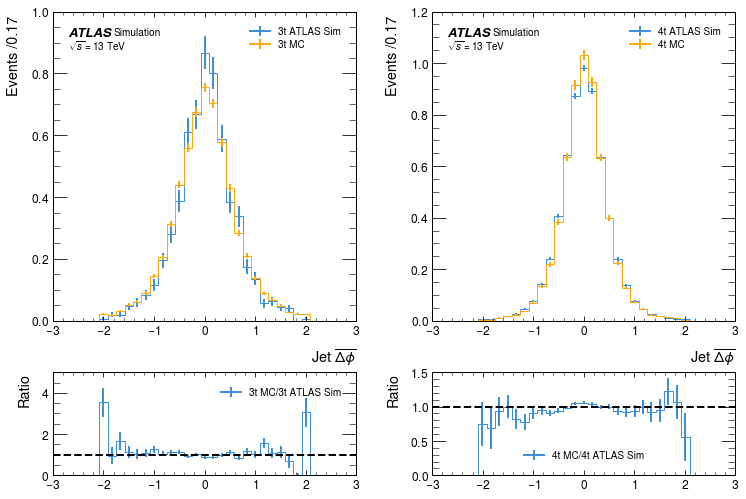

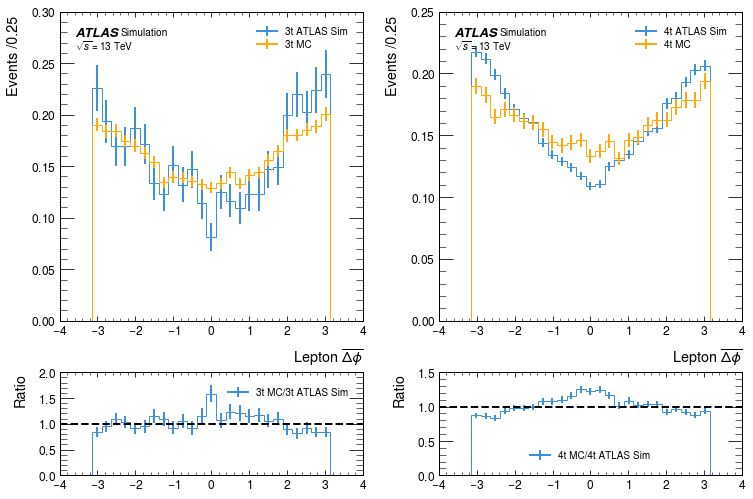

In [16]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_deltaphi_3t_1,jet_deltaphi_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $\overline{\Delta\phi}$')
histogram([jet_deltaphi_4t_1, jet_deltaphi_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Jet $\overline{\Delta\phi}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([lepton_deltaphi_3t_1,lepton_deltaphi_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Lepton $\overline{\Delta\phi}$')
histogram([lepton_deltaphi_4t_1, lepton_deltaphi_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Lepton $\overline{\Delta\phi}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

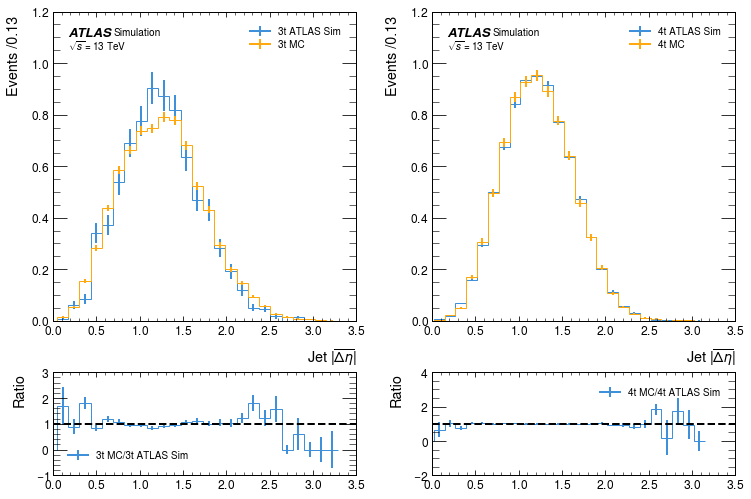

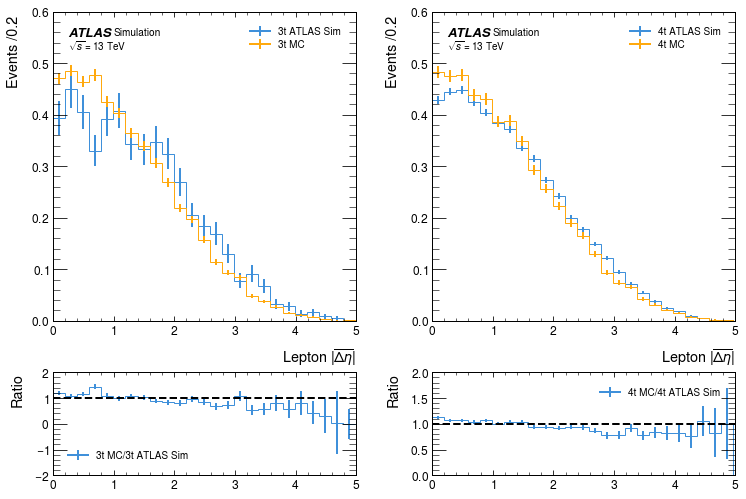

In [17]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_deltaeta_3t_1,jet_deltaeta_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $|\overline{\Delta\eta}|$')
histogram([jet_deltaeta_4t_1, jet_deltaeta_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Jet $|\overline{\Delta\eta}|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([lepton_deltaeta_3t_1,lepton_deltaeta_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Lepton $|\overline{\Delta\eta}|$')
histogram([lepton_deltaeta_4t_1, lepton_deltaeta_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Lepton $|\overline{\Delta\eta}|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

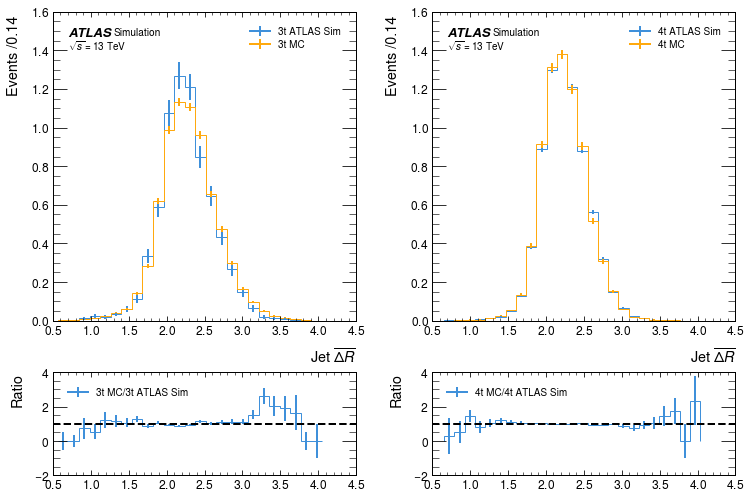

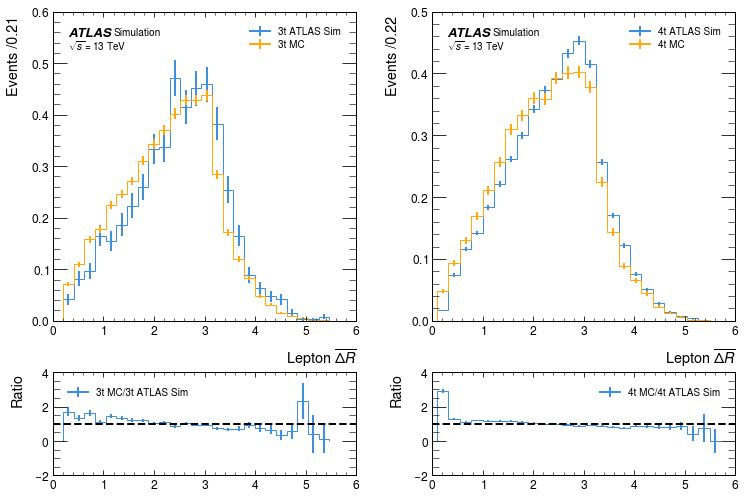

In [18]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_deltaR_3t_1,jet_deltaR_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $\overline{\Delta R}$')
histogram([jet_deltaR_4t_1, jet_deltaR_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Jet $\overline{\Delta R}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([lepton_deltaR_3t_1,lepton_deltaR_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Lepton $\overline{\Delta R}$')
histogram([lepton_deltaR_4t_1, lepton_deltaR_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,1].set_xlabel(r'Lepton $\overline{\Delta R}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

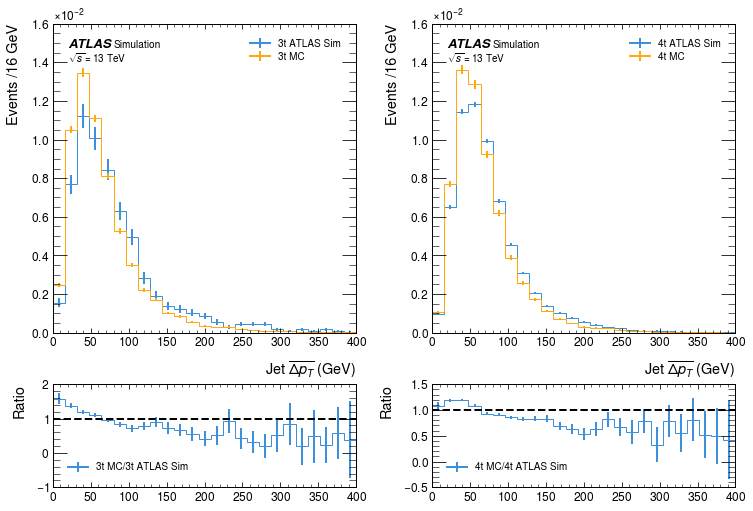

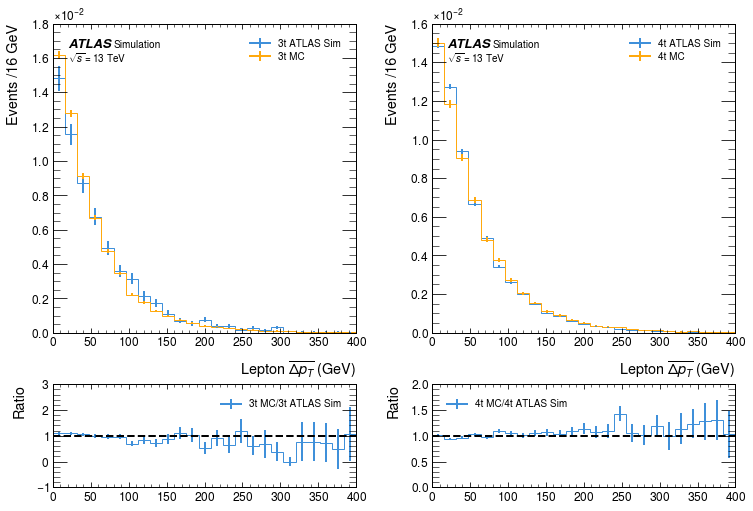

In [19]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_deltapt_3t_1, jet_deltapt_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,400))
ax[0,0].set_xlabel(r'Jet $\overline{\Delta p_T}$ (GeV)')
histogram([jet_deltapt_4t_1, jet_deltapt_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,400))
ax[0,1].set_xlabel(r'Jet $\overline{\Delta p_T}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([lepton_deltapt_3t_1, lepton_deltapt_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,400))
ax[0,0].set_xlabel(r'Lepton $\overline{\Delta p_T}$ (GeV)')
histogram([lepton_deltapt_4t_1, lepton_deltapt_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,400))
ax[0,1].set_xlabel(r'Lepton $\overline{\Delta p_T}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

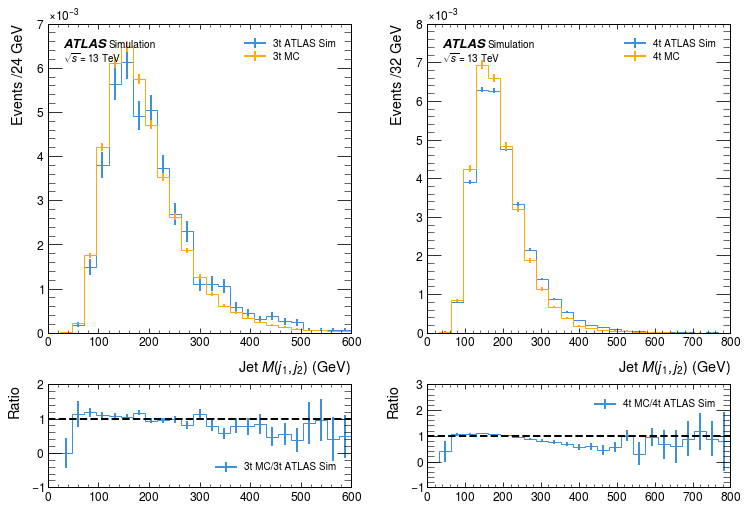

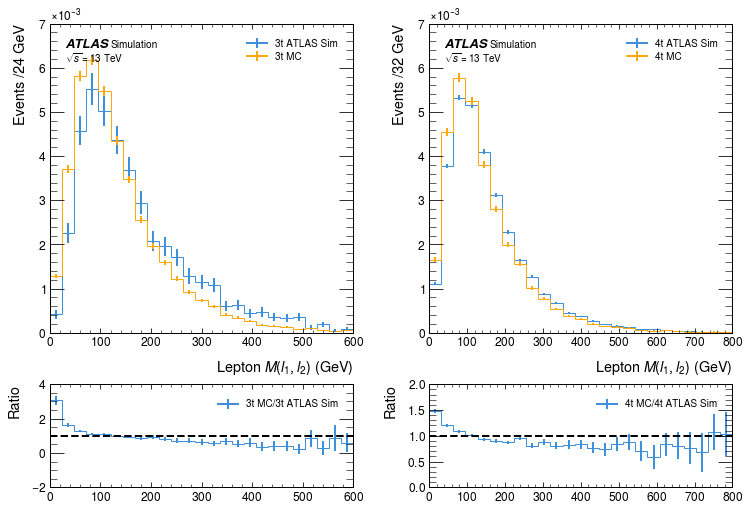

In [20]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_duo_masses_3t_1, jet_duo_masses_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,600))
ax[0,0].set_xlabel(r'Jet ${M(j_1,j_2)}$ (GeV)')
histogram([jet_duo_masses_4t_1, jet_duo_masses_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Jet ${M(j_1,j_2)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([lepton_duo_masses_3t_1, lepton_duo_masses_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,600))
ax[0,0].set_xlabel(r'Lepton ${M(l_1,l_2)}$ (GeV)')
histogram([lepton_duo_masses_4t_1, lepton_duo_masses_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Lepton ${M(l_1,l_2)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

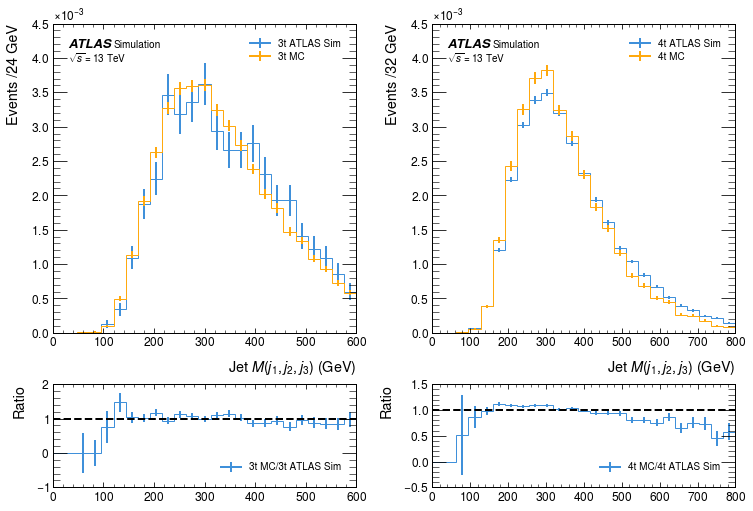

/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:21: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:22: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist

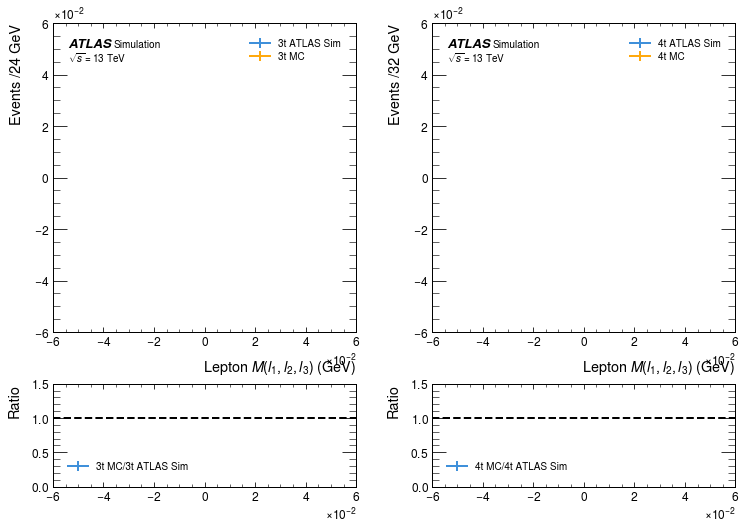

In [21]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_trio_masses_3t_1, jet_trio_masses_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,600))
ax[0,0].set_xlabel(r'Jet ${M(j_1,j_2, j_3)}$ (GeV)')
histogram([jet_trio_masses_4t_1, jet_trio_masses_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Jet ${M(j_1,j_2, j_3)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([lepton_trio_masses_3t_1, lepton_trio_masses_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,600))
ax[0,0].set_xlabel(r'Lepton ${M(l_1,l_2, l_3)}$ (GeV)')
histogram([lepton_trio_masses_4t_1, lepton_trio_masses_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Lepton ${M(l_1,l_2, l_3)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

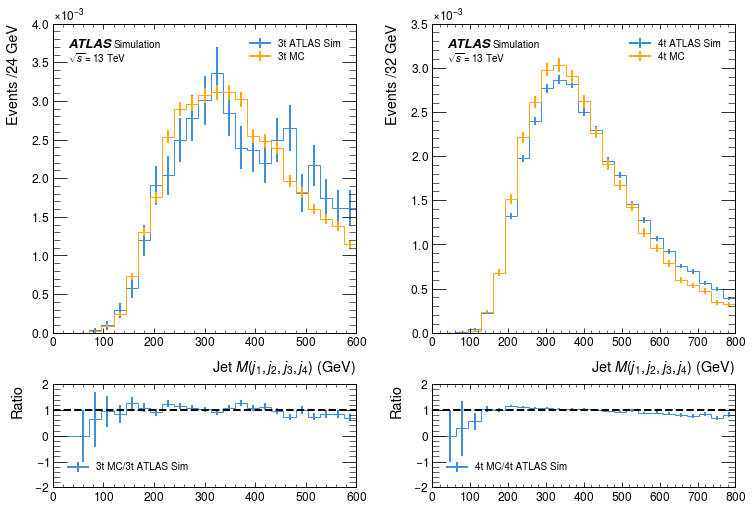

/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:21: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:22: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist

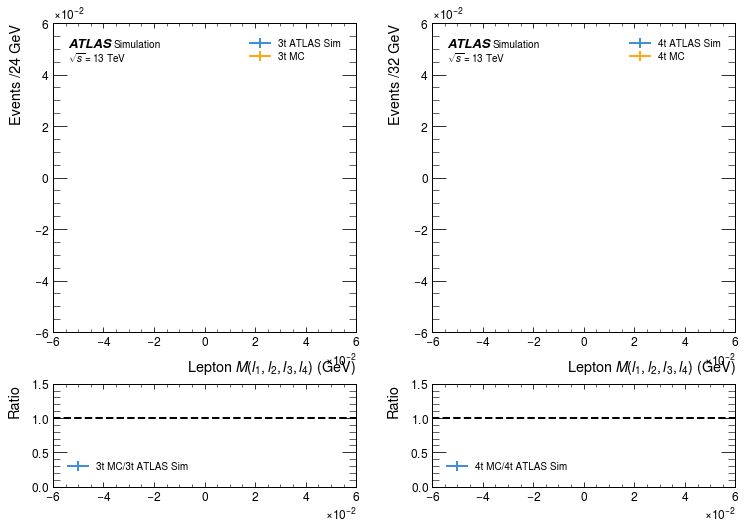

In [22]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_quad_masses_3t_1, jet_quad_masses_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,600))
ax[0,0].set_xlabel(r'Jet ${M(j_1,j_2, j_3, j_4)}$ (GeV)')
histogram([jet_quad_masses_4t_1, jet_quad_masses_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Jet ${M(j_1,j_2, j_3, j_4)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([lepton_quad_masses_3t_1, lepton_quad_masses_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,600))
ax[0,0].set_xlabel(r'Lepton ${M(l_1,l_2, l_3, l_4)}$ (GeV)')
histogram([lepton_quad_masses_4t_1, lepton_quad_masses_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Lepton ${M(l_1,l_2, l_3, l_4)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

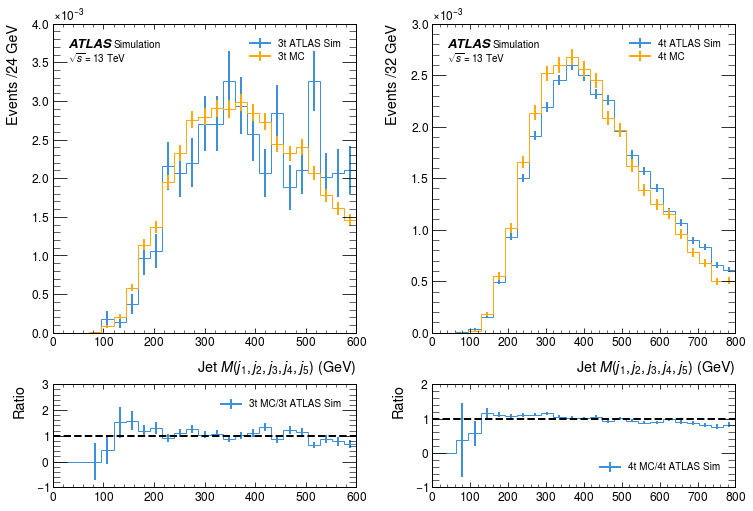

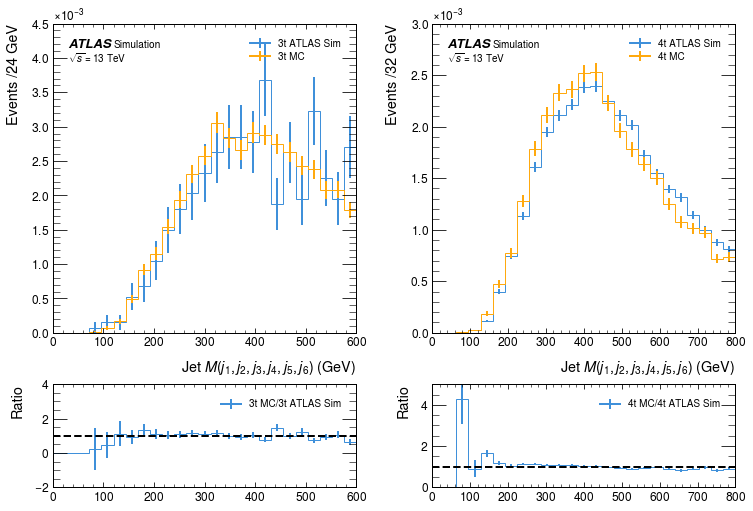

In [23]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_5_masses_3t_1, jet_5_masses_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,600))
ax[0,0].set_xlabel(r'Jet ${M(j_1,j_2, j_3, j_4, j_5)}$ (GeV)')
histogram([jet_5_masses_4t_1, jet_5_masses_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Jet ${M(j_1,j_2, j_3, j_4, j_5)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jet_6_masses_3t_1, jet_6_masses_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,600))
ax[0,0].set_xlabel(r'Jet ${M(j_1,j_2, j_3, j_4, j_5, j_6)}$ (GeV)')
histogram([jet_6_masses_4t_1, jet_6_masses_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,800))
ax[0,1].set_xlabel(r'Jet ${M(j_1,j_2, j_3, j_4, j_5, j_6)}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

In [24]:
jets_4t_total_4_1 = np.sum(jets_4t_1, axis=1)
jets_4t_H_t_1 = np.sum(jets_4t_1.pt, axis=1)
jets_pt_balance_4t_1 = jets_4t_total_4_1.pt/jets_4t_H_t_1

leptons_4t_total_4_1 = np.sum(leptons_4t_1, axis=1)
leptons_4t_H_t_1 = np.sum(leptons_4t_1.pt, axis=1)
leptons_pt_balance_4t_1 = leptons_4t_total_4_1.pt/leptons_4t_H_t_1

jets_3t_total_4_1 = np.sum(jets_3t_1, axis=1)
jets_3t_H_t_1 = np.sum(jets_3t_1.pt, axis=1)
jets_pt_balance_3t_1 = jets_3t_total_4_1.pt/jets_3t_H_t_1

leptons_3t_total_4_1 = np.sum(leptons_3t_1, axis=1)
leptons_3t_H_t_1 = np.sum(leptons_3t_1.pt, axis=1)
leptons_pt_balance_3t_1 = leptons_3t_total_4_1.pt/leptons_3t_H_t_1

total_4_3t_1 = np.sum(all_products_3t_1, axis=1)
H_t_3t_1 = np.sum(all_products_3t_1.pt, axis=1)
pt_balance_3t_1 = total_4_3t_1.pt/H_t_3t_1

total_4_4t_1 = np.sum(all_products_4t_1, axis=1)
H_t_4t_1 = np.sum(all_products_4t_1.pt, axis=1)
pt_balance_4t_1 = total_4_4t_1.pt/H_t_4t_1

jets_4t_total_4_2 = np.sum(jets_4t_2, axis=1)
jets_4t_H_t_2 = np.sum(jets_4t_2.pt, axis=1)
jets_pt_balance_4t_2 = jets_4t_total_4_2.pt/jets_4t_H_t_2

leptons_4t_total_4_2 = np.sum(leptons_4t_2, axis=1)
leptons_4t_H_t_2 = np.sum(leptons_4t_2.pt, axis=1)
leptons_pt_balance_4t_2 = leptons_4t_total_4_2.pt/leptons_4t_H_t_2

jets_3t_total_4_2 = np.sum(jets_3t_2, axis=1)
jets_3t_H_t_2 = np.sum(jets_3t_2.pt, axis=1)
jets_pt_balance_3t_2 = jets_3t_total_4_2.pt/jets_3t_H_t_2

leptons_3t_total_4_2 = np.sum(leptons_3t_2, axis=1)
leptons_3t_H_t_2 = np.sum(leptons_3t_2.pt, axis=1)
leptons_pt_balance_3t_2 = leptons_3t_total_4_2.pt/leptons_3t_H_t_2

total_4_3t_2 = np.sum(all_products_3t_2, axis=1)
H_t_3t_2 = np.sum(all_products_3t_2.pt, axis=1)
pt_balance_3t_2 = total_4_3t_2.pt/H_t_3t_2

total_4_4t_2 = np.sum(all_products_4t_2, axis=1)
H_t_4t_2 = np.sum(all_products_4t_2.pt, axis=1)
pt_balance_4t_2 = total_4_4t_2.pt/H_t_4t_2


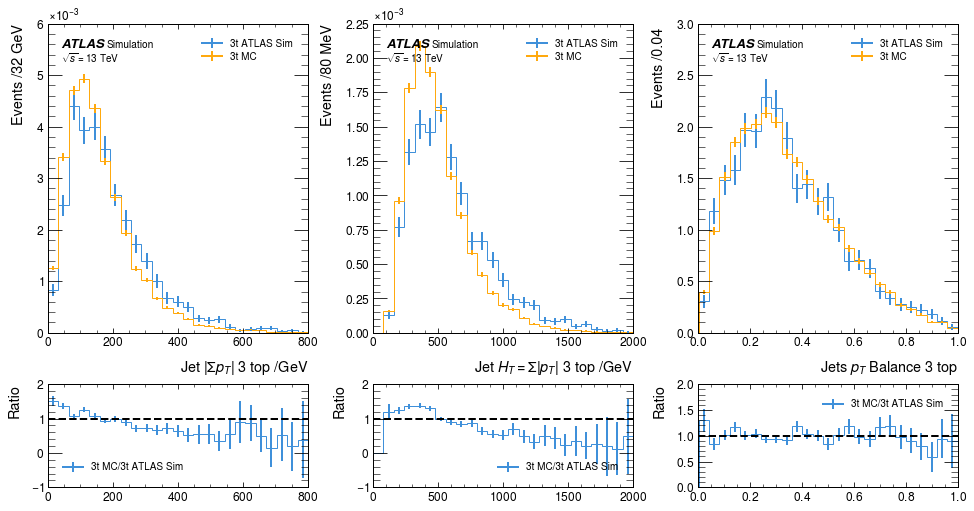

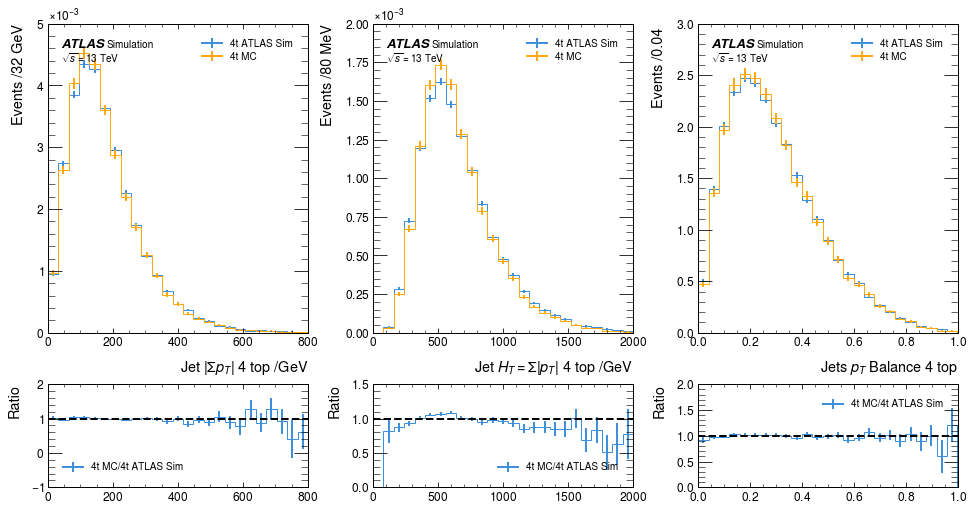

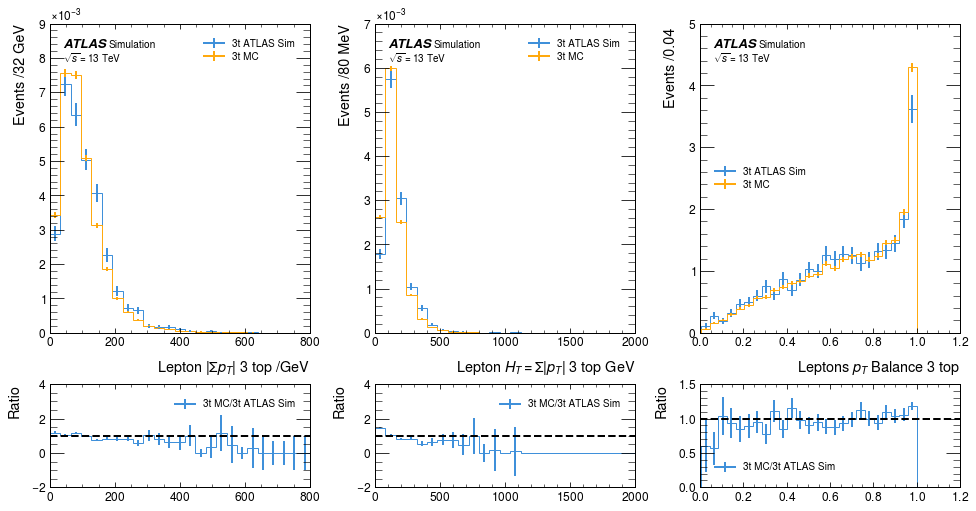

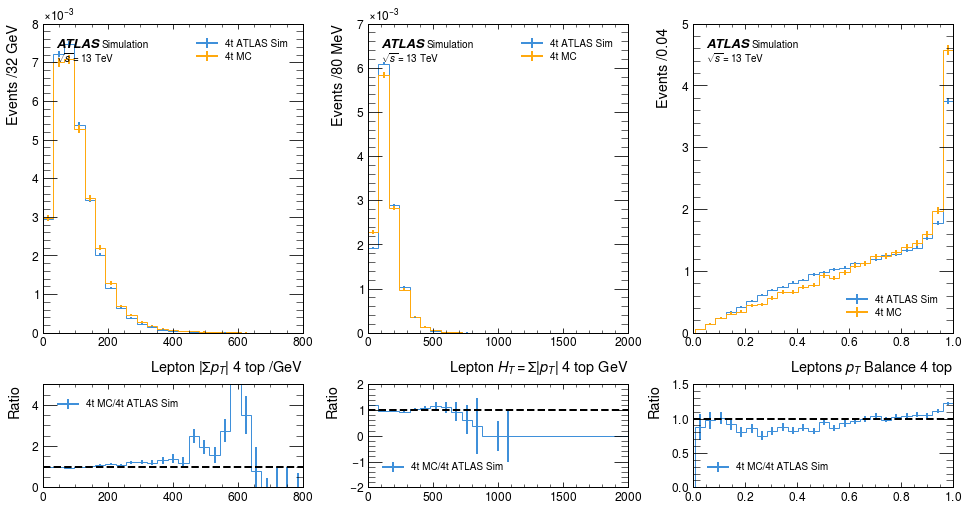

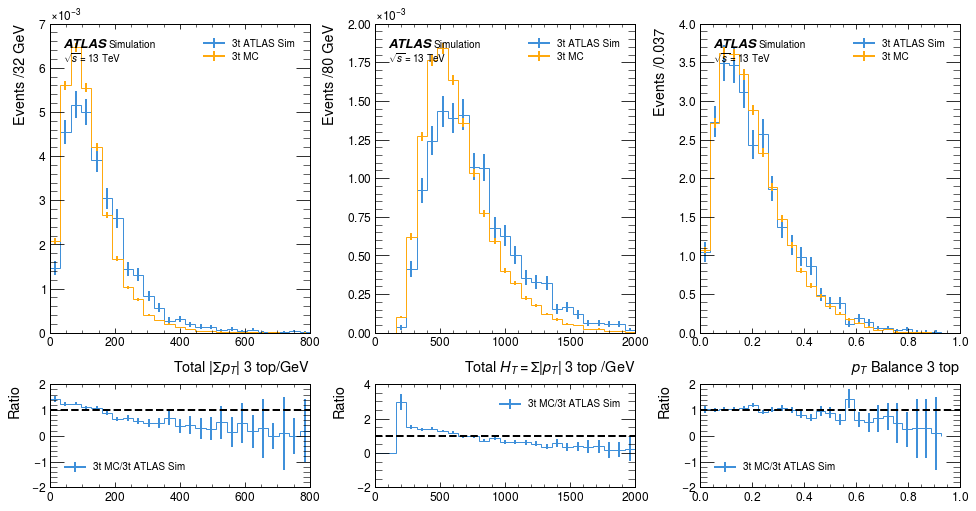

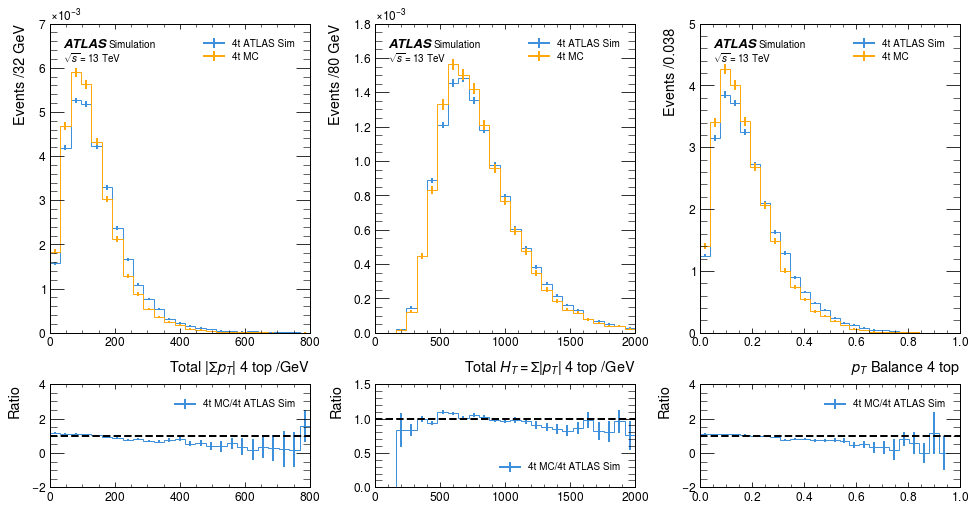

In [25]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([jets_3t_total_4_1.pt, jets_3t_total_4_2.pt], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Jet $|\Sigma p_T|$ 3 top /GeV')
histogram([jets_3t_H_t_1, jets_3t_H_t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='MeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Jet $H_T = \Sigma|p_T|$ 3 top /GeV')
histogram([jets_pt_balance_3t_1, jets_pt_balance_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'Jets $p_T$ Balance 3 top')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([jets_4t_total_4_1.pt, jets_4t_total_4_2.pt], 25, ['4t ATLAS Sim','4t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Jet $|\Sigma p_T|$ 4 top /GeV')
histogram([jets_4t_H_t_1, jets_4t_H_t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='MeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Jet $H_T = \Sigma|p_T|$ 4 top /GeV')
histogram([jets_pt_balance_4t_1, jets_pt_balance_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'Jets $p_T$ Balance 4 top')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([leptons_3t_total_4_1.pt, leptons_3t_total_4_2.pt], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Lepton $|\Sigma p_T|$ 3 top /GeV')
histogram([leptons_3t_H_t_1, leptons_3t_H_t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='MeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Lepton $H_T = \Sigma|p_T|$ 3 top GeV')
histogram([leptons_pt_balance_3t_1, leptons_pt_balance_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'Leptons $p_T$ Balance 3 top')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([leptons_4t_total_4_1.pt, leptons_4t_total_4_2.pt], 25, ['4t ATLAS Sim','4t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Lepton $|\Sigma p_T|$ 4 top /GeV')
histogram([leptons_4t_H_t_1, leptons_4t_H_t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='MeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Lepton $H_T = \Sigma|p_T|$ 4 top GeV')
histogram([leptons_pt_balance_4t_1, leptons_pt_balance_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'Leptons $p_T$ Balance 4 top')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([total_4_3t_1.pt, total_4_3t_2.pt], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Total $|\Sigma p_T|$ 3 top/GeV')
histogram([H_t_3t_1, H_t_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Total $H_T = \Sigma|p_T|$ 3 top /GeV')
histogram([pt_balance_3t_1, pt_balance_3t_2], 25, ['3t ATLAS Sim','3t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'$p_T$ Balance 3 top')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([total_4_4t_1.pt, total_4_4t_2.pt], 25, ['4t ATLAS Sim','4t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Total $|\Sigma p_T|$ 4 top /GeV')
histogram([H_t_4t_1, H_t_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Total $H_T = \Sigma|p_T|$ 4 top /GeV')
histogram([pt_balance_4t_1, pt_balance_4t_2], 25, ['4t ATLAS Sim','4t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'$p_T$ Balance 4 top')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

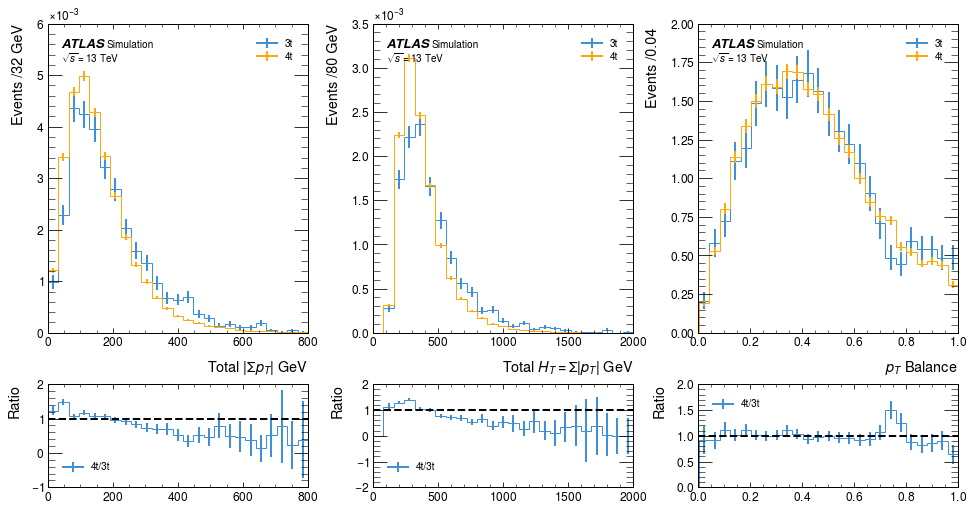

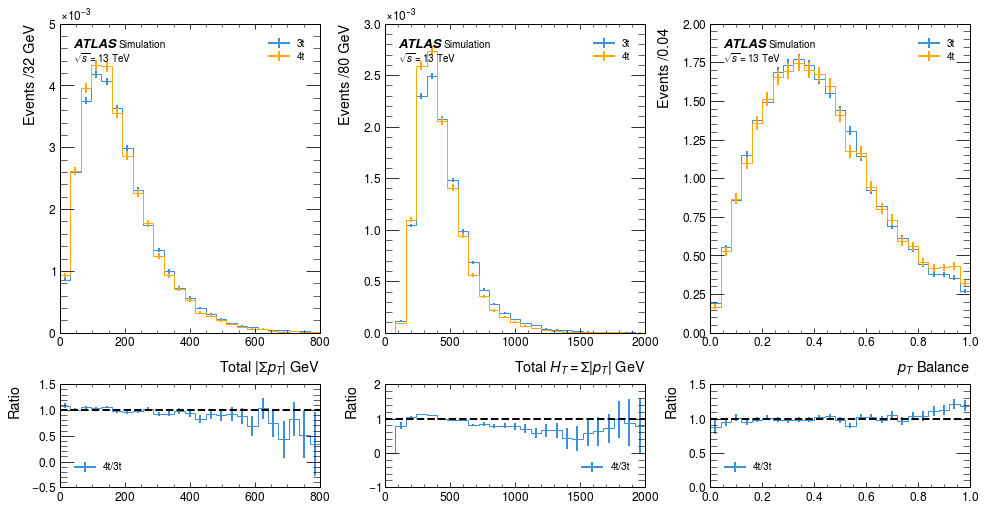

In [26]:
leading_jets_4t_H_t_1 = np.sum(leading_jets_4t_1.rho, axis=0)
leading_jets_pt_balance_4t_1 = leading_jets_4t_total_1.pt/leading_jets_4t_H_t_1

leading_jets_3t_H_t_1 = np.sum(leading_jets_3t_1.rho, axis=0)
leading_jets_pt_balance_3t_1 = leading_jets_3t_total_1.pt/leading_jets_3t_H_t_1

leading_jets_4t_H_t_2 = np.sum(leading_jets_4t_2.rho, axis=0)
leading_jets_pt_balance_4t_2 = leading_jets_4t_total_2.pt/leading_jets_4t_H_t_2

leading_jets_3t_H_t_2 = np.sum(leading_jets_3t_2.rho, axis=0)
leading_jets_pt_balance_3t_2 = leading_jets_3t_total_2.pt/leading_jets_3t_H_t_2

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([leading_jets_3t_total_1.pt, leading_jets_3t_total_2.pt], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Total $|\Sigma p_T|$ GeV')
histogram([leading_jets_3t_H_t_1, leading_jets_3t_H_t_2], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Total $H_T = \Sigma|p_T|$ GeV')
histogram([leading_jets_pt_balance_3t_1, leading_jets_pt_balance_3t_2], 25, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'$p_T$ Balance')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(16,8))
histogram([leading_jets_4t_total_1.pt, leading_jets_4t_total_2.pt], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,800))
ax[0,0].set_xlabel(r'Total $|\Sigma p_T|$ GeV')
histogram([leading_jets_4t_H_t_1, leading_jets_4t_H_t_2], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,2000))
ax[0,1].set_xlabel(r'Total $H_T = \Sigma|p_T|$ GeV')
histogram([leading_jets_pt_balance_4t_1, leading_jets_pt_balance_4t_2], 25, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,2].set_xlabel(r'$p_T$ Balance')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

In [27]:
leptons_2LSS_4t_1 = leptons_4t_1[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t_1,leptons_charge_4t_1)]).flatten()]
jets_2LSS_4t_1 = jets_4t_1[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t_1,leptons_charge_4t_1)]).flatten()]

leptons_3L_4t_1 = leptons_4t_1[np.argwhere([len(a1) >= 3 for a1 in leptons_4t_1]).flatten()]
jets_3L_4t_1 = jets_4t_1[np.argwhere([len(a1) >= 3 for a1 in leptons_4t_1]).flatten()]

ratio_2LSS_4t_1 = len(leptons_2LSS_4t_1)/(len(leptons_2LSS_4t_1) + len(leptons_3L_4t_1))
ratio_3L_4t_1 = len(leptons_3L_4t_1)/(len(leptons_2LSS_4t_1) + len(leptons_3L_4t_1))

leptons_2LSS_3t_1 = leptons_3t_1[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t_1,leptons_charge_3t_1)]).flatten()]
jets_2LSS_3t_1 = jets_3t_1[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t_1,leptons_charge_3t_1)]).flatten()]

leptons_3L_3t_1 = leptons_3t_1[np.argwhere([len(a1) >= 3 for a1 in leptons_3t_1]).flatten()]
jets_3L_3t_1 = jets_3t_1[np.argwhere([len(a1) >= 3 for a1 in leptons_3t_1]).flatten()]

leptons_2LSS_4t_2 = leptons_4t_2[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t_2,leptons_charge_4t_2)]).flatten()]
jets_2LSS_4t_2 = jets_4t_2[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t_2,leptons_charge_4t_2)]).flatten()]

leptons_3L_4t_2 = leptons_4t_2[np.argwhere([len(a1) >= 3 for a1 in leptons_4t_2]).flatten()]
jets_3L_4t_2 = jets_4t_2[np.argwhere([len(a1) >= 3 for a1 in leptons_4t_2]).flatten()]

ratio_2LSS_4t_2 = len(leptons_2LSS_4t_2)/(len(leptons_2LSS_4t_2) + len(leptons_3L_4t_2))
ratio_3L_4t_2 = len(leptons_3L_4t_2)/(len(leptons_2LSS_4t_2) + len(leptons_3L_4t_2))

leptons_2LSS_3t_2 = leptons_3t_2[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t_2,leptons_charge_3t_2)]).flatten()]
jets_2LSS_3t_2 = jets_3t_2[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t_2,leptons_charge_3t_2)]).flatten()]

leptons_3L_3t_2 = leptons_3t_2[np.argwhere([len(a1) >= 3 for a1 in leptons_3t_2]).flatten()]
jets_3L_3t_2 = jets_3t_2[np.argwhere([len(a1) >= 3 for a1 in leptons_3t_2]).flatten()]

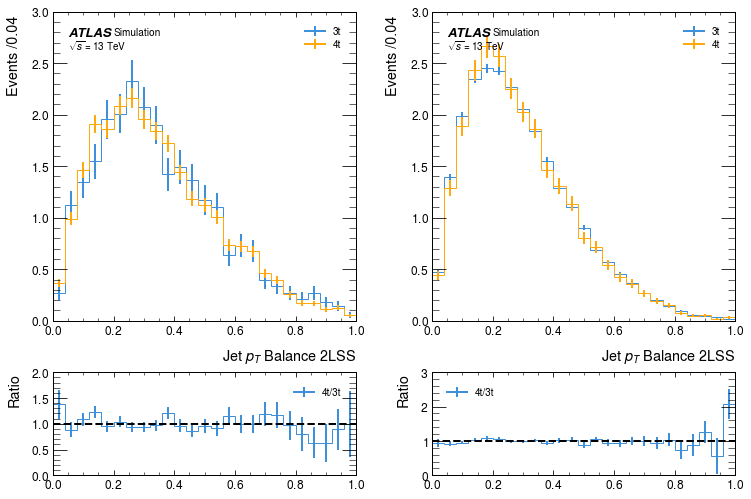

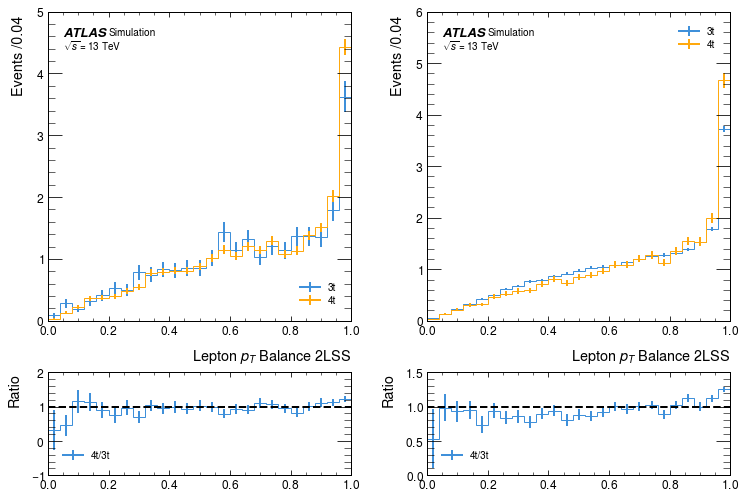

/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:21: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:22: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist

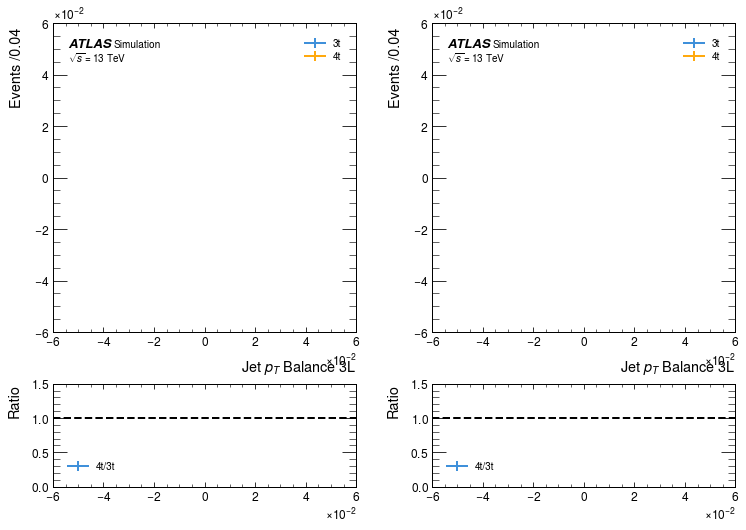

/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:21: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:22: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_8474/1291502679.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist

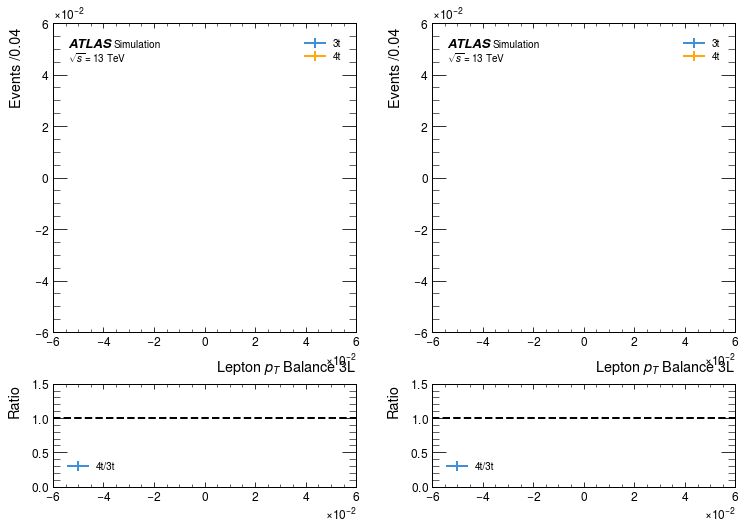

In [28]:
jets_pt_balance_4t_2LSS_1 = np.sum(jets_2LSS_4t_1, axis=1).pt/np.sum(jets_2LSS_4t_1.pt, axis=1)
jets_pt_balance_3t_2LSS_1 = np.sum(jets_2LSS_3t_1, axis=1).pt/np.sum(jets_2LSS_3t_1.pt, axis=1)

jets_pt_balance_4t_3L_1 = np.sum(jets_3L_4t_1, axis=1).pt/np.sum(jets_3L_4t_1.pt, axis=1)
jets_pt_balance_3t_3L_1 = np.sum(jets_3L_3t_1, axis=1).pt/np.sum(jets_3L_3t_1.pt, axis=1)

leptons_pt_balance_4t_2LSS_1 = np.sum(leptons_2LSS_4t_1, axis=1).pt/np.sum(leptons_2LSS_4t_1.pt, axis=1)
leptons_pt_balance_3t_2LSS_1 = np.sum(leptons_2LSS_3t_1, axis=1).pt/np.sum(leptons_2LSS_3t_1.pt, axis=1)

leptons_pt_balance_4t_3L_1 = np.sum(leptons_3L_4t_1, axis=1).pt/np.sum(leptons_3L_4t_1.pt, axis=1)
leptons_pt_balance_3t_3L_1 = np.sum(leptons_3L_3t_1, axis=1).pt/np.sum(leptons_3L_3t_1.pt, axis=1)

jets_pt_balance_4t_2LSS_2 = np.sum(jets_2LSS_4t_2, axis=1).pt/np.sum(jets_2LSS_4t_2.pt, axis=1)
jets_pt_balance_3t_2LSS_2 = np.sum(jets_2LSS_3t_2, axis=1).pt/np.sum(jets_2LSS_3t_2.pt, axis=1)

jets_pt_balance_4t_3L_2 = np.sum(jets_3L_4t_2, axis=1).pt/np.sum(jets_3L_4t_2.pt, axis=1)
jets_pt_balance_3t_3L_2 = np.sum(jets_3L_3t_2, axis=1).pt/np.sum(jets_3L_3t_2.pt, axis=1)

leptons_pt_balance_4t_2LSS_2 = np.sum(leptons_2LSS_4t_2, axis=1).pt/np.sum(leptons_2LSS_4t_2.pt, axis=1)
leptons_pt_balance_3t_2LSS_2 = np.sum(leptons_2LSS_3t_2, axis=1).pt/np.sum(leptons_2LSS_3t_2.pt, axis=1)

leptons_pt_balance_4t_3L_2 = np.sum(leptons_3L_4t_2, axis=1).pt/np.sum(leptons_3L_4t_2.pt, axis=1)
leptons_pt_balance_3t_3L_2 = np.sum(leptons_3L_3t_2, axis=1).pt/np.sum(leptons_3L_3t_2.pt, axis=1)

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jets_pt_balance_3t_2LSS_1, jets_pt_balance_3t_2LSS_2], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,1))
ax[0,0].set_xlabel(r'Jet $p_T$ Balance 2LSS')
histogram([jets_pt_balance_4t_2LSS_1, jets_pt_balance_4t_2LSS_2], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,1))
ax[0,1].set_xlabel(r'Jet $p_T$ Balance 2LSS')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([leptons_pt_balance_3t_2LSS_1, leptons_pt_balance_3t_2LSS_2], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,1))
ax[0,0].set_xlabel(r'Lepton $p_T$ Balance 2LSS')
histogram([leptons_pt_balance_4t_2LSS_1, leptons_pt_balance_4t_2LSS_2], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,1))
ax[0,1].set_xlabel(r'Lepton $p_T$ Balance 2LSS')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jets_pt_balance_3t_3L_1, jets_pt_balance_3t_3L_2], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,1))
ax[0,0].set_xlabel(r'Jet $p_T$ Balance 3L')
histogram([jets_pt_balance_4t_3L_1, jets_pt_balance_4t_3L_2], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,1))
ax[0,1].set_xlabel(r'Jet $p_T$ Balance 3L')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()


fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([leptons_pt_balance_3t_3L_1, leptons_pt_balance_3t_3L_2], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,1))
ax[0,0].set_xlabel(r'Lepton $p_T$ Balance 3L')
histogram([leptons_pt_balance_4t_3L_1, leptons_pt_balance_4t_3L_2], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,1))
ax[0,1].set_xlabel(r'Lepton $p_T$ Balance 3L')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

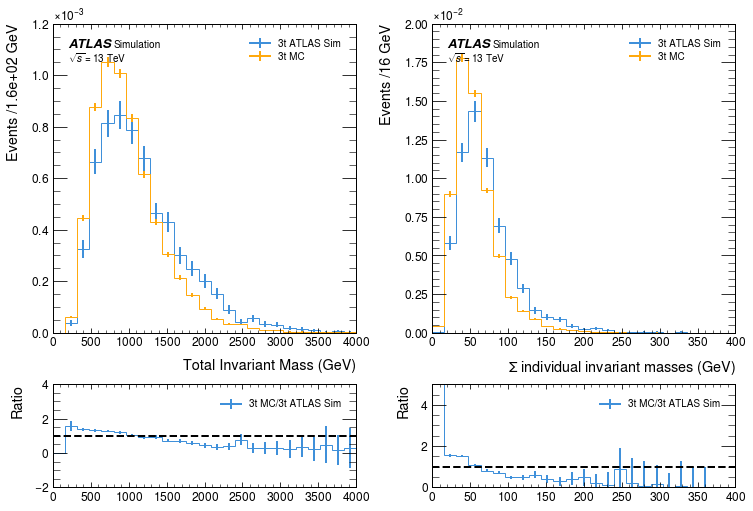

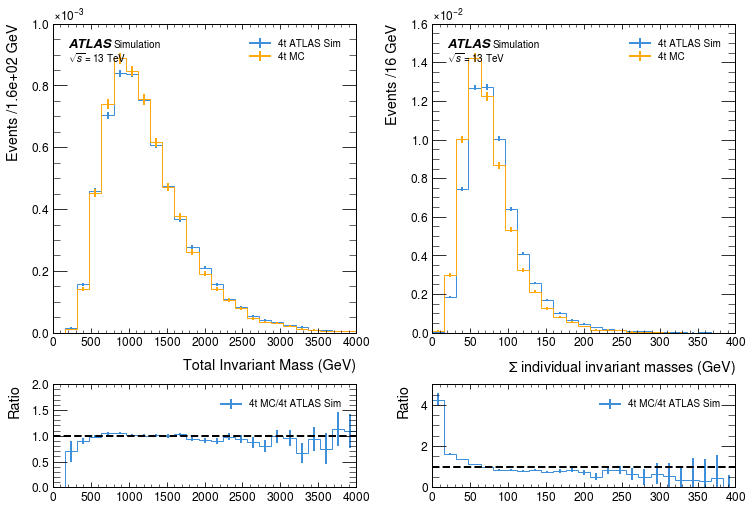

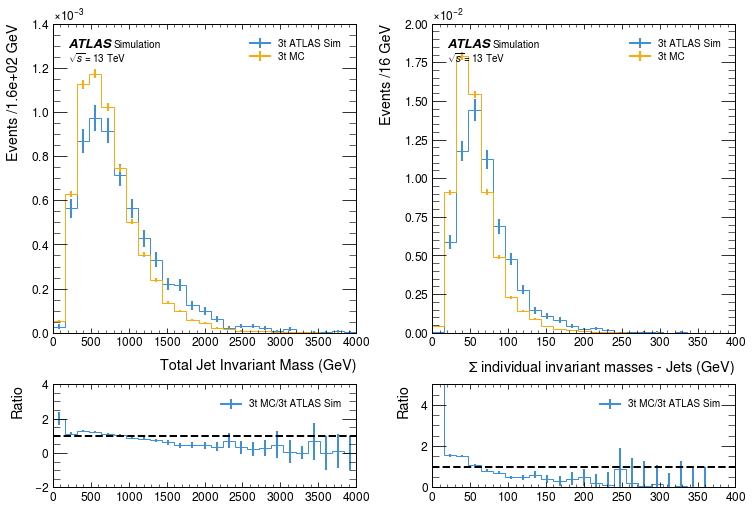

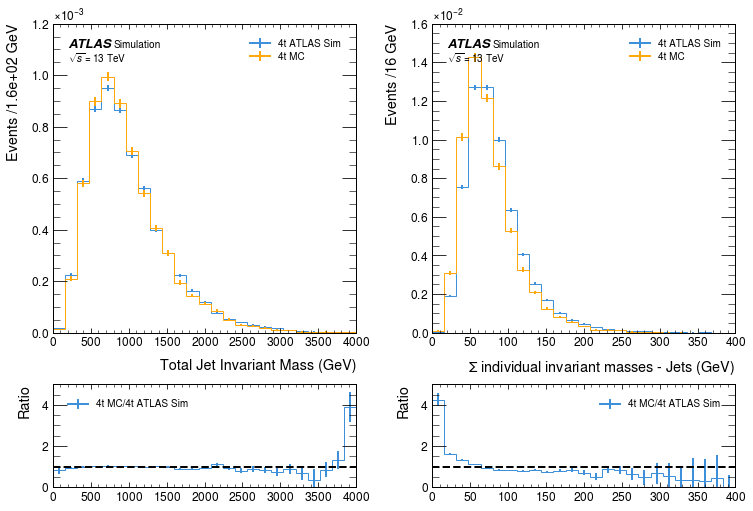

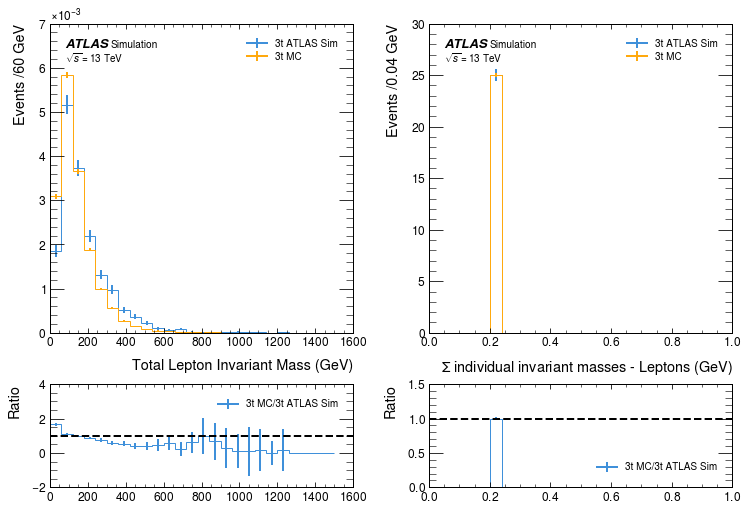

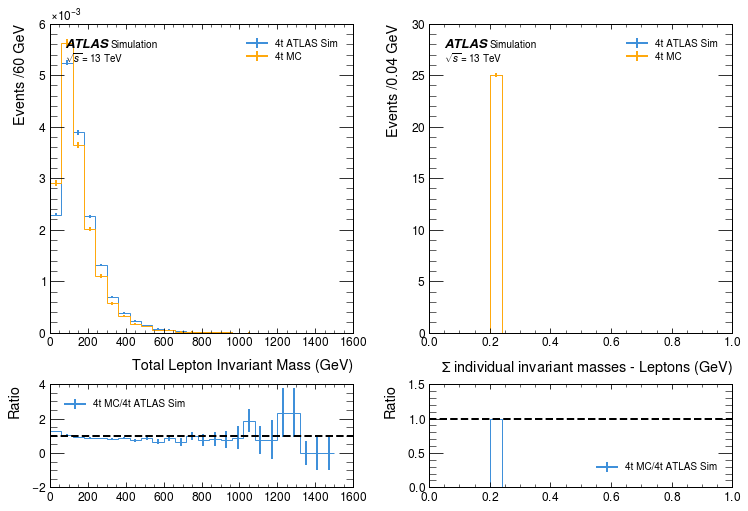

In [29]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([total_4_3t_1.m, total_4_3t_2.m], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,4000))
ax[0,0].set_xlabel(r'Total Invariant Mass (GeV)')
histogram([np.sum(all_products_3t_1.m, axis=1), np.sum(all_products_3t_2.m, axis=1)], 25, ['3t ATLAS Sim','3t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,400))
ax[0,1].set_xlabel(r'$\Sigma$ individual invariant masses (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([total_4_4t_1.m, total_4_4t_2.m], 25, ['4t ATLAS Sim','4t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,4000))
ax[0,0].set_xlabel(r'Total Invariant Mass (GeV)')
histogram([np.sum(all_products_4t_1.m, axis=1), np.sum(all_products_4t_2.m, axis=1)], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,400))
ax[0,1].set_xlabel(r'$\Sigma$ individual invariant masses (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jets_3t_total_4_1.m, jets_3t_total_4_2.m], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,4000))
ax[0,0].set_xlabel(r'Total Jet Invariant Mass (GeV)')
histogram([np.sum(jets_3t_1.m, axis=1), np.sum(jets_3t_2.m, axis=1)], 25, ['3t ATLAS Sim','3t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,400))
ax[0,1].set_xlabel(r'$\Sigma$ individual invariant masses - Jets (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([jets_4t_total_4_1.m, jets_4t_total_4_2.m], 25, ['4t ATLAS Sim','4t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,4000))
ax[0,0].set_xlabel(r'Total Jet Invariant Mass (GeV)')
histogram([np.sum(jets_4t_1.m, axis=1), np.sum(jets_4t_2.m, axis=1)], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,400))
ax[0,1].set_xlabel(r'$\Sigma$ individual invariant masses - Jets (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()


fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([leptons_3t_total_4_1.m, leptons_3t_total_4_2.m], 25, ['3t ATLAS Sim','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,1500))
ax[0,0].set_xlabel(r'Total Lepton Invariant Mass (GeV)')
histogram([np.sum(leptons_3t_1.m, axis=1), np.sum(leptons_3t_2.m, axis=1)], 25, ['3t ATLAS Sim','3t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,1))
ax[0,1].set_xlabel(r'$\Sigma$ individual invariant masses - Leptons (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(12,8))
histogram([leptons_4t_total_4_1.m, leptons_4t_total_4_2.m], 25, ['4t ATLAS Sim','4t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,1500))
ax[0,0].set_xlabel(r'Total Lepton Invariant Mass (GeV)')
histogram([np.sum(leptons_4t_1.m, axis=1), np.sum(leptons_4t_2.m, axis=1)], 25, ['4t ATLAS Sim','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(0,1))
ax[0,1].set_xlabel(r'$\Sigma$ individual invariant masses - Leptons (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

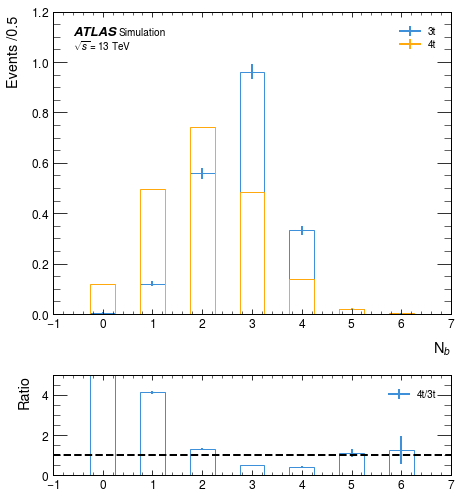

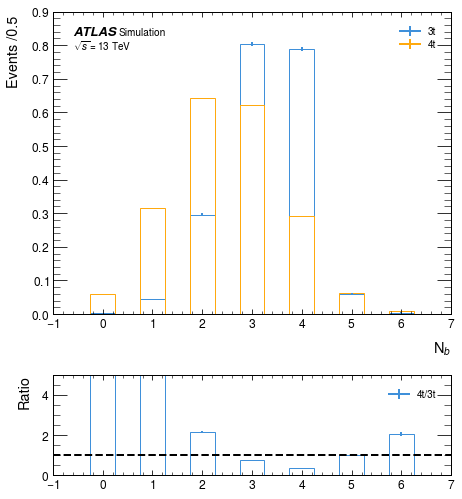

In [30]:
N_B_3t_1 = ak.num(events_3t_1['jet_partonid'][events_3t_1['jet_partonid']==5])
N_B_4t_1 = ak.num(events_4t_1['jet_partonid'][events_4t_1['jet_partonid']==5])

btags_3tj = events_3tj_jets_2['Jet.BTag']
btags_3tW = events_3tW_jets_2['Jet.BTag']
btags_3t = ak.concatenate((btags_3tW,btags_3tW))
N_B_3t_2 = ak.num(btags_3t[btags_3t==1])
N_B_4t_2 = ak.num(events_4t_jets_2['Jet.BTag'][events_4t_jets_2['Jet.BTag']==1])

fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(7,8))
histogram([N_B_3t_1, N_B_3t_2], 14, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='', set_range=(-0.25,6.75))
ax[0].set_xlabel(r'N$_b$')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(7,8))
histogram([N_B_4t_1, N_B_4t_2], 14, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='', set_range=(-0.25,6.75))
ax[0].set_xlabel(r'N$_b$')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

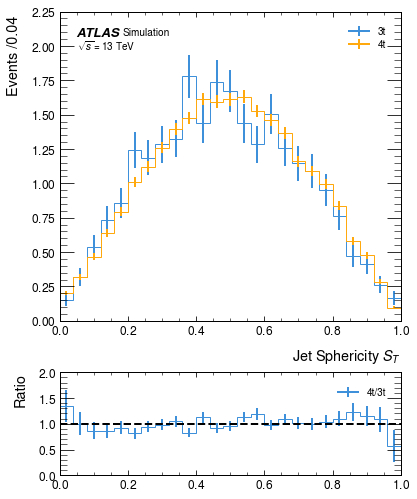

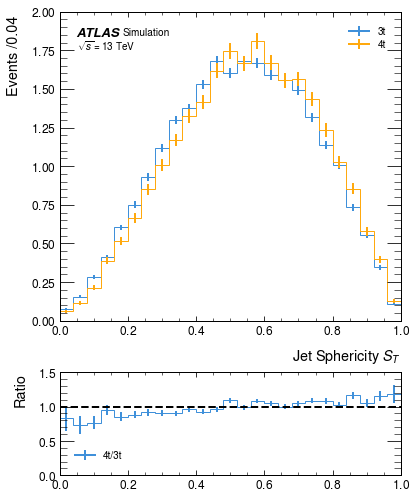

In [31]:
sum_pt_jets_3t_1 = np.sum(jets_3t_1.pt, axis=1)

S_xy_jets_3t_1 = np.zeros((len(jets_3t_1),2,2))


S_xy_jets_3t_1[:,0,0] = np.sum(jets_3t_1.px**2/ jets_3t_1.pt, axis=1)
S_xy_jets_3t_1[:,0,1] = np.sum((jets_3t_1.px*jets_3t_1.py)/ jets_3t_1.pt, axis=1)
S_xy_jets_3t_1[:,1,0] = S_xy_jets_3t_1[:,0,1]
S_xy_jets_3t_1[:,1,1] = np.sum(jets_3t_1.py**2/ jets_3t_1.pt, axis=1)


S_xy_jets_3t_1 = S_xy_jets_3t_1/sum_pt_jets_3t_1[:,np.newaxis,np.newaxis]

eigenvalues_jets_3t_1 = np.linalg.eigvalsh(S_xy_jets_3t_1)

sphericity_jets_3t_1 = 2*np.min(eigenvalues_jets_3t_1, axis=1)/np.sum(eigenvalues_jets_3t_1, axis=1)

sum_pt_jets_4t_1 = np.sum(jets_4t_1.pt, axis=1)

S_xy_jets_4t_1 = np.zeros((len(jets_4t_1),2,2))


S_xy_jets_4t_1[:,0,0] = np.sum(jets_4t_1.px**2/ jets_4t_1.pt, axis=1)
S_xy_jets_4t_1[:,0,1] = np.sum((jets_4t_1.px*jets_4t_1.py)/ jets_4t_1.pt, axis=1)
S_xy_jets_4t_1[:,1,0] = S_xy_jets_4t_1[:,0,1]
S_xy_jets_4t_1[:,1,1] = np.sum(jets_4t_1.py**2/ jets_4t_1.pt, axis=1)


S_xy_jets_4t_1 = S_xy_jets_4t_1/sum_pt_jets_4t_1[:,np.newaxis,np.newaxis]

eigenvalues_jets_4t_1 = np.linalg.eigvalsh(S_xy_jets_4t_1)

sphericity_jets_4t_1 = 2*np.min(eigenvalues_jets_4t_1, axis=1)/np.sum(eigenvalues_jets_4t_1, axis=1)

sum_pt_jets_3t_2 = np.sum(jets_3t_2.pt, axis=1)

S_xy_jets_3t_2 = np.zeros((len(jets_3t_2),2,2))


S_xy_jets_3t_2[:,0,0] = np.sum(jets_3t_2.px**2/ jets_3t_2.pt, axis=1)
S_xy_jets_3t_2[:,0,1] = np.sum((jets_3t_2.px*jets_3t_2.py)/ jets_3t_2.pt, axis=1)
S_xy_jets_3t_2[:,1,0] = S_xy_jets_3t_2[:,0,1]
S_xy_jets_3t_2[:,1,1] = np.sum(jets_3t_2.py**2/ jets_3t_2.pt, axis=1)


S_xy_jets_3t_2 = S_xy_jets_3t_2/sum_pt_jets_3t_2[:,np.newaxis,np.newaxis]

eigenvalues_jets_3t_2 = np.linalg.eigvalsh(S_xy_jets_3t_2)

sphericity_jets_3t_2 = 2*np.min(eigenvalues_jets_3t_2, axis=1)/np.sum(eigenvalues_jets_3t_2, axis=1)

sum_pt_jets_4t_2 = np.sum(jets_4t_2.pt, axis=1)

S_xy_jets_4t_2 = np.zeros((len(jets_4t_2),2,2))


S_xy_jets_4t_2[:,0,0] = np.sum(jets_4t_2.px**2/ jets_4t_2.pt, axis=1)
S_xy_jets_4t_2[:,0,1] = np.sum((jets_4t_2.px*jets_4t_2.py)/ jets_4t_2.pt, axis=1)
S_xy_jets_4t_2[:,1,0] = S_xy_jets_4t_2[:,0,1]
S_xy_jets_4t_2[:,1,1] = np.sum(jets_4t_2.py**2/ jets_4t_2.pt, axis=1)


S_xy_jets_4t_2 = S_xy_jets_4t_2/sum_pt_jets_4t_2[:,np.newaxis,np.newaxis]

eigenvalues_jets_4t_2 = np.linalg.eigvalsh(S_xy_jets_4t_2)

sphericity_jets_4t_2 = 2*np.min(eigenvalues_jets_4t_2, axis=1)/np.sum(eigenvalues_jets_4t_2, axis=1)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_jets_3t_1, sphericity_jets_3t_2], 25, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Jet Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_jets_4t_1, sphericity_jets_4t_2], 25, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Jet Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

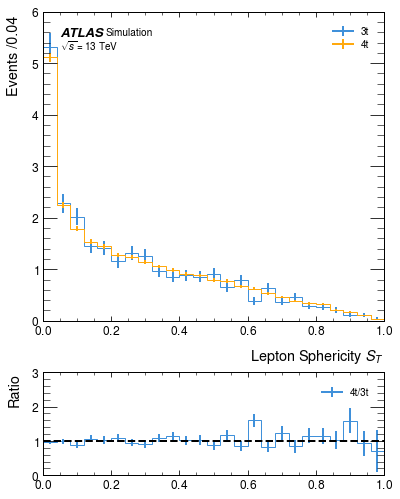

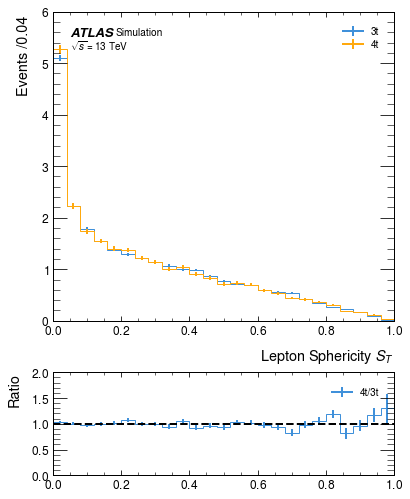

In [32]:
sum_pt_leptons_3t_1 = np.sum(leptons_3t_1.pt, axis=1)

S_xy_leptons_3t_1 = np.zeros((len(leptons_3t_1),2,2))


S_xy_leptons_3t_1[:,0,0] = np.sum(leptons_3t_1.px**2/ leptons_3t_1.pt, axis=1)
S_xy_leptons_3t_1[:,0,1] = np.sum((leptons_3t_1.px*leptons_3t_1.py)/ leptons_3t_1.pt, axis=1)
S_xy_leptons_3t_1[:,1,0] = S_xy_leptons_3t_1[:,0,1]
S_xy_leptons_3t_1[:,1,1] = np.sum(leptons_3t_1.py**2/ leptons_3t_1.pt, axis=1)


S_xy_leptons_3t_1 = S_xy_leptons_3t_1/sum_pt_leptons_3t_1[:,np.newaxis,np.newaxis]

eigenvalues_leptons_3t_1 = np.linalg.eigvalsh(S_xy_leptons_3t_1)

sphericity_leptons_3t_1 = 2*np.min(eigenvalues_leptons_3t_1, axis=1)/np.sum(eigenvalues_leptons_3t_1, axis=1)

sum_pt_leptons_4t_1 = np.sum(leptons_4t_1.pt, axis=1)

S_xy_leptons_4t_1 = np.zeros((len(leptons_4t_1),2,2))


S_xy_leptons_4t_1[:,0,0] = np.sum(leptons_4t_1.px**2/ leptons_4t_1.pt, axis=1)
S_xy_leptons_4t_1[:,0,1] = np.sum((leptons_4t_1.px*leptons_4t_1.py)/ leptons_4t_1.pt, axis=1)
S_xy_leptons_4t_1[:,1,0] = S_xy_leptons_4t_1[:,0,1]
S_xy_leptons_4t_1[:,1,1] = np.sum(leptons_4t_1.py**2/ leptons_4t_1.pt, axis=1)


S_xy_leptons_4t_1 = S_xy_leptons_4t_1/sum_pt_leptons_4t_1[:,np.newaxis,np.newaxis]

eigenvalues_leptons_4t_1 = np.linalg.eigvalsh(S_xy_leptons_4t_1)

sphericity_leptons_4t_1 = 2*np.min(eigenvalues_leptons_4t_1, axis=1)/np.sum(eigenvalues_leptons_4t_1, axis=1)

sum_pt_leptons_3t_2 = np.sum(leptons_3t_2.pt, axis=1)

S_xy_leptons_3t_2 = np.zeros((len(leptons_3t_2),2,2))


S_xy_leptons_3t_2[:,0,0] = np.sum(leptons_3t_2.px**2/ leptons_3t_2.pt, axis=1)
S_xy_leptons_3t_2[:,0,1] = np.sum((leptons_3t_2.px*leptons_3t_2.py)/ leptons_3t_2.pt, axis=1)
S_xy_leptons_3t_2[:,1,0] = S_xy_leptons_3t_2[:,0,1]
S_xy_leptons_3t_2[:,1,1] = np.sum(leptons_3t_2.py**2/ leptons_3t_2.pt, axis=1)


S_xy_leptons_3t_2 = S_xy_leptons_3t_2/sum_pt_leptons_3t_2[:,np.newaxis,np.newaxis]

eigenvalues_leptons_3t_2 = np.linalg.eigvalsh(S_xy_leptons_3t_2)

sphericity_leptons_3t_2 = 2*np.min(eigenvalues_leptons_3t_2, axis=1)/np.sum(eigenvalues_leptons_3t_2, axis=1)

sum_pt_leptons_4t_2 = np.sum(leptons_4t_2.pt, axis=1)

S_xy_leptons_4t_2 = np.zeros((len(leptons_4t_2),2,2))


S_xy_leptons_4t_2[:,0,0] = np.sum(leptons_4t_2.px**2/ leptons_4t_2.pt, axis=1)
S_xy_leptons_4t_2[:,0,1] = np.sum((leptons_4t_2.px*leptons_4t_2.py)/ leptons_4t_2.pt, axis=1)
S_xy_leptons_4t_2[:,1,0] = S_xy_leptons_4t_2[:,0,1]
S_xy_leptons_4t_2[:,1,1] = np.sum(leptons_4t_2.py**2/ leptons_4t_2.pt, axis=1)


S_xy_leptons_4t_2 = S_xy_leptons_4t_2/sum_pt_leptons_4t_2[:,np.newaxis,np.newaxis]

eigenvalues_leptons_4t_2 = np.linalg.eigvalsh(S_xy_leptons_4t_2)

sphericity_leptons_4t_2 = 2*np.min(eigenvalues_leptons_4t_2, axis=1)/np.sum(eigenvalues_leptons_4t_2, axis=1)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_leptons_3t_1, sphericity_leptons_3t_2], 25, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Lepton Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_leptons_4t_1, sphericity_leptons_4t_2], 25, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Lepton Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

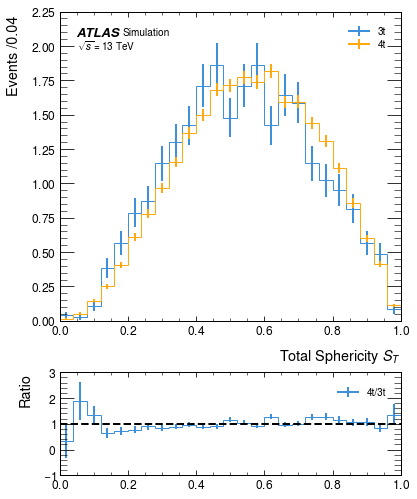

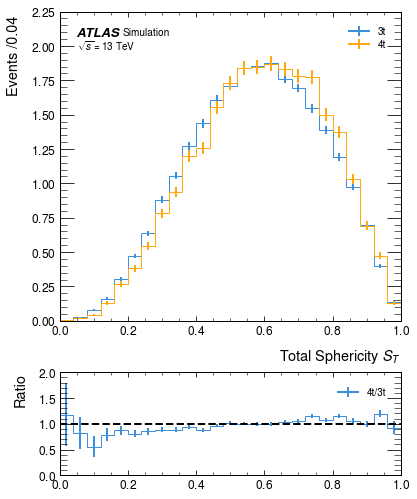

In [33]:
sum_pt_all_3t_1 = np.sum(all_products_3t_1.pt, axis=1)

S_xy_all_3t_1 = np.zeros((len(all_products_3t_1),2,2))


S_xy_all_3t_1[:,0,0] = np.sum(all_products_3t_1.px**2/ all_products_3t_1.pt, axis=1)
S_xy_all_3t_1[:,0,1] = np.sum((all_products_3t_1.px*all_products_3t_1.py)/ all_products_3t_1.pt, axis=1)
S_xy_all_3t_1[:,1,0] = S_xy_all_3t_1[:,0,1]
S_xy_all_3t_1[:,1,1] = np.sum(all_products_3t_1.py**2/ all_products_3t_1.pt, axis=1)


S_xy_all_3t_1 = S_xy_all_3t_1/sum_pt_all_3t_1[:,np.newaxis,np.newaxis]

eigenvalues_all_3t_1 = np.linalg.eigvalsh(S_xy_all_3t_1)

sphericity_all_3t_1 = 2*np.min(eigenvalues_all_3t_1, axis=1)/np.sum(eigenvalues_all_3t_1, axis=1)

sum_pt_all_4t_1 = np.sum(all_products_4t_1.pt, axis=1)

S_xy_all_4t_1 = np.zeros((len(all_products_4t_1),2,2))


S_xy_all_4t_1[:,0,0] = np.sum(all_products_4t_1.px**2/ all_products_4t_1.pt, axis=1)
S_xy_all_4t_1[:,0,1] = np.sum((all_products_4t_1.px*all_products_4t_1.py)/ all_products_4t_1.pt, axis=1)
S_xy_all_4t_1[:,1,0] = S_xy_all_4t_1[:,0,1]
S_xy_all_4t_1[:,1,1] = np.sum(all_products_4t_1.py**2/ all_products_4t_1.pt, axis=1)


S_xy_all_4t_1 = S_xy_all_4t_1/sum_pt_all_4t_1[:,np.newaxis,np.newaxis]

eigenvalues_all_4t_1 = np.linalg.eigvalsh(S_xy_all_4t_1)

sphericity_all_4t_1 = 2*np.min(eigenvalues_all_4t_1, axis=1)/np.sum(eigenvalues_all_4t_1, axis=1)

sum_pt_all_3t_2 = np.sum(all_products_3t_2.pt, axis=1)

S_xy_all_3t_2 = np.zeros((len(all_products_3t_2),2,2))


S_xy_all_3t_2[:,0,0] = np.sum(all_products_3t_2.px**2/ all_products_3t_2.pt, axis=1)
S_xy_all_3t_2[:,0,1] = np.sum((all_products_3t_2.px*all_products_3t_2.py)/ all_products_3t_2.pt, axis=1)
S_xy_all_3t_2[:,1,0] = S_xy_all_3t_2[:,0,1]
S_xy_all_3t_2[:,1,1] = np.sum(all_products_3t_2.py**2/ all_products_3t_2.pt, axis=1)


S_xy_all_3t_2 = S_xy_all_3t_2/sum_pt_all_3t_2[:,np.newaxis,np.newaxis]

eigenvalues_all_3t_2 = np.linalg.eigvalsh(S_xy_all_3t_2)

sphericity_all_3t_2 = 2*np.min(eigenvalues_all_3t_2, axis=1)/np.sum(eigenvalues_all_3t_2, axis=1)

sum_pt_all_4t_2 = np.sum(all_products_4t_2.pt, axis=1)

S_xy_all_4t_2 = np.zeros((len(all_products_4t_2),2,2))


S_xy_all_4t_2[:,0,0] = np.sum(all_products_4t_2.px**2/ all_products_4t_2.pt, axis=1)
S_xy_all_4t_2[:,0,1] = np.sum((all_products_4t_2.px*all_products_4t_2.py)/ all_products_4t_2.pt, axis=1)
S_xy_all_4t_2[:,1,0] = S_xy_all_4t_2[:,0,1]
S_xy_all_4t_2[:,1,1] = np.sum(all_products_4t_2.py**2/ all_products_4t_2.pt, axis=1)


S_xy_all_4t_2 = S_xy_all_4t_2/sum_pt_all_4t_2[:,np.newaxis,np.newaxis]

eigenvalues_all_4t_2 = np.linalg.eigvalsh(S_xy_all_4t_2)

sphericity_all_4t_2 = 2*np.min(eigenvalues_all_4t_2, axis=1)/np.sum(eigenvalues_all_4t_2, axis=1)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_all_3t_1, sphericity_all_3t_2], 25, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Total Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_all_4t_1, sphericity_all_4t_2], 25, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Total Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [34]:
#pt
highest_pt_jet_4t_1 = jets_4t_1[:,0]
highest_pt_jet_3_1 = jets_3t_1[:,0]
highest_pt_lepton_4t_1 = leptons_4t_1[:,0]
highest_pt_lepton_3t_1 = leptons_3t_1[:,0]

lowest_pt_jet_4t_1 = jets_4t_1[:,-1]
lowest_pt_jet_3t_1 = jets_3t_1[:,-1]
lowest_pt_lepton_4t_1 = leptons_4t_1[:,-1]
lowest_pt_lepton_3t_1 = leptons_3t_1[:,-1]

second_highest_pt_jet_4t_1 = jets_4t_1[:,1]
second_highest_pt_jet_3t_1 = jets_3t_1[:,1]
second_highest_pt_lepton_4t_1 = leptons_4t_1[:,1]
second_highest_pt_lepton_3t_1 = leptons_3t_1[:,1]

second_lowest_pt_jet_4t_1 = jets_4t_1[:,-2]
second_lowest_pt_jet_3t_1 = jets_3t_1[:,-2]
second_lowest_pt_lepton_4t_1 = leptons_4t_1[:,-2]
second_lowest_pt_lepton_3t_1 = leptons_3t_1[:,-2]

#total
highest_pt_finder_3t_1 = np.transpose(ak.concatenate([ak.Array([highest_pt_jet_3t_1]), ak.Array([second_highest_pt_jet_3t_1]), ak.Array([highest_pt_lepton_3t_1]), ak.Array([second_highest_pt_lepton_3t_1])], axis=0))
sorted_highest_pt_finder_3t_1 = highest_pt_finder_3t_1[np.argsort(highest_pt_finder_3t_1.rho, axis=1)]

highest_pt_3t_1 = vector.zip({'pt':sorted_highest_pt_finder_3t_1.rho[:,-1],'eta':sorted_highest_pt_finder_3t_1.eta[:,-1],'phi':sorted_highest_pt_finder_3t_1.phi[:,-1], 'mass':sorted_highest_pt_finder_3t_1.tau[:,-1]})
second_highest_pt_3t_1 = vector.zip({'pt':sorted_highest_pt_finder_3t_1.rho[:,-2],'eta':sorted_highest_pt_finder_3t_1.eta[:,-2],'phi':sorted_highest_pt_finder_3t_1.phi[:,-2], 'mass':sorted_highest_pt_finder_3t_1.tau[:,-2]})

lowest_pt_finder_3t_1 = np.transpose(ak.concatenate([ak.Array([lowest_pt_jet_3t_1]), ak.Array([second_lowest_pt_jet_3t_1]), ak.Array([lowest_pt_lepton_3t_1]), ak.Array([second_lowest_pt_lepton_3t_1])], axis=0))
sorted_lowest_pt_finder_3t_1 = lowest_pt_finder_3t_1[np.argsort(lowest_pt_finder_3t_1.rho, axis=1)]

second_lowest_pt_3t_1 = vector.zip({'pt':sorted_lowest_pt_finder_3t_1.rho[:,1],'eta':sorted_lowest_pt_finder_3t_1.eta[:,1],'phi':sorted_lowest_pt_finder_3t_1.phi[:,1], 'mass':sorted_lowest_pt_finder_3t_1.tau[:,1]})
lowest_pt_3t_1 = vector.zip({'pt':sorted_lowest_pt_finder_3t_1.rho[:,0],'eta':sorted_lowest_pt_finder_3t_1.eta[:,0],'phi':sorted_lowest_pt_finder_3t_1.phi[:,0], 'mass':sorted_lowest_pt_finder_3t_1.tau[:,0]})

highest_pt_finder_4t_1 = np.transpose(ak.concatenate([ak.Array([highest_pt_jet_4t_1]), ak.Array([second_highest_pt_jet_4t_1]), ak.Array([highest_pt_lepton_4t_1]), ak.Array([second_highest_pt_lepton_4t_1])], axis=0))
sorted_highest_pt_finder_4t_1 = highest_pt_finder_4t_1[np.argsort(highest_pt_finder_4t_1.rho,axis=1)]

highest_pt_4t_1 = vector.zip({'pt':sorted_highest_pt_finder_4t_1.rho[:,-1],'eta':sorted_highest_pt_finder_4t_1.eta[:,-1],'phi':sorted_highest_pt_finder_4t_1.phi[:,-1], 'mass':sorted_highest_pt_finder_4t_1.tau[:,-1]})
second_highest_pt_4t_1 = vector.zip({'pt':sorted_highest_pt_finder_4t_1.rho[:,-2],'eta':sorted_highest_pt_finder_4t_1.eta[:,-2],'phi':sorted_highest_pt_finder_4t_1.phi[:,-2], 'mass':sorted_highest_pt_finder_4t_1.tau[:,-2]})

lowest_pt_finder_4t_1 = np.transpose(ak.concatenate([ak.Array([lowest_pt_jet_4t_1]), ak.Array([second_lowest_pt_jet_4t_1]), ak.Array([lowest_pt_lepton_4t_1]), ak.Array([second_lowest_pt_lepton_4t_1])], axis=0))
sorted_lowest_pt_finder_4t_1 = lowest_pt_finder_4t_1[np.argsort(lowest_pt_finder_4t_1.rho,axis=1)]

second_lowest_pt_4t_1 = vector.zip({'pt':sorted_lowest_pt_finder_4t_1.rho[:,1],'eta':sorted_lowest_pt_finder_4t_1.eta[:,1],'phi':sorted_lowest_pt_finder_4t_1.phi[:,1], 'mass':sorted_lowest_pt_finder_4t_1.tau[:,1]})
lowest_pt_4t_1 = vector.zip({'pt':sorted_lowest_pt_finder_4t_1.rho[:,0],'eta':sorted_lowest_pt_finder_4t_1.eta[:,0],'phi':sorted_lowest_pt_finder_4t_1.phi[:,0], 'mass':sorted_lowest_pt_finder_4t_1.tau[:,0]})

#eta
eta_4t_jets_1 = jets_4t_1[np.argsort(np.abs(jets_4t_1.eta))]
eta_3t_jets_1 = jets_3t_1[np.argsort(np.abs(jets_3t_1.eta))]
eta_4t_leptons_1 = leptons_4t_1[np.argsort(np.abs(leptons_4t_1.eta))]
eta_3t_leptons_1 = leptons_3t_1[np.argsort(np.abs(leptons_3t_1.eta))]

highest_eta_jet_4t_1 = eta_4t_jets_1[:,-1]
highest_eta_jet_3t_1 = eta_3t_jets_1[:,-1]
highest_eta_lepton_4t_1 = eta_4t_leptons_1[:,-1]
highest_eta_lepton_3t_1 = eta_3t_leptons_1[:,-1]

second_highest_eta_jet_4t_1 = eta_4t_jets_1[:,-2]
second_highest_eta_jet_3t_1 = eta_3t_jets_1[:,-2]
second_highest_eta_lepton_4t_1 = eta_4t_leptons_1[:,-2]
second_highest_eta_lepton_3t_1 = eta_3t_leptons_1[:,-2]

lowest_eta_jet_4t_1 = eta_4t_jets_1[:,0]
lowest_eta_jet_3t_1 = eta_3t_jets_1[:,0]
lowest_eta_lepton_4t_1 = eta_4t_leptons_1[:,0]
lowest_eta_lepton_3t_1 = eta_3t_leptons_1[:,0]

second_lowest_eta_jet_4t_1 = eta_4t_jets_1[:,1]
second_lowest_eta_jet_3t_1 = eta_3t_jets_1[:,1]
second_lowest_eta_lepton_4t_1 = eta_4t_leptons_1[:,1]
second_lowest_eta_lepton_3t_1 = eta_3t_leptons_1[:,1]

#total
highest_eta_finder_3t_1 = np.transpose(ak.concatenate([ak.Array([highest_eta_jet_3t_1]), ak.Array([second_highest_eta_jet_3t_1]), ak.Array([highest_eta_lepton_3t_1]), ak.Array([second_highest_eta_lepton_3t_1])], axis=0))
sorted_highest_eta_finder_3t_1 = highest_eta_finder_3t_1[np.argsort(highest_eta_finder_3t_1.eta,axis=1)]

highest_eta_3t_1 = vector.zip({'pt':sorted_highest_eta_finder_3t_1.rho[:,-1],'eta':sorted_highest_eta_finder_3t_1.eta[:,-1],'phi':sorted_highest_eta_finder_3t_1.phi[:,-1], 'mass':sorted_highest_eta_finder_3t_1.tau[:,-1]})
second_highest_eta_3t_1 = vector.zip({'pt':sorted_highest_eta_finder_3t_1.rho[:,-2],'eta':sorted_highest_eta_finder_3t_1.eta[:,-2],'phi':sorted_highest_eta_finder_3t_1.phi[:,-2], 'mass':sorted_highest_eta_finder_3t_1.tau[:,-2]})

lowest_eta_finder_3t_1 = np.transpose(ak.concatenate([ak.Array([lowest_eta_jet_3t_1]), ak.Array([second_lowest_eta_jet_3t_1]), ak.Array([lowest_eta_lepton_3t_1]), ak.Array([second_lowest_eta_lepton_3t_1])], axis=0))
sorted_lowest_eta_finder_3t_1 = lowest_eta_finder_3t_1[np.argsort(lowest_eta_finder_3t_1.eta,axis=1)]

second_lowest_eta_3t_1 = vector.zip({'pt':sorted_lowest_eta_finder_3t_1.rho[:,1],'eta':sorted_lowest_eta_finder_3t_1.eta[:,1],'phi':sorted_lowest_eta_finder_3t_1.phi[:,1], 'mass':sorted_lowest_eta_finder_3t_1.tau[:,1]})
lowest_eta_3t_1 = vector.zip({'pt':sorted_lowest_eta_finder_3t_1.rho[:,0],'eta':sorted_lowest_eta_finder_3t_1.eta[:,0],'phi':sorted_lowest_eta_finder_3t_1.phi[:,0], 'mass':sorted_lowest_eta_finder_3t_1.tau[:,0]})

highest_eta_finder_4t_1 = np.transpose(ak.concatenate([ak.Array([highest_eta_jet_4t_1]), ak.Array([second_highest_eta_jet_4t_1]), ak.Array([highest_eta_lepton_4t_1]), ak.Array([second_highest_eta_lepton_4t_1])], axis=0))
sorted_highest_eta_finder_4t_1 = highest_eta_finder_4t_1[np.argsort(highest_eta_finder_4t_1.eta,axis=1)]

highest_eta_4t_1 = vector.zip({'pt':sorted_highest_eta_finder_4t_1.rho[:,-1],'eta':sorted_highest_eta_finder_4t_1.eta[:,-1],'phi':sorted_highest_eta_finder_4t_1.phi[:,-1], 'mass':sorted_highest_eta_finder_4t_1.tau[:,-1]})
second_highest_eta_4t_1 = vector.zip({'pt':sorted_highest_eta_finder_4t_1.rho[:,-2],'eta':sorted_highest_eta_finder_4t_1.eta[:,-2],'phi':sorted_highest_eta_finder_4t_1.phi[:,-2], 'mass':sorted_highest_eta_finder_4t_1.tau[:,-2]})

lowest_eta_finder_4t_1 = np.transpose(ak.concatenate([ak.Array([lowest_eta_jet_4t_1]), ak.Array([second_lowest_eta_jet_4t_1]), ak.Array([lowest_eta_lepton_4t_1]), ak.Array([second_lowest_eta_lepton_4t_1])], axis=0))
sorted_lowest_eta_finder_4t_1 = lowest_eta_finder_4t_1[np.argsort(lowest_eta_finder_4t_1.eta,axis=1)]

second_lowest_eta_4t_1 = vector.zip({'pt':sorted_lowest_eta_finder_4t_1.rho[:,1],'eta':sorted_lowest_eta_finder_4t_1.eta[:,1],'phi':sorted_lowest_eta_finder_4t_1.phi[:,1], 'mass':sorted_lowest_eta_finder_4t_1.tau[:,1]})
lowest_eta_4t_1 = vector.zip({'pt':sorted_lowest_eta_finder_4t_1.rho[:,0],'eta':sorted_lowest_eta_finder_4t_1.eta[:,0],'phi':sorted_lowest_eta_finder_4t_1.phi[:,0], 'mass':sorted_lowest_eta_finder_4t_1.tau[:,0]})

#phi
phi_4t_jets_1 = jets_4t_1[np.argsort(jets_4t_1.phi)]
phi_3t_jets_1 = jets_3t_1[np.argsort(jets_3t_1.phi)]
phi_4t_leptons_1 = leptons_4t_1[np.argsort(leptons_4t_1.phi)]
phi_3t_leptons_1 = leptons_3t_1[np.argsort(leptons_3t_1.phi)]

highest_phi_jet_4t_1 = phi_4t_jets_1[:,-1]
highest_phi_jet_3t_1 = phi_3t_jets_1[:,-1]
highest_phi_lepton_4t_1 = phi_4t_leptons_1[:,-1]
highest_phi_lepton_3t_1 = phi_3t_leptons_1[:,-1]

second_highest_phi_jet_4t_1 = phi_4t_jets_1[:,-2]
second_highest_phi_jet_3t_1 = phi_3t_jets_1[:,-2]
second_highest_phi_lepton_4t_1 = phi_4t_leptons_1[:,-2]
second_highest_phi_lepton_3t_1 = phi_3t_leptons_1[:,-2]

lowest_phi_jet_4t_1 = phi_4t_jets_1[:,0]
lowest_phi_jet_3t_1 = phi_3t_jets_1[:,0]
lowest_phi_lepton_4t_1 = phi_4t_leptons_1[:,0]
lowest_phi_lepton_3t_1 = phi_3t_leptons_1[:,0]

second_lowest_phi_jet_4t_1 = phi_4t_jets_1[:,1]
second_lowest_phi_jet_3t_1 = phi_3t_jets_1[:,1]
second_lowest_phi_lepton_4t_1 = phi_4t_leptons_1[:,1]
second_lowest_phi_lepton_3t_1 = phi_3t_leptons_1[:,1]

#total
highest_phi_finder_3t_1 = np.transpose(ak.concatenate([ak.Array([highest_phi_jet_3t_1]), ak.Array([second_highest_phi_jet_3t_1]), ak.Array([highest_phi_lepton_3t_1]), ak.Array([second_highest_phi_lepton_3t_1])], axis=0))
sorted_highest_phi_finder_3t_1 = highest_phi_finder_3t_1[np.argsort(highest_phi_finder_3t_1.phi,axis=1)]

highest_phi_3t_1 = vector.zip({'pt':sorted_highest_phi_finder_3t_1.rho[:,-1],'eta':sorted_highest_phi_finder_3t_1.eta[:,-1],'phi':sorted_highest_phi_finder_3t_1.phi[:,-1], 'mass':sorted_highest_phi_finder_3t_1.tau[:,-1]})
second_highest_phi_3t_1 = vector.zip({'pt':sorted_highest_phi_finder_3t_1.rho[:,-2],'eta':sorted_highest_phi_finder_3t_1.eta[:,-2],'phi':sorted_highest_phi_finder_3t_1.phi[:,-2], 'mass':sorted_highest_phi_finder_3t_1.tau[:,-2]})

lowest_phi_finder_3t_1 = np.transpose(ak.concatenate([ak.Array([lowest_phi_jet_3t_1]), ak.Array([second_lowest_phi_jet_3t_1]), ak.Array([lowest_phi_lepton_3t_1]), ak.Array([second_lowest_phi_lepton_3t_1])], axis=0))
sorted_lowest_phi_finder_3t_1 = lowest_phi_finder_3t_1[np.argsort(lowest_phi_finder_3t_1.phi,axis=1)]

second_lowest_phi_3t_1 = vector.zip({'pt':sorted_lowest_phi_finder_3t_1.rho[:,1],'eta':sorted_lowest_phi_finder_3t_1.eta[:,1],'phi':sorted_lowest_phi_finder_3t_1.phi[:,1], 'mass':sorted_lowest_phi_finder_3t_1.tau[:,1]})
lowest_phi_3t_1 = vector.zip({'pt':sorted_lowest_phi_finder_3t_1.rho[:,0],'eta':sorted_lowest_phi_finder_3t_1.eta[:,0],'phi':sorted_lowest_phi_finder_3t_1.phi[:,0], 'mass':sorted_lowest_phi_finder_3t_1.tau[:,0]})

highest_phi_finder_4t_1 = np.transpose(ak.concatenate([ak.Array([highest_phi_jet_4t_1]), ak.Array([second_highest_phi_jet_4t_1]), ak.Array([highest_phi_lepton_4t_1]), ak.Array([second_highest_phi_lepton_4t_1])], axis=0))
sorted_highest_phi_finder_4t_1 = highest_phi_finder_4t_1[np.argsort(highest_phi_finder_4t_1.phi,axis=1)]

highest_phi_4t_1 = vector.zip({'pt':sorted_highest_phi_finder_4t_1.rho[:,-1],'eta':sorted_highest_phi_finder_4t_1.eta[:,-1],'phi':sorted_highest_phi_finder_4t_1.phi[:,-1], 'mass':sorted_highest_phi_finder_4t_1.tau[:,-1]})
second_highest_phi_4t_1 = vector.zip({'pt':sorted_highest_phi_finder_4t_1.rho[:,-2],'eta':sorted_highest_phi_finder_4t_1.eta[:,-2],'phi':sorted_highest_phi_finder_4t_1.phi[:,-2], 'mass':sorted_highest_phi_finder_4t_1.tau[:,-2]})

lowest_phi_finder_4t_1 = np.transpose(ak.concatenate([ak.Array([lowest_phi_jet_4t_1]), ak.Array([second_lowest_phi_jet_4t_1]), ak.Array([lowest_phi_lepton_4t_1]), ak.Array([second_lowest_phi_lepton_4t_1])], axis=0))
sorted_lowest_phi_finder_4t_1 = lowest_phi_finder_4t_1[np.argsort(lowest_phi_finder_4t_1.phi,axis=1)]

second_lowest_phi_4t_1 = vector.zip({'pt':sorted_lowest_phi_finder_4t_1.rho[:,1],'eta':sorted_lowest_phi_finder_4t_1.eta[:,1],'phi':sorted_lowest_phi_finder_4t_1.phi[:,1], 'mass':sorted_lowest_phi_finder_4t_1.tau[:,1]})
lowest_phi_4t_1 = vector.zip({'pt':sorted_lowest_phi_finder_4t_1.rho[:,0],'eta':sorted_lowest_phi_finder_4t_1.eta[:,0],'phi':sorted_lowest_phi_finder_4t_1.phi[:,0], 'mass':sorted_lowest_phi_finder_4t_1.tau[:,0]})

In [35]:
#pt
highest_pt_jet_4t_2 = jets_4t_2[:,0]
highest_pt_jet_3_2 = jets_3t_2[:,0]
highest_pt_lepton_4t_2 = leptons_4t_2[:,0]
highest_pt_lepton_3t_2 = leptons_3t_2[:,0]

lowest_pt_jet_4t_2 = jets_4t_2[:,-1]
lowest_pt_jet_3t_2 = jets_3t_2[:,-1]
lowest_pt_lepton_4t_2 = leptons_4t_2[:,-1]
lowest_pt_lepton_3t_2 = leptons_3t_2[:,-1]

second_highest_pt_jet_4t_2 = jets_4t_2[:,1]
second_highest_pt_jet_3t_2 = jets_3t_2[:,1]
second_highest_pt_lepton_4t_2 = leptons_4t_2[:,1]
second_highest_pt_lepton_3t_2 = leptons_3t_2[:,1]

second_lowest_pt_jet_4t_2 = jets_4t_2[:,-2]
second_lowest_pt_jet_3t_2 = jets_3t_2[:,-2]
second_lowest_pt_lepton_4t_2 = leptons_4t_2[:,-2]
second_lowest_pt_lepton_3t_2 = leptons_3t_2[:,-2]

#total
highest_pt_finder_3t_2 = np.transpose(ak.concatenate([ak.Array([highest_pt_jet_3t_2]), ak.Array([second_highest_pt_jet_3t_2]), ak.Array([highest_pt_lepton_3t_2]), ak.Array([second_highest_pt_lepton_3t_2])], axis=0))
sorted_highest_pt_finder_3t_2 = highest_pt_finder_3t_2[np.argsort(highest_pt_finder_3t_2.rho, axis=1)]

highest_pt_3t_2 = vector.zip({'pt':sorted_highest_pt_finder_3t_2.rho[:,-1],'eta':sorted_highest_pt_finder_3t_2.eta[:,-1],'phi':sorted_highest_pt_finder_3t_2.phi[:,-1], 'mass':sorted_highest_pt_finder_3t_2.tau[:,-1]})
second_highest_pt_3t_2 = vector.zip({'pt':sorted_highest_pt_finder_3t_2.rho[:,-2],'eta':sorted_highest_pt_finder_3t_2.eta[:,-2],'phi':sorted_highest_pt_finder_3t_2.phi[:,-2], 'mass':sorted_highest_pt_finder_3t_2.tau[:,-2]})

lowest_pt_finder_3t_2 = np.transpose(ak.concatenate([ak.Array([lowest_pt_jet_3t_2]), ak.Array([second_lowest_pt_jet_3t_2]), ak.Array([lowest_pt_lepton_3t_2]), ak.Array([second_lowest_pt_lepton_3t_2])], axis=0))
sorted_lowest_pt_finder_3t_2 = lowest_pt_finder_3t_2[np.argsort(lowest_pt_finder_3t_2.rho, axis=1)]

second_lowest_pt_3t_2 = vector.zip({'pt':sorted_lowest_pt_finder_3t_2.rho[:,1],'eta':sorted_lowest_pt_finder_3t_2.eta[:,1],'phi':sorted_lowest_pt_finder_3t_2.phi[:,1], 'mass':sorted_lowest_pt_finder_3t_2.tau[:,1]})
lowest_pt_3t_2 = vector.zip({'pt':sorted_lowest_pt_finder_3t_2.rho[:,0],'eta':sorted_lowest_pt_finder_3t_2.eta[:,0],'phi':sorted_lowest_pt_finder_3t_2.phi[:,0], 'mass':sorted_lowest_pt_finder_3t_2.tau[:,0]})

highest_pt_finder_4t_2 = np.transpose(ak.concatenate([ak.Array([highest_pt_jet_4t_2]), ak.Array([second_highest_pt_jet_4t_2]), ak.Array([highest_pt_lepton_4t_2]), ak.Array([second_highest_pt_lepton_4t_2])], axis=0))
sorted_highest_pt_finder_4t_2 = highest_pt_finder_4t_2[np.argsort(highest_pt_finder_4t_2.rho,axis=1)]

highest_pt_4t_2 = vector.zip({'pt':sorted_highest_pt_finder_4t_2.rho[:,-1],'eta':sorted_highest_pt_finder_4t_2.eta[:,-1],'phi':sorted_highest_pt_finder_4t_2.phi[:,-1], 'mass':sorted_highest_pt_finder_4t_2.tau[:,-1]})
second_highest_pt_4t_2 = vector.zip({'pt':sorted_highest_pt_finder_4t_2.rho[:,-2],'eta':sorted_highest_pt_finder_4t_2.eta[:,-2],'phi':sorted_highest_pt_finder_4t_2.phi[:,-2], 'mass':sorted_highest_pt_finder_4t_2.tau[:,-2]})

lowest_pt_finder_4t_2 = np.transpose(ak.concatenate([ak.Array([lowest_pt_jet_4t_2]), ak.Array([second_lowest_pt_jet_4t_2]), ak.Array([lowest_pt_lepton_4t_2]), ak.Array([second_lowest_pt_lepton_4t_2])], axis=0))
sorted_lowest_pt_finder_4t_2 = lowest_pt_finder_4t_2[np.argsort(lowest_pt_finder_4t_2.rho,axis=1)]

second_lowest_pt_4t_2 = vector.zip({'pt':sorted_lowest_pt_finder_4t_2.rho[:,1],'eta':sorted_lowest_pt_finder_4t_2.eta[:,1],'phi':sorted_lowest_pt_finder_4t_2.phi[:,1], 'mass':sorted_lowest_pt_finder_4t_2.tau[:,1]})
lowest_pt_4t_2 = vector.zip({'pt':sorted_lowest_pt_finder_4t_2.rho[:,0],'eta':sorted_lowest_pt_finder_4t_2.eta[:,0],'phi':sorted_lowest_pt_finder_4t_2.phi[:,0], 'mass':sorted_lowest_pt_finder_4t_2.tau[:,0]})

#eta
eta_4t_jets_2 = jets_4t_2[np.argsort(np.abs(jets_4t_2.eta))]
eta_3t_jets_2 = jets_3t_2[np.argsort(np.abs(jets_3t_2.eta))]
eta_4t_leptons_2 = leptons_4t_2[np.argsort(np.abs(leptons_4t_2.eta))]
eta_3t_leptons_2 = leptons_3t_2[np.argsort(np.abs(leptons_3t_2.eta))]

highest_eta_jet_4t_2 = eta_4t_jets_2[:,-1]
highest_eta_jet_3t_2 = eta_3t_jets_2[:,-1]
highest_eta_lepton_4t_2 = eta_4t_leptons_2[:,-1]
highest_eta_lepton_3t_2 = eta_3t_leptons_2[:,-1]

second_highest_eta_jet_4t_2 = eta_4t_jets_2[:,-2]
second_highest_eta_jet_3t_2 = eta_3t_jets_2[:,-2]
second_highest_eta_lepton_4t_2 = eta_4t_leptons_2[:,-2]
second_highest_eta_lepton_3t_2 = eta_3t_leptons_2[:,-2]

lowest_eta_jet_4t_2 = eta_4t_jets_2[:,0]
lowest_eta_jet_3t_2 = eta_3t_jets_2[:,0]
lowest_eta_lepton_4t_2 = eta_4t_leptons_2[:,0]
lowest_eta_lepton_3t_2 = eta_3t_leptons_2[:,0]

second_lowest_eta_jet_4t_2 = eta_4t_jets_2[:,1]
second_lowest_eta_jet_3t_2 = eta_3t_jets_2[:,1]
second_lowest_eta_lepton_4t_2 = eta_4t_leptons_2[:,1]
second_lowest_eta_lepton_3t_2 = eta_3t_leptons_2[:,1]

#total
highest_eta_finder_3t_2 = np.transpose(ak.concatenate([ak.Array([highest_eta_jet_3t_2]), ak.Array([second_highest_eta_jet_3t_2]), ak.Array([highest_eta_lepton_3t_2]), ak.Array([second_highest_eta_lepton_3t_2])], axis=0))
sorted_highest_eta_finder_3t_2 = highest_eta_finder_3t_2[np.argsort(highest_eta_finder_3t_2.eta,axis=1)]

highest_eta_3t_2 = vector.zip({'pt':sorted_highest_eta_finder_3t_2.rho[:,-1],'eta':sorted_highest_eta_finder_3t_2.eta[:,-1],'phi':sorted_highest_eta_finder_3t_2.phi[:,-1], 'mass':sorted_highest_eta_finder_3t_2.tau[:,-1]})
second_highest_eta_3t_2 = vector.zip({'pt':sorted_highest_eta_finder_3t_2.rho[:,-2],'eta':sorted_highest_eta_finder_3t_2.eta[:,-2],'phi':sorted_highest_eta_finder_3t_2.phi[:,-2], 'mass':sorted_highest_eta_finder_3t_2.tau[:,-2]})

lowest_eta_finder_3t_2 = np.transpose(ak.concatenate([ak.Array([lowest_eta_jet_3t_2]), ak.Array([second_lowest_eta_jet_3t_2]), ak.Array([lowest_eta_lepton_3t_2]), ak.Array([second_lowest_eta_lepton_3t_2])], axis=0))
sorted_lowest_eta_finder_3t_2 = lowest_eta_finder_3t_2[np.argsort(lowest_eta_finder_3t_2.eta,axis=1)]

second_lowest_eta_3t_2 = vector.zip({'pt':sorted_lowest_eta_finder_3t_2.rho[:,1],'eta':sorted_lowest_eta_finder_3t_2.eta[:,1],'phi':sorted_lowest_eta_finder_3t_2.phi[:,1], 'mass':sorted_lowest_eta_finder_3t_2.tau[:,1]})
lowest_eta_3t_2 = vector.zip({'pt':sorted_lowest_eta_finder_3t_2.rho[:,0],'eta':sorted_lowest_eta_finder_3t_2.eta[:,0],'phi':sorted_lowest_eta_finder_3t_2.phi[:,0], 'mass':sorted_lowest_eta_finder_3t_2.tau[:,0]})

highest_eta_finder_4t_2 = np.transpose(ak.concatenate([ak.Array([highest_eta_jet_4t_2]), ak.Array([second_highest_eta_jet_4t_2]), ak.Array([highest_eta_lepton_4t_2]), ak.Array([second_highest_eta_lepton_4t_2])], axis=0))
sorted_highest_eta_finder_4t_2 = highest_eta_finder_4t_2[np.argsort(highest_eta_finder_4t_2.eta,axis=1)]

highest_eta_4t_2 = vector.zip({'pt':sorted_highest_eta_finder_4t_2.rho[:,-1],'eta':sorted_highest_eta_finder_4t_2.eta[:,-1],'phi':sorted_highest_eta_finder_4t_2.phi[:,-1], 'mass':sorted_highest_eta_finder_4t_2.tau[:,-1]})
second_highest_eta_4t_2 = vector.zip({'pt':sorted_highest_eta_finder_4t_2.rho[:,-2],'eta':sorted_highest_eta_finder_4t_2.eta[:,-2],'phi':sorted_highest_eta_finder_4t_2.phi[:,-2], 'mass':sorted_highest_eta_finder_4t_2.tau[:,-2]})

lowest_eta_finder_4t_2 = np.transpose(ak.concatenate([ak.Array([lowest_eta_jet_4t_2]), ak.Array([second_lowest_eta_jet_4t_2]), ak.Array([lowest_eta_lepton_4t_2]), ak.Array([second_lowest_eta_lepton_4t_2])], axis=0))
sorted_lowest_eta_finder_4t_2 = lowest_eta_finder_4t_2[np.argsort(lowest_eta_finder_4t_2.eta,axis=1)]

second_lowest_eta_4t_2 = vector.zip({'pt':sorted_lowest_eta_finder_4t_2.rho[:,1],'eta':sorted_lowest_eta_finder_4t_2.eta[:,1],'phi':sorted_lowest_eta_finder_4t_2.phi[:,1], 'mass':sorted_lowest_eta_finder_4t_2.tau[:,1]})
lowest_eta_4t_2 = vector.zip({'pt':sorted_lowest_eta_finder_4t_2.rho[:,0],'eta':sorted_lowest_eta_finder_4t_2.eta[:,0],'phi':sorted_lowest_eta_finder_4t_2.phi[:,0], 'mass':sorted_lowest_eta_finder_4t_2.tau[:,0]})

#phi
phi_4t_jets_2 = jets_4t_2[np.argsort(jets_4t_2.phi)]
phi_3t_jets_2 = jets_3t_2[np.argsort(jets_3t_2.phi)]
phi_4t_leptons_2 = leptons_4t_2[np.argsort(leptons_4t_2.phi)]
phi_3t_leptons_2 = leptons_3t_2[np.argsort(leptons_3t_2.phi)]

highest_phi_jet_4t_2 = phi_4t_jets_2[:,-1]
highest_phi_jet_3t_2 = phi_3t_jets_2[:,-1]
highest_phi_lepton_4t_2 = phi_4t_leptons_2[:,-1]
highest_phi_lepton_3t_2 = phi_3t_leptons_2[:,-1]

second_highest_phi_jet_4t_2 = phi_4t_jets_2[:,-2]
second_highest_phi_jet_3t_2 = phi_3t_jets_2[:,-2]
second_highest_phi_lepton_4t_2 = phi_4t_leptons_2[:,-2]
second_highest_phi_lepton_3t_2 = phi_3t_leptons_2[:,-2]

lowest_phi_jet_4t_2 = phi_4t_jets_2[:,0]
lowest_phi_jet_3t_2 = phi_3t_jets_2[:,0]
lowest_phi_lepton_4t_2 = phi_4t_leptons_2[:,0]
lowest_phi_lepton_3t_2 = phi_3t_leptons_2[:,0]

second_lowest_phi_jet_4t_2 = phi_4t_jets_2[:,1]
second_lowest_phi_jet_3t_2 = phi_3t_jets_2[:,1]
second_lowest_phi_lepton_4t_2 = phi_4t_leptons_2[:,1]
second_lowest_phi_lepton_3t_2 = phi_3t_leptons_2[:,1]

#total
highest_phi_finder_3t_2 = np.transpose(ak.concatenate([ak.Array([highest_phi_jet_3t_2]), ak.Array([second_highest_phi_jet_3t_2]), ak.Array([highest_phi_lepton_3t_2]), ak.Array([second_highest_phi_lepton_3t_2])], axis=0))
sorted_highest_phi_finder_3t_2 = highest_phi_finder_3t_2[np.argsort(highest_phi_finder_3t_2.phi,axis=1)]

highest_phi_3t_2 = vector.zip({'pt':sorted_highest_phi_finder_3t_2.rho[:,-1],'eta':sorted_highest_phi_finder_3t_2.eta[:,-1],'phi':sorted_highest_phi_finder_3t_2.phi[:,-1], 'mass':sorted_highest_phi_finder_3t_2.tau[:,-1]})
second_highest_phi_3t_2 = vector.zip({'pt':sorted_highest_phi_finder_3t_2.rho[:,-2],'eta':sorted_highest_phi_finder_3t_2.eta[:,-2],'phi':sorted_highest_phi_finder_3t_2.phi[:,-2], 'mass':sorted_highest_phi_finder_3t_2.tau[:,-2]})

lowest_phi_finder_3t_2 = np.transpose(ak.concatenate([ak.Array([lowest_phi_jet_3t_2]), ak.Array([second_lowest_phi_jet_3t_2]), ak.Array([lowest_phi_lepton_3t_2]), ak.Array([second_lowest_phi_lepton_3t_2])], axis=0))
sorted_lowest_phi_finder_3t_2 = lowest_phi_finder_3t_2[np.argsort(lowest_phi_finder_3t_2.phi,axis=1)]

second_lowest_phi_3t_2 = vector.zip({'pt':sorted_lowest_phi_finder_3t_2.rho[:,1],'eta':sorted_lowest_phi_finder_3t_2.eta[:,1],'phi':sorted_lowest_phi_finder_3t_2.phi[:,1], 'mass':sorted_lowest_phi_finder_3t_2.tau[:,1]})
lowest_phi_3t_2 = vector.zip({'pt':sorted_lowest_phi_finder_3t_2.rho[:,0],'eta':sorted_lowest_phi_finder_3t_2.eta[:,0],'phi':sorted_lowest_phi_finder_3t_2.phi[:,0], 'mass':sorted_lowest_phi_finder_3t_2.tau[:,0]})

highest_phi_finder_4t_2 = np.transpose(ak.concatenate([ak.Array([highest_phi_jet_4t_2]), ak.Array([second_highest_phi_jet_4t_2]), ak.Array([highest_phi_lepton_4t_2]), ak.Array([second_highest_phi_lepton_4t_2])], axis=0))
sorted_highest_phi_finder_4t_2 = highest_phi_finder_4t_2[np.argsort(highest_phi_finder_4t_2.phi,axis=1)]

highest_phi_4t_2 = vector.zip({'pt':sorted_highest_phi_finder_4t_2.rho[:,-1],'eta':sorted_highest_phi_finder_4t_2.eta[:,-1],'phi':sorted_highest_phi_finder_4t_2.phi[:,-1], 'mass':sorted_highest_phi_finder_4t_2.tau[:,-1]})
second_highest_phi_4t_2 = vector.zip({'pt':sorted_highest_phi_finder_4t_2.rho[:,-2],'eta':sorted_highest_phi_finder_4t_2.eta[:,-2],'phi':sorted_highest_phi_finder_4t_2.phi[:,-2], 'mass':sorted_highest_phi_finder_4t_2.tau[:,-2]})

lowest_phi_finder_4t_2 = np.transpose(ak.concatenate([ak.Array([lowest_phi_jet_4t_2]), ak.Array([second_lowest_phi_jet_4t_2]), ak.Array([lowest_phi_lepton_4t_2]), ak.Array([second_lowest_phi_lepton_4t_2])], axis=0))
sorted_lowest_phi_finder_4t_2 = lowest_phi_finder_4t_2[np.argsort(lowest_phi_finder_4t_2.phi,axis=1)]

second_lowest_phi_4t_2 = vector.zip({'pt':sorted_lowest_phi_finder_4t_2.rho[:,1],'eta':sorted_lowest_phi_finder_4t_2.eta[:,1],'phi':sorted_lowest_phi_finder_4t_2.phi[:,1], 'mass':sorted_lowest_phi_finder_4t_2.tau[:,1]})
lowest_phi_4t_2 = vector.zip({'pt':sorted_lowest_phi_finder_4t_2.rho[:,0],'eta':sorted_lowest_phi_finder_4t_2.eta[:,0],'phi':sorted_lowest_phi_finder_4t_2.phi[:,0], 'mass':sorted_lowest_phi_finder_4t_2.tau[:,0]})

In [36]:
#pt
deltaR_highest_pt_4t_1 = highest_pt_4t_1.deltaR(second_highest_pt_4t_1)
deltaR_lowest_pt_4t_1 = lowest_pt_4t_1.deltaR(second_lowest_pt_4t_1)

deltaR_highest_pt_3t_1 = highest_pt_3t_1.deltaR(second_highest_pt_3t_1)
deltaR_lowest_pt_3t_1 = lowest_pt_3t_1.deltaR(second_lowest_pt_3t_1)

deltaphi_highest_pt_4t_1 = np.abs(highest_pt_4t_1.deltaphi(second_highest_pt_4t_1))
deltaphi_lowest_pt_4t_1 = np.abs(lowest_pt_4t_1.deltaphi(second_lowest_pt_4t_1))
deltaeta_highest_pt_4t_1 = np.abs(highest_pt_4t_1.deltaeta(second_highest_pt_4t_1))
deltaeta_lowest_pt_4t_1 = np.abs(lowest_pt_4t_1.deltaeta(second_lowest_pt_4t_1))

deltaphi_highest_pt_3t_1 = np.abs(highest_pt_3t_1.deltaphi(second_highest_pt_3t_1))
deltaphi_lowest_pt_3t_1 = np.abs(lowest_pt_3t_1.deltaphi(second_lowest_pt_3t_1))
deltaeta_highest_pt_3t_1 = np.abs(highest_pt_3t_1.deltaeta(second_highest_pt_3t_1))
deltaeta_lowest_pt_3t_1 = np.abs(lowest_pt_3t_1.deltaeta(second_lowest_pt_3t_1))

#eta
deltaR_highest_eta_4t_1 = highest_eta_4t_1.deltaR(second_highest_eta_4t_1)
deltaR_lowest_eta_4t_1 = lowest_eta_4t_1.deltaR(second_lowest_eta_4t_1)

deltaR_highest_eta_3t_1 = highest_eta_3t_1.deltaR(second_highest_eta_3t_1)
deltaR_lowest_eta_3t_1 = lowest_eta_3t_1.deltaR(second_lowest_eta_3t_1)

deltaphi_highest_eta_4t_1 = np.abs(highest_eta_4t_1.deltaphi(second_highest_eta_4t_1))
deltaphi_lowest_eta_4t_1 = np.abs(lowest_eta_4t_1.deltaphi(second_lowest_eta_4t_1))
deltaeta_highest_eta_4t_1 = np.abs(highest_eta_4t_1.deltaeta(second_highest_eta_4t_1))
deltaeta_lowest_eta_4t_1 = np.abs(lowest_eta_4t_1.deltaeta(second_lowest_eta_4t_1))

deltaphi_highest_eta_3t_1 = np.abs(highest_eta_3t_1.deltaphi(second_highest_eta_3t_1))
deltaphi_lowest_eta_3t_1 = np.abs(lowest_eta_3t_1.deltaphi(second_lowest_eta_3t_1))
deltaeta_highest_eta_3t_1 = np.abs(highest_eta_3t_1.deltaeta(second_highest_eta_3t_1))
deltaeta_lowest_eta_3t_1 = np.abs(lowest_eta_3t_1.deltaeta(second_lowest_eta_3t_1))

#phi
deltaR_highest_phi_4t_1 = highest_phi_4t_1.deltaR(second_highest_phi_4t_1)
deltaR_lowest_phi_4t_1 = lowest_phi_4t_1.deltaR(second_lowest_phi_4t_1)

deltaR_highest_phi_3t_1 = highest_phi_3t_1.deltaR(second_highest_phi_3t_1)
deltaR_lowest_phi_3t_1 = lowest_phi_3t_1.deltaR(second_lowest_phi_3t_1)

deltaphi_highest_phi_4t_1 = np.abs(highest_phi_4t_1.deltaphi(second_highest_phi_4t_1))
deltaphi_lowest_phi_4t_1 = np.abs(lowest_phi_4t_1.deltaphi(second_lowest_phi_4t_1))
deltaeta_highest_phi_4t_1 = np.abs(highest_phi_4t_1.deltaeta(second_highest_phi_4t_1))
deltaeta_lowest_phi_4t_1 = np.abs(lowest_phi_4t_1.deltaeta(second_lowest_phi_4t_1))

deltaphi_highest_phi_3t_1 = np.abs(highest_phi_3t_1.deltaphi(second_highest_phi_3t_1))
deltaphi_lowest_phi_3t_1 = np.abs(lowest_phi_3t_1.deltaphi(second_lowest_phi_3t_1))
deltaeta_highest_phi_3t_1 = np.abs(highest_phi_3t_1.deltaeta(second_highest_phi_3t_1))
deltaeta_lowest_phi_3t_1 = np.abs(lowest_phi_3t_1.deltaeta(second_lowest_phi_3t_1))

#pt
deltaR_highest_pt_4t_2 = highest_pt_4t_2.deltaR(second_highest_pt_4t_2)
deltaR_lowest_pt_4t_2 = lowest_pt_4t_2.deltaR(second_lowest_pt_4t_2)

deltaR_highest_pt_3t_2 = highest_pt_3t_2.deltaR(second_highest_pt_3t_2)
deltaR_lowest_pt_3t_2 = lowest_pt_3t_2.deltaR(second_lowest_pt_3t_2)

deltaphi_highest_pt_4t_2 = np.abs(highest_pt_4t_2.deltaphi(second_highest_pt_4t_2))
deltaphi_lowest_pt_4t_2 = np.abs(lowest_pt_4t_2.deltaphi(second_lowest_pt_4t_2))
deltaeta_highest_pt_4t_2 = np.abs(highest_pt_4t_2.deltaeta(second_highest_pt_4t_2))
deltaeta_lowest_pt_4t_2 = np.abs(lowest_pt_4t_2.deltaeta(second_lowest_pt_4t_2))

deltaphi_highest_pt_3t_2 = np.abs(highest_pt_3t_2.deltaphi(second_highest_pt_3t_2))
deltaphi_lowest_pt_3t_2 = np.abs(lowest_pt_3t_2.deltaphi(second_lowest_pt_3t_2))
deltaeta_highest_pt_3t_2 = np.abs(highest_pt_3t_2.deltaeta(second_highest_pt_3t_2))
deltaeta_lowest_pt_3t_2 = np.abs(lowest_pt_3t_2.deltaeta(second_lowest_pt_3t_2))

#eta
deltaR_highest_eta_4t_2 = highest_eta_4t_2.deltaR(second_highest_eta_4t_2)
deltaR_lowest_eta_4t_2 = lowest_eta_4t_2.deltaR(second_lowest_eta_4t_2)

deltaR_highest_eta_3t_2 = highest_eta_3t_2.deltaR(second_highest_eta_3t_2)
deltaR_lowest_eta_3t_2 = lowest_eta_3t_2.deltaR(second_lowest_eta_3t_2)

deltaphi_highest_eta_4t_2 = np.abs(highest_eta_4t_2.deltaphi(second_highest_eta_4t_2))
deltaphi_lowest_eta_4t_2 = np.abs(lowest_eta_4t_2.deltaphi(second_lowest_eta_4t_2))
deltaeta_highest_eta_4t_2 = np.abs(highest_eta_4t_2.deltaeta(second_highest_eta_4t_2))
deltaeta_lowest_eta_4t_2 = np.abs(lowest_eta_4t_2.deltaeta(second_lowest_eta_4t_2))

deltaphi_highest_eta_3t_2 = np.abs(highest_eta_3t_2.deltaphi(second_highest_eta_3t_2))
deltaphi_lowest_eta_3t_2 = np.abs(lowest_eta_3t_2.deltaphi(second_lowest_eta_3t_2))
deltaeta_highest_eta_3t_2 = np.abs(highest_eta_3t_2.deltaeta(second_highest_eta_3t_2))
deltaeta_lowest_eta_3t_2 = np.abs(lowest_eta_3t_2.deltaeta(second_lowest_eta_3t_2))

#phi
deltaR_highest_phi_4t_2 = highest_phi_4t_2.deltaR(second_highest_phi_4t_2)
deltaR_lowest_phi_4t_2 = lowest_phi_4t_2.deltaR(second_lowest_phi_4t_2)

deltaR_highest_phi_3t_2 = highest_phi_3t_2.deltaR(second_highest_phi_3t_2)
deltaR_lowest_phi_3t_2 = lowest_phi_3t_2.deltaR(second_lowest_phi_3t_2)

deltaphi_highest_phi_4t_2 = np.abs(highest_phi_4t_2.deltaphi(second_highest_phi_4t_2))
deltaphi_lowest_phi_4t_2 = np.abs(lowest_phi_4t_2.deltaphi(second_lowest_phi_4t_2))
deltaeta_highest_phi_4t_2 = np.abs(highest_phi_4t_2.deltaeta(second_highest_phi_4t_2))
deltaeta_lowest_phi_4t_2 = np.abs(lowest_phi_4t_2.deltaeta(second_lowest_phi_4t_2))

deltaphi_highest_phi_3t_2 = np.abs(highest_phi_3t_2.deltaphi(second_highest_phi_3t_2))
deltaphi_lowest_phi_3t_2 = np.abs(lowest_phi_3t_2.deltaphi(second_lowest_phi_3t_2))
deltaeta_highest_phi_3t_2 = np.abs(highest_phi_3t_2.deltaeta(second_highest_phi_3t_2))
deltaeta_lowest_phi_3t_2 = np.abs(lowest_phi_3t_2.deltaeta(second_lowest_phi_3t_2))

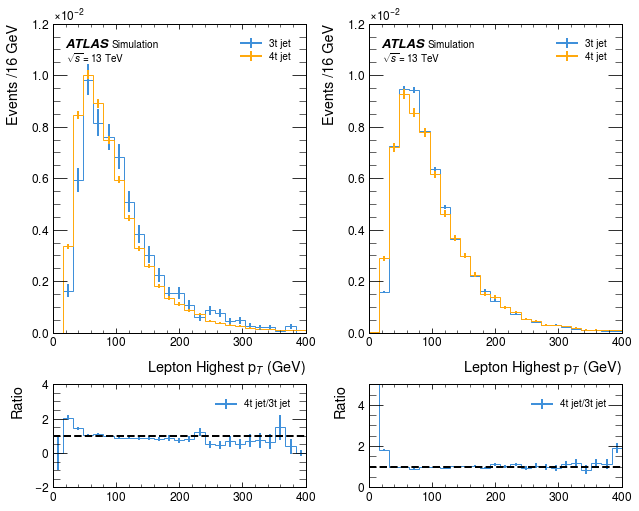

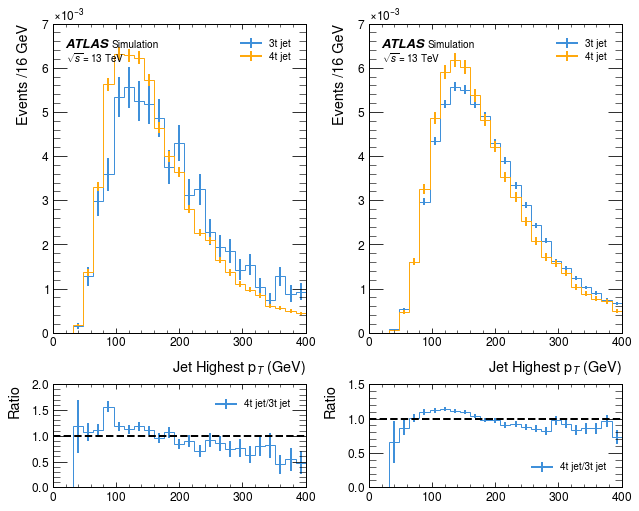

In [37]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_lepton_3t_1.pt, highest_pt_lepton_3t_2.pt], 25, ['3t jet','4t jet'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E3))
histogram([highest_pt_lepton_4t_1.pt, highest_pt_lepton_4t_2.pt], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,0.4E3))
ax[0,0].set_xlabel(r'Lepton Highest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Highest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_jet_3t_1.pt, highest_pt_jet_3t_2.pt], 25, ['3t jet','4t jet'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E3))
histogram([highest_pt_jet_4t_1.pt, highest_pt_jet_4t_2.pt], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,0.4E3))
ax[0,0].set_xlabel(r'Jet Highest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Jet Highest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

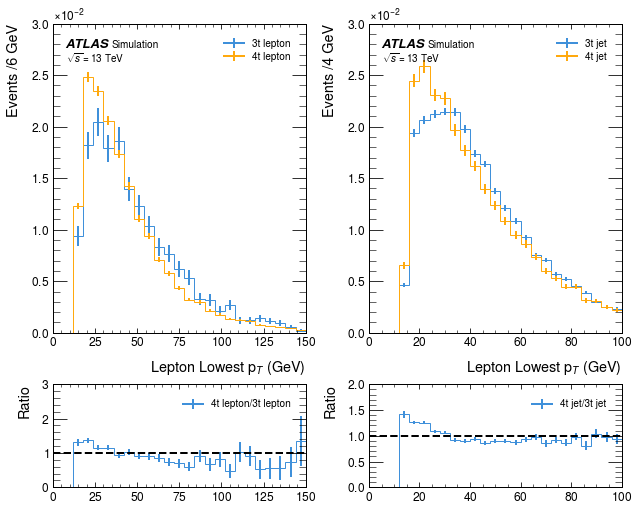

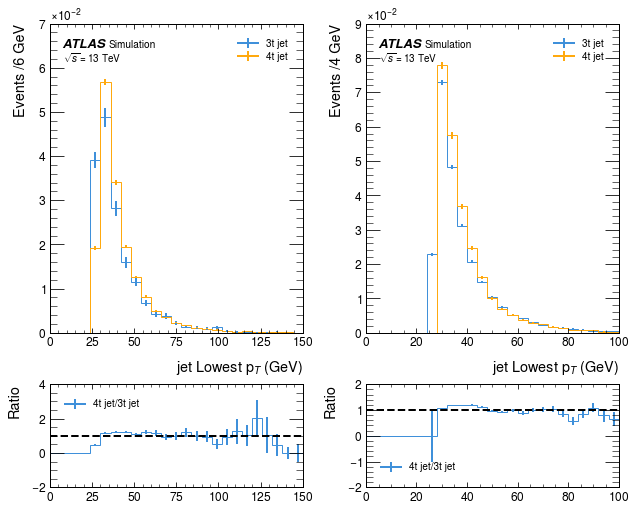

In [38]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_lepton_3t_1.pt, lowest_pt_lepton_3t_2.pt], 25, ['3t lepton','4t lepton'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1.5E2))
histogram([lowest_pt_lepton_4t_1.pt, lowest_pt_lepton_4t_2.pt], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E2))
ax[0,0].set_xlabel(r'Lepton Lowest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Lowest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_jet_3t_1.pt, lowest_pt_jet_3t_2.pt], 25, ['3t jet','4t jet'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1.5E2))
histogram([lowest_pt_jet_4t_1.pt, lowest_pt_jet_4t_2.pt], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E2))
ax[0,0].set_xlabel(r'jet Lowest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'jet Lowest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

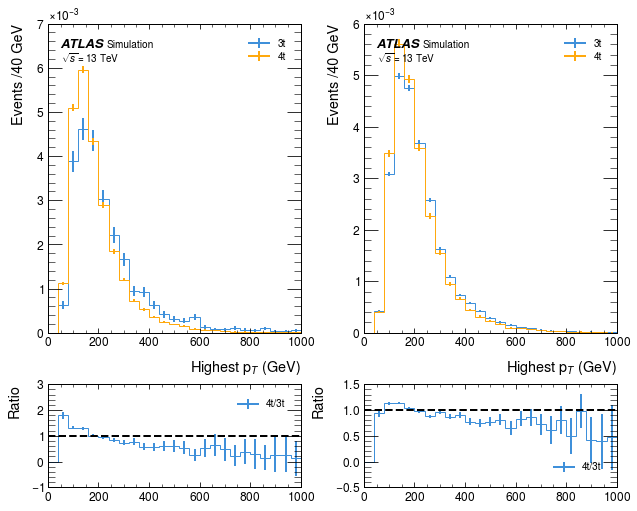

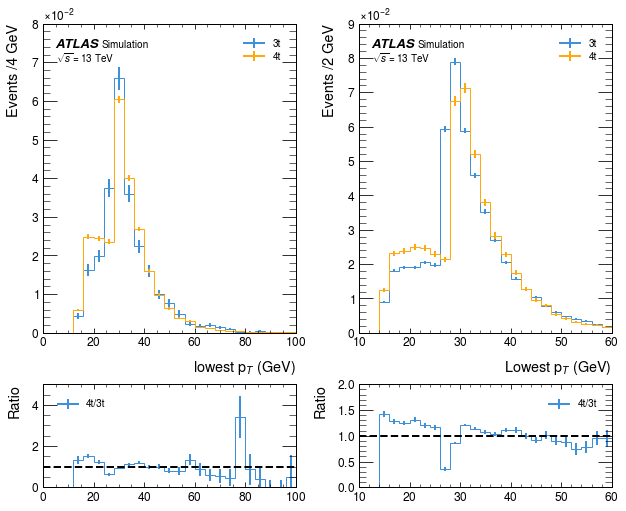

In [39]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_3t_1.pt, highest_pt_3t_2.pt], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1E3))
histogram([highest_pt_4t_1.pt, highest_pt_4t_2.pt], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1000))
ax[0,0].set_xlabel(r'Highest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Highest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_3t_1.pt, lowest_pt_3t_2.pt], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,100))
histogram([lowest_pt_4t_1.pt, lowest_pt_4t_2.pt], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(10,6E1))
ax[0,0].set_xlabel(r'lowest p$_T$ (GeV)')
ax[0,1].set_xlabel(r'Lowest p$_T$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

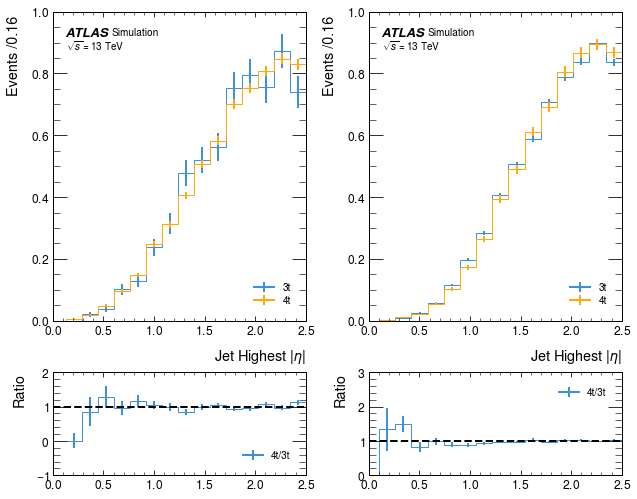

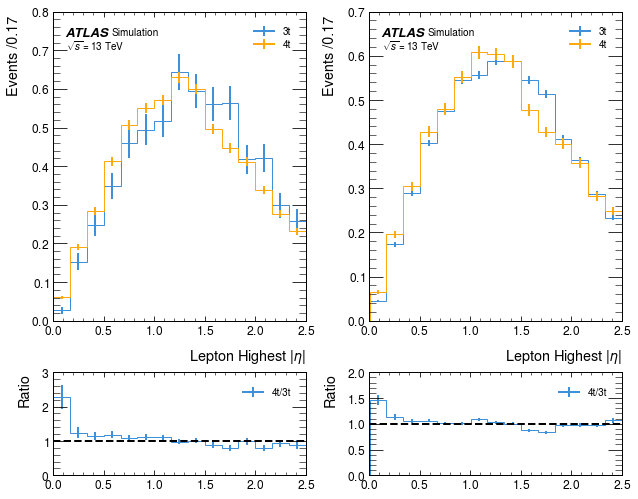

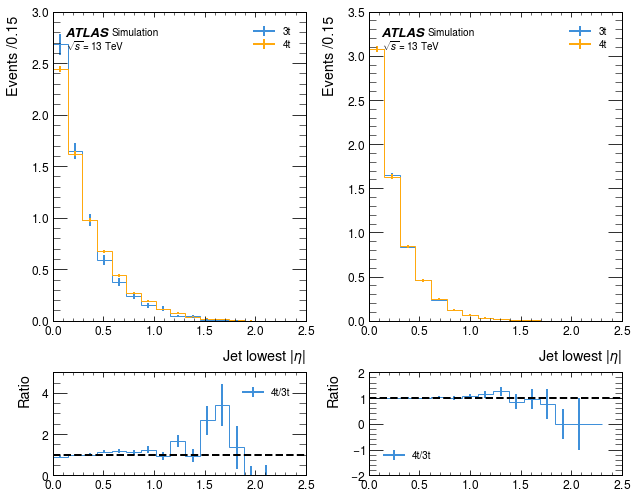

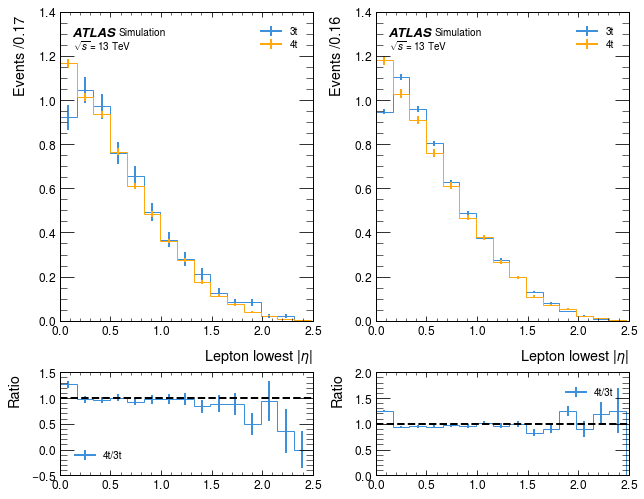

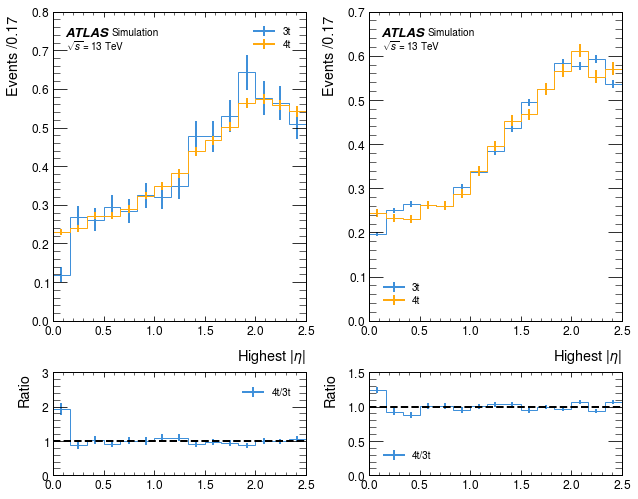

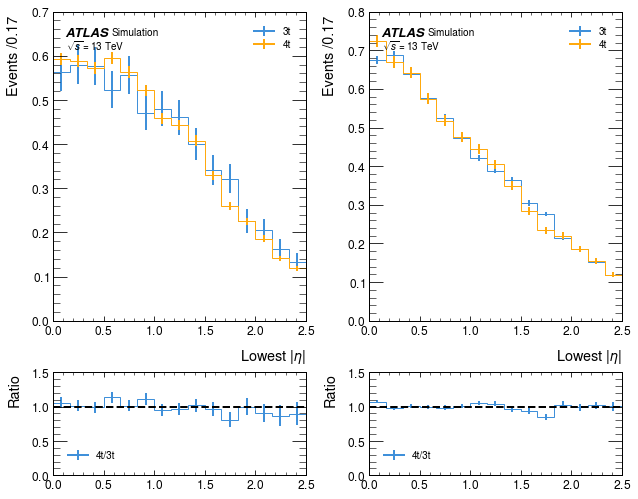

In [40]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(highest_eta_jet_3t_1.eta), np.abs(highest_eta_jet_3t_2.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(highest_eta_jet_4t_1.eta), np.abs(highest_eta_jet_4t_2.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Highest $|\eta|$')
ax[0,1].set_xlabel(r'Jet Highest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(highest_eta_lepton_3t_1.eta), np.abs(highest_eta_lepton_3t_2.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(highest_eta_lepton_4t_1.eta), np.abs(highest_eta_lepton_4t_2.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Lepton Highest $|\eta|$')
ax[0,1].set_xlabel(r'Lepton Highest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(lowest_eta_jet_3t_1.eta), np.abs(lowest_eta_jet_3t_2.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(lowest_eta_jet_4t_1.eta), np.abs(lowest_eta_jet_4t_2.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet lowest $|\eta|$')
ax[0,1].set_xlabel(r'Jet lowest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(lowest_eta_lepton_3t_1.eta), np.abs(lowest_eta_lepton_3t_2.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(lowest_eta_lepton_4t_1.eta), np.abs(lowest_eta_lepton_4t_2.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Lepton lowest $|\eta|$')
ax[0,1].set_xlabel(r'Lepton lowest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(highest_eta_3t_1.eta), np.abs(highest_eta_3t_2.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(highest_eta_4t_1.eta), np.abs(highest_eta_4t_2.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Highest $|\eta|$')
ax[0,1].set_xlabel(r'Highest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(lowest_eta_3t_1.eta), np.abs(lowest_eta_3t_2.eta)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(lowest_eta_4t_1.eta), np.abs(lowest_eta_4t_2.eta)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Lowest $|\eta|$')
ax[0,1].set_xlabel(r'Lowest $|\eta|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

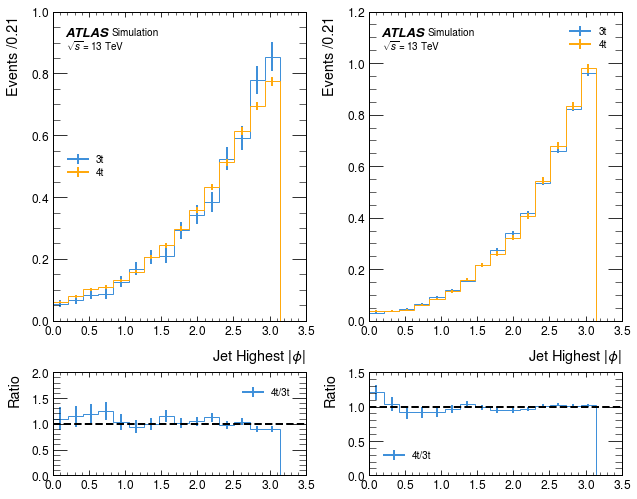

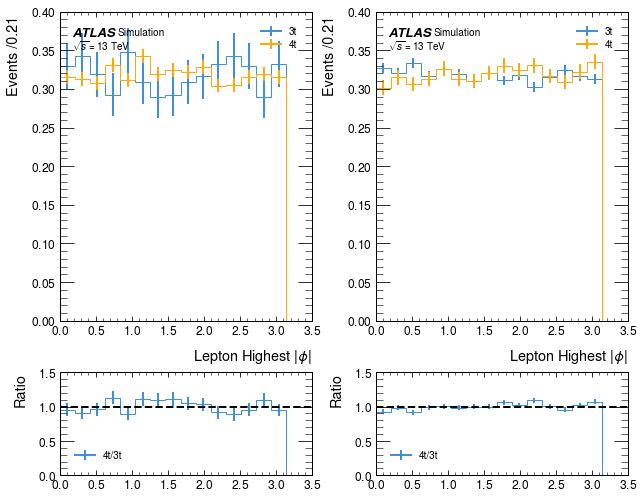

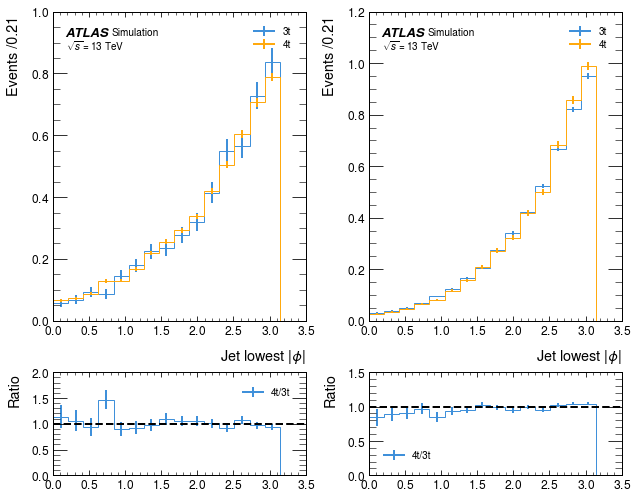

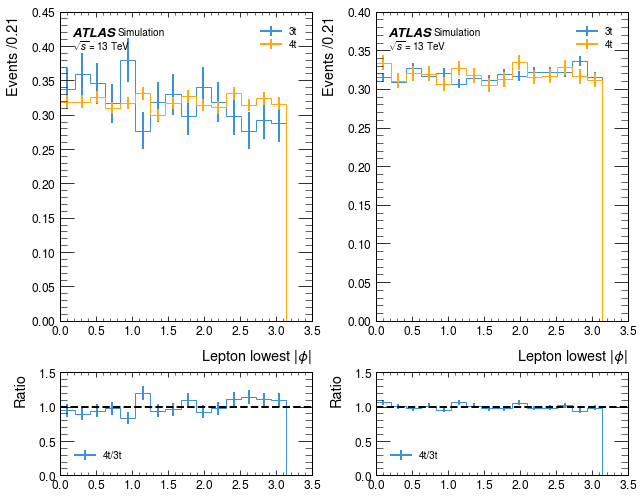

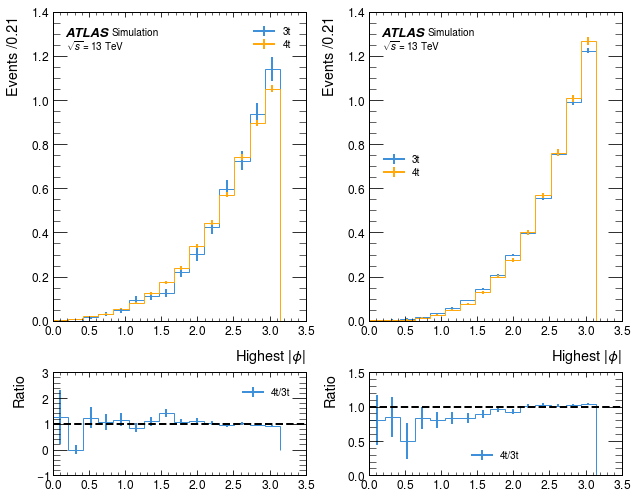

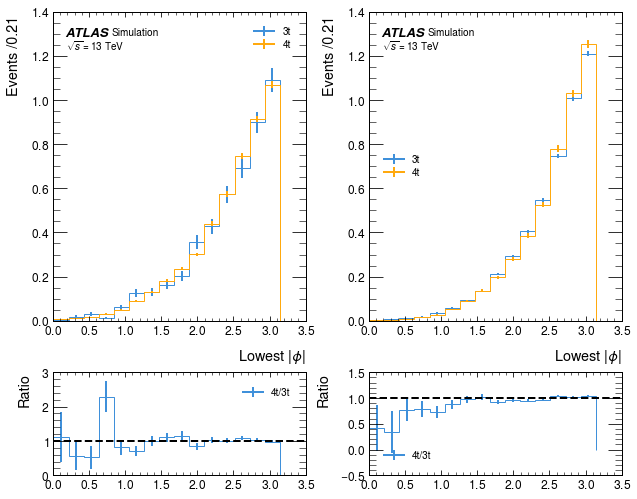

In [41]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(highest_phi_jet_3t_1.phi), np.abs(highest_phi_jet_3t_2.phi)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(highest_phi_jet_4t_1.phi), np.abs(highest_phi_jet_4t_2.phi)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet Highest $|\phi|$')
ax[0,1].set_xlabel(r'Jet Highest $|\phi|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(highest_phi_lepton_3t_1.phi), np.abs(highest_phi_lepton_3t_2.phi)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(highest_phi_lepton_4t_1.phi), np.abs(highest_phi_lepton_4t_2.phi)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Lepton Highest $|\phi|$')
ax[0,1].set_xlabel(r'Lepton Highest $|\phi|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(lowest_phi_jet_3t_1.phi), np.abs(lowest_phi_jet_3t_2.phi)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(lowest_phi_jet_4t_1.phi), np.abs(lowest_phi_jet_4t_2.phi)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet lowest $|\phi|$')
ax[0,1].set_xlabel(r'Jet lowest $|\phi|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(lowest_phi_lepton_3t_1.phi), np.abs(lowest_phi_lepton_3t_2.phi)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(lowest_phi_lepton_4t_1.phi), np.abs(lowest_phi_lepton_4t_2.phi)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Lepton lowest $|\phi|$')
ax[0,1].set_xlabel(r'Lepton lowest $|\phi|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(highest_phi_3t_1.phi), np.abs(highest_phi_3t_2.phi)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(highest_phi_4t_1.phi), np.abs(highest_phi_4t_2.phi)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Highest $|\phi|$')
ax[0,1].set_xlabel(r'Highest $|\phi|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(lowest_phi_3t_1.phi), np.abs(lowest_phi_3t_2.phi)], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([np.abs(lowest_phi_4t_1.phi), np.abs(lowest_phi_4t_2.phi)], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Lowest $|\phi|$')
ax[0,1].set_xlabel(r'Lowest $|\phi|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

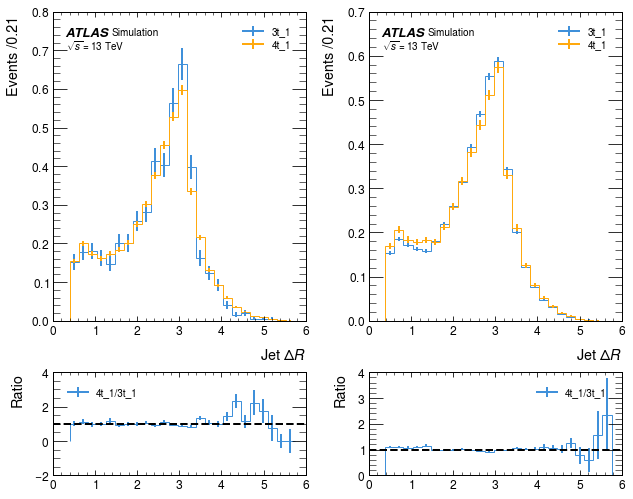

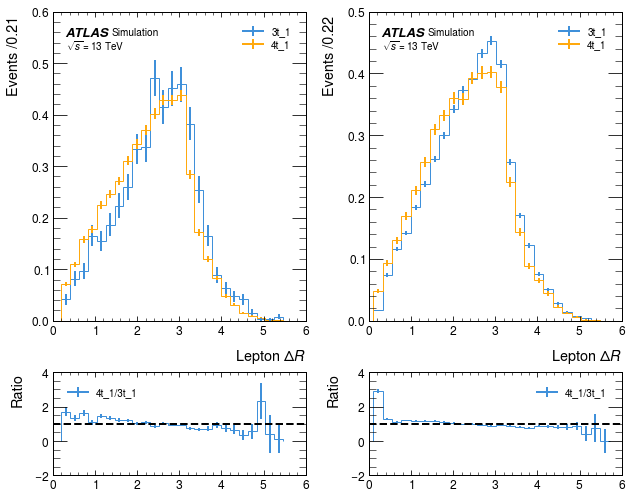

In [42]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_jet_3t_1.deltaR(second_highest_pt_jet_3t_1),highest_pt_jet_3t_2.deltaR(second_highest_pt_jet_3t_2)], 25, ['3t_1','4t_1'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([highest_pt_jet_4t_1.deltaR(second_highest_pt_jet_4t_1),highest_pt_jet_4t_2.deltaR(second_highest_pt_jet_4t_2)], 25, ['3t_1','4t_1'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Jet $\Delta R$')
ax[0,1].set_xlabel(r'Jet $\Delta R$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_lepton_3t_1.deltaR(second_highest_pt_lepton_3t_1),highest_pt_lepton_3t_2.deltaR(second_highest_pt_lepton_3t_2)], 25, ['3t_1','4t_1'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([highest_pt_lepton_4t_1.deltaR(second_highest_pt_lepton_4t_1),highest_pt_lepton_4t_2.deltaR(second_highest_pt_lepton_4t_2)], 25, ['3t_1','4t_1'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
ax[0,0].set_xlabel(r'Lepton $\Delta R$')
ax[0,1].set_xlabel(r'Lepton $\Delta R$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

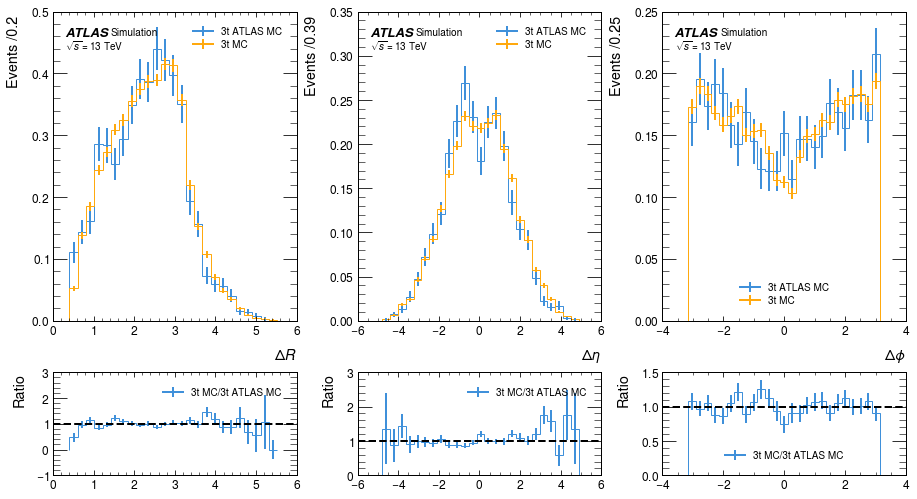

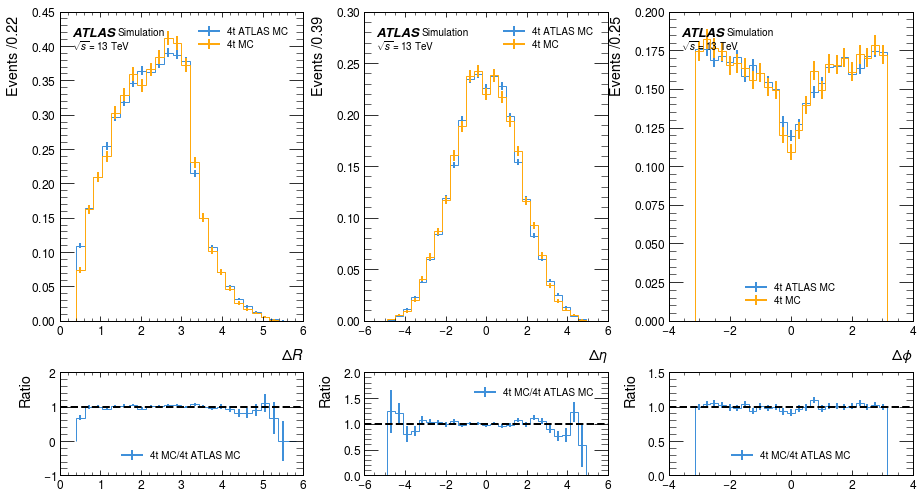

In [67]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([highest_pt_lepton_3t_1.deltaR(lowest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaR(lowest_pt_jet_3t_2)], 25, ['3t ATLAS MC', "3t MC"], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([highest_pt_lepton_3t_1.deltaeta(lowest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaeta(lowest_pt_jet_3t_2)], 25, ['3t ATLAS MC', "3t MC"], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([highest_pt_lepton_3t_1.deltaphi(lowest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaphi(lowest_pt_jet_3t_2)], 25, ['3t ATLAS MC', "3t MC"], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([highest_pt_lepton_4t_1.deltaR(lowest_pt_jet_4t_1),highest_pt_lepton_4t_2.deltaR(lowest_pt_jet_4t_2)], 25, ['4t ATLAS MC', "4t MC"], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([highest_pt_lepton_4t_1.deltaeta(lowest_pt_jet_4t_1),highest_pt_lepton_4t_2.deltaeta(lowest_pt_jet_4t_2)], 25, ['4t ATLAS MC', "4t MC"], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([highest_pt_lepton_4t_1.deltaphi(lowest_pt_jet_4t_1),highest_pt_lepton_4t_2.deltaphi(lowest_pt_jet_4t_2)], 25, ['4t ATLAS MC', "4t MC"], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

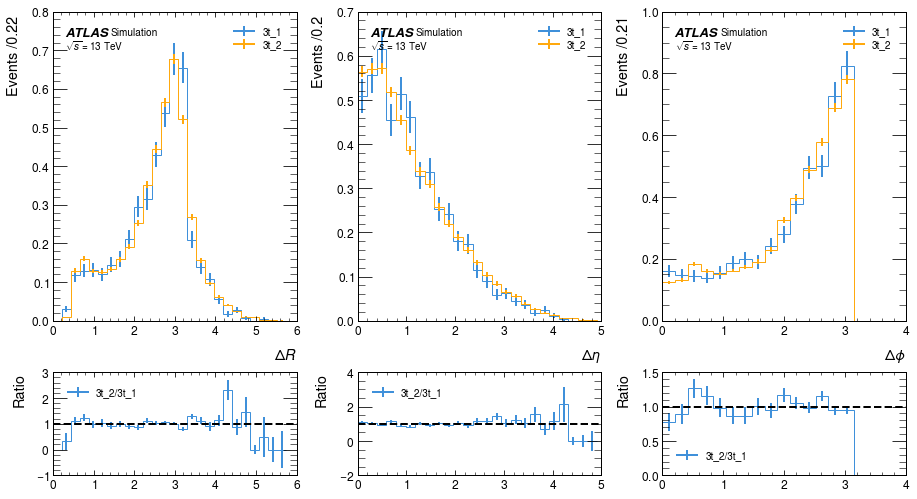

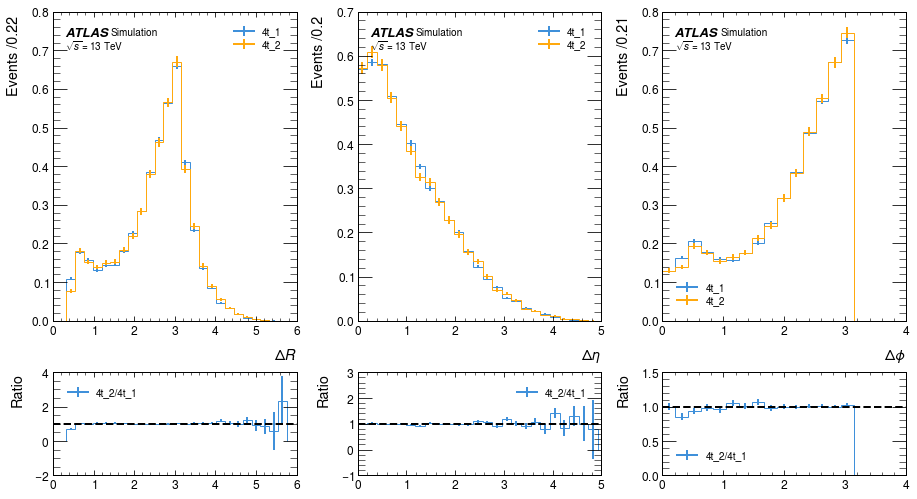

In [45]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_pt_3t_1, deltaR_highest_pt_3t_2], 25, ['3t_1','3t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_pt_3t_1, deltaeta_highest_pt_3t_2], 25, ['3t_1','3t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_pt_3t_1, deltaphi_highest_pt_3t_2], 15, ['3t_1','3t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_pt_4t_1, deltaR_highest_pt_4t_2], 25, ['4t_1','4t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_pt_4t_1, deltaeta_highest_pt_4t_2], 25, ['4t_1','4t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_pt_4t_1, deltaphi_highest_pt_4t_2], 15, ['4t_1','4t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

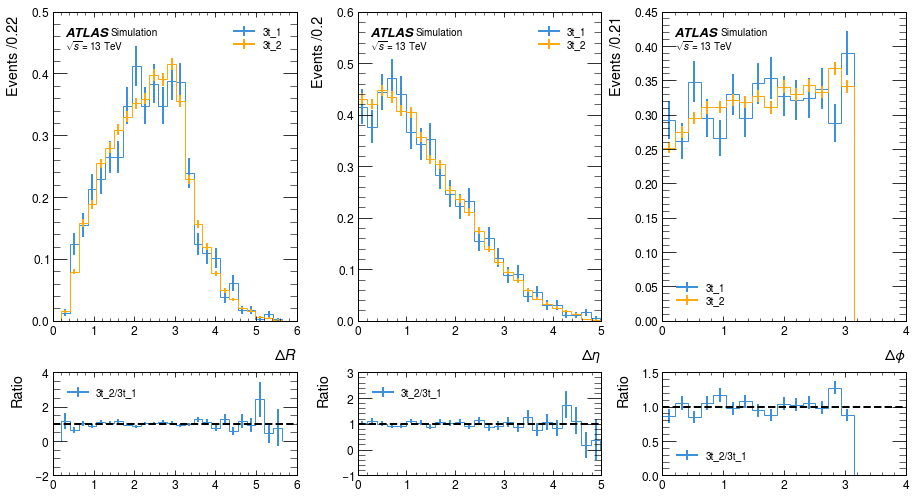

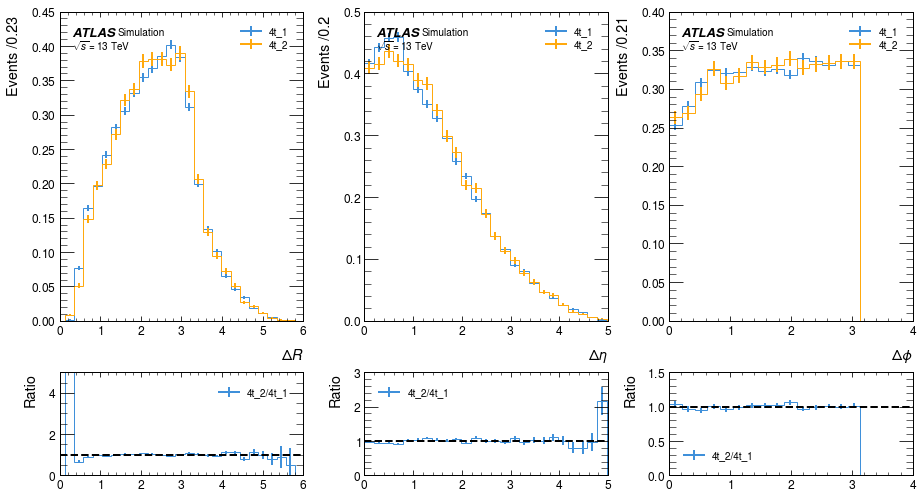

In [46]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_pt_3t_1, deltaR_lowest_pt_3t_2], 25, ['3t_1','3t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_pt_3t_1, deltaeta_lowest_pt_3t_2], 25, ['3t_1','3t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_pt_3t_1, deltaphi_lowest_pt_3t_2], 15, ['3t_1','3t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_pt_4t_1, deltaR_lowest_pt_4t_2], 25, ['4t_1','4t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_pt_4t_1, deltaeta_lowest_pt_4t_2], 25, ['4t_1','4t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_pt_4t_1, deltaphi_lowest_pt_4t_2], 15, ['4t_1','4t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

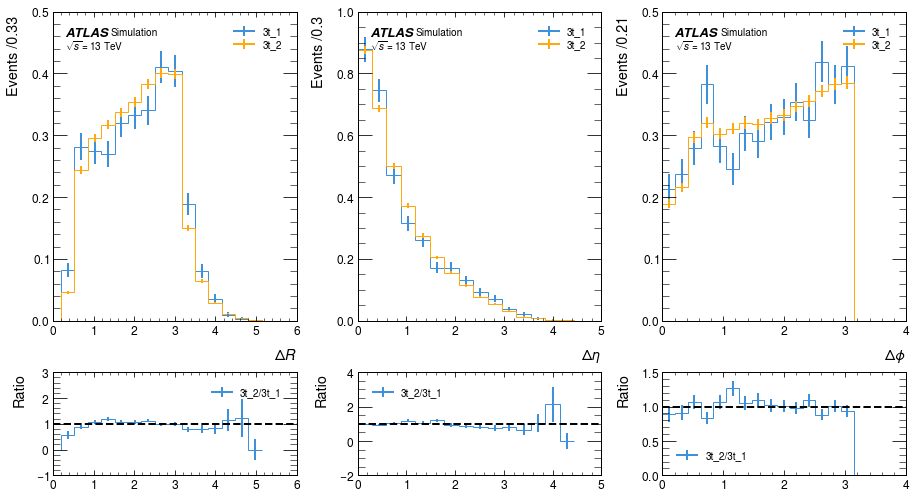

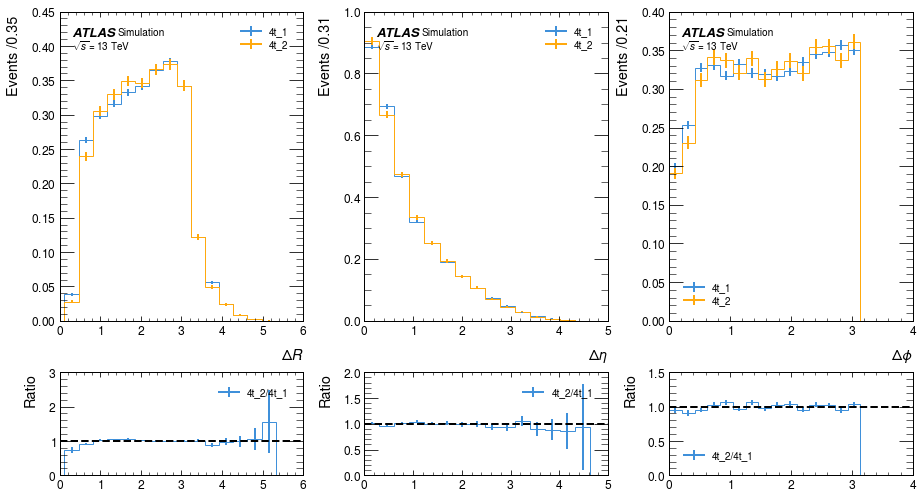

In [47]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_eta_3t_1, deltaR_highest_eta_3t_2], 15, ['3t_1','3t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_eta_3t_1, deltaeta_highest_eta_3t_2], 15, ['3t_1','3t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_eta_3t_1, deltaphi_highest_eta_3t_2], 15, ['3t_1','3t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_eta_4t_1, deltaR_highest_eta_4t_2], 15, ['4t_1','4t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_eta_4t_1, deltaeta_highest_eta_4t_2], 15, ['4t_1','4t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_eta_4t_1, deltaphi_highest_eta_4t_2], 15, ['4t_1','4t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

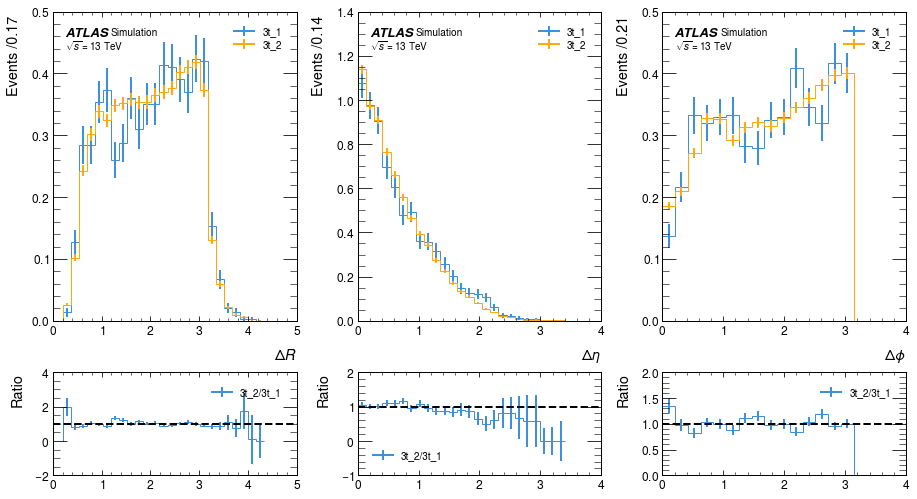

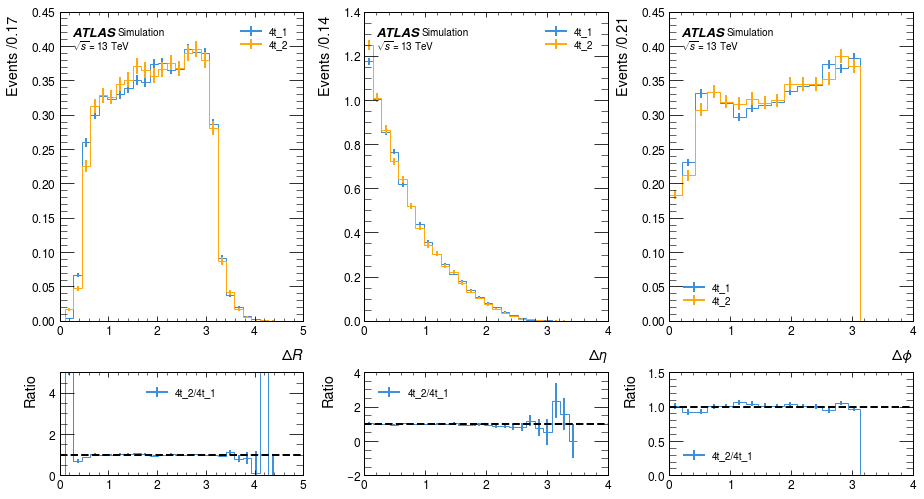

In [48]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_eta_3t_1, deltaR_lowest_eta_3t_2], 25, ['3t_1','3t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_eta_3t_1, deltaeta_lowest_eta_3t_2], 25, ['3t_1','3t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_eta_3t_1, deltaphi_lowest_eta_3t_2], 15, ['3t_1','3t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_eta_4t_1, deltaR_lowest_eta_4t_2], 25, ['4t_1','4t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_eta_4t_1, deltaeta_lowest_eta_4t_2], 25, ['4t_1','4t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_eta_4t_1, deltaphi_lowest_eta_4t_2], 15, ['4t_1','4t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

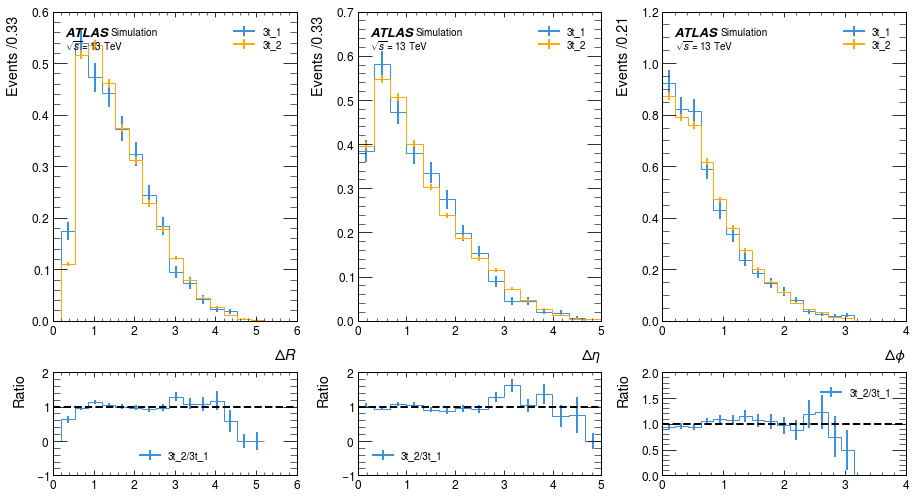

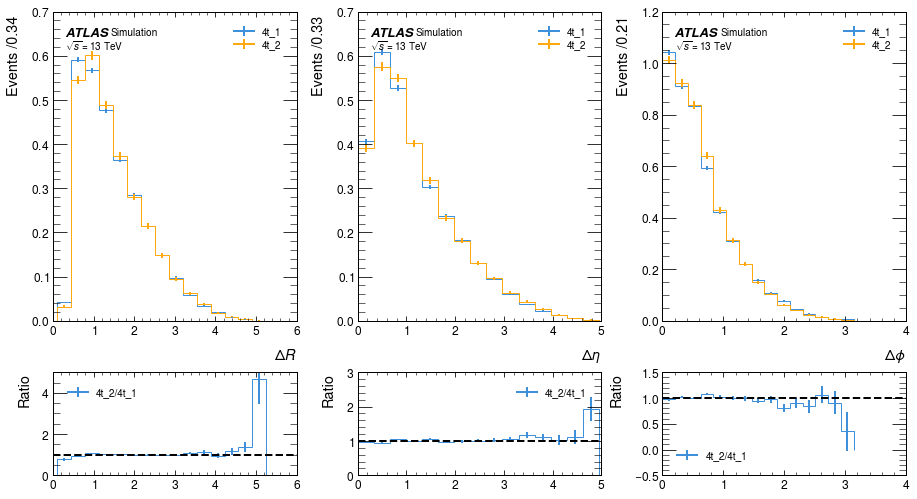

In [49]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_phi_3t_1, deltaR_highest_phi_3t_2], 15, ['3t_1','3t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_phi_3t_1, deltaeta_highest_phi_3t_2], 15, ['3t_1','3t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_phi_3t_1, deltaphi_highest_phi_3t_2], 15, ['3t_1','3t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_phi_4t_1, deltaR_highest_phi_4t_2], 15, ['4t_1','4t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_highest_phi_4t_1, deltaeta_highest_phi_4t_2], 15, ['4t_1','4t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_highest_phi_4t_1, deltaphi_highest_phi_4t_2], 15, ['4t_1','4t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

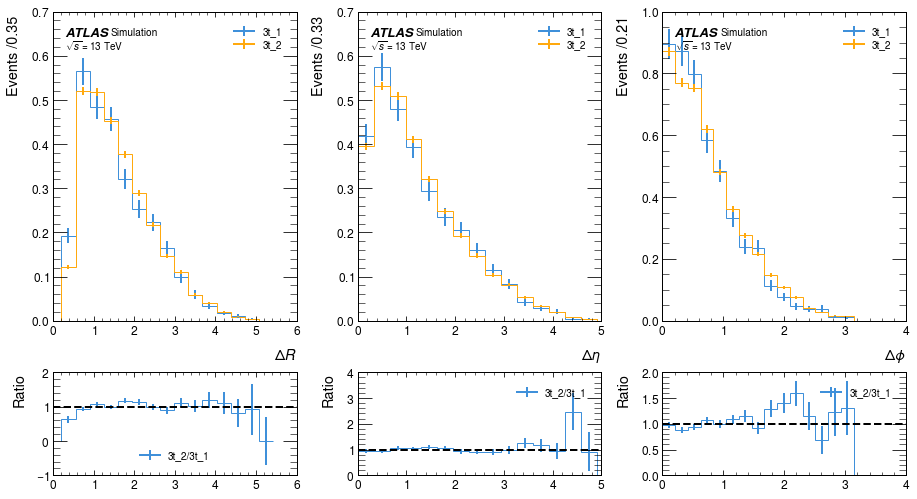

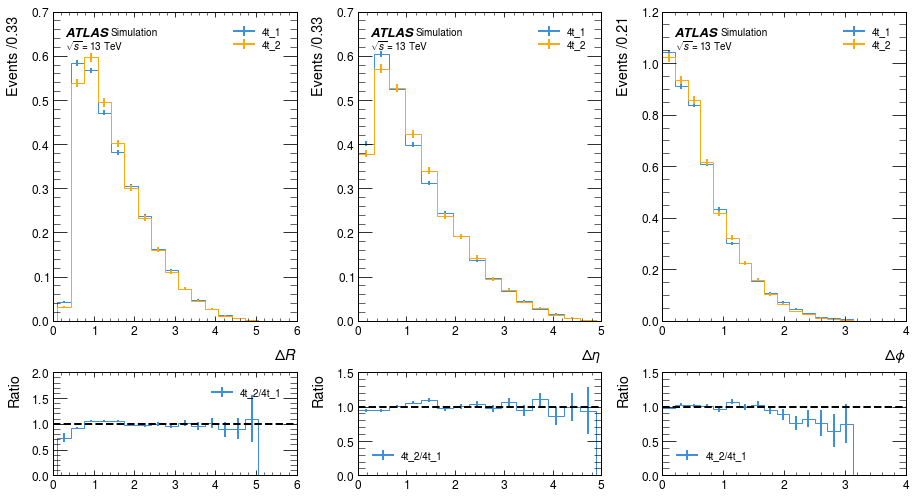

In [50]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_phi_3t_1, deltaR_lowest_phi_3t_2], 15, ['3t_1','3t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_phi_3t_1, deltaeta_lowest_phi_3t_2], 15, ['3t_1','3t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_phi_3t_1, deltaphi_lowest_phi_3t_2], 15, ['3t_1','3t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_phi_4t_1, deltaR_lowest_phi_4t_2], 15, ['4t_1','4t_2'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
histogram([deltaeta_lowest_phi_4t_1, deltaeta_lowest_phi_4t_2], 15, ['4t_1','4t_2'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([deltaphi_lowest_phi_4t_1, deltaphi_lowest_phi_4t_2], 15, ['4t_1','4t_2'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='')
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

In [ ]:
highest_2LSS_pt_jet_4t_1 = jets_2LSS_4t_1[:,0]
highest_2LSS_pt_lepton_4t_1 = leptons_2LSS_4t_1[:,0]
highest_2LSS_pt_4t_1 = np.maximum(highest_2LSS_pt_jet_4t_1.pt, highest_2LSS_pt_lepton_4t_1.pt)

highest_3L_pt_jet_4t_1 = jets_3L_4t_1[:,0]
highest_3L_pt_lepton_4t_1 = leptons_3L_4t_1[:,0]
highest_3L_pt_4t_1 = np.maximum(highest_3L_pt_jet_4t_1.pt, highest_3L_pt_lepton_4t_1.pt)

lowest_2LSS_pt_jet_4t_1 = jets_2LSS_4t_1[:,-1]
lowest_2LSS_pt_lepton_4t_1 = leptons_2LSS_4t_1[:,-1]
lowest_2LSS_pt_4t_1 = np.minimum(lowest_2LSS_pt_jet_4t_1.pt, lowest_2LSS_pt_lepton_4t_1.pt)

lowest_3L_pt_jet_4t_1 = jets_3L_4t_1[:,-1]
lowest_3L_pt_lepton_4t_1 = leptons_3L_4t_1[:,-1]
lowest_3L_pt_4t_1 = np.minimum(lowest_3L_pt_jet_4t_1.pt, lowest_3L_pt_lepton_4t_1.pt)

second_highest_2LSS_pt_jet_4t_1 = jets_2LSS_4t_1[:,1]
second_highest_3L_pt_jet_4t_1 = jets_3L_4t_1[:,1]
middle_3L_pt_lepton_4t_1 = leptons_3L_4t_1[:,1]

highest_2LSS_pt_jet_3t_1 = jets_2LSS_3t_1[:,0]
highest_2LSS_pt_lepton_3t_1 = leptons_2LSS_3t_1[:,0]
highest_2LSS_pt_3t_1 = np.maximum(highest_2LSS_pt_jet_3t_1.pt, highest_2LSS_pt_lepton_3t_1.pt)

highest_3L_pt_jet_3t_1 = jets_3L_3t_1[:,0]
highest_3L_pt_lepton_3t_1 = leptons_3L_3t_1[:,0]
highest_3L_pt_3t_1 = np.maximum(highest_3L_pt_jet_3t_1.pt, highest_3L_pt_lepton_3t_1.pt)

lowest_2LSS_pt_jet_3t_1 = jets_2LSS_3t_1[:,-1]
lowest_2LSS_pt_lepton_3t_1 = leptons_2LSS_3t_1[:,-1]
lowest_2LSS_pt_3t_1 = np.minimum(lowest_2LSS_pt_jet_3t_1.pt, lowest_2LSS_pt_lepton_3t_1.pt)

lowest_3L_pt_jet_3t_1 = jets_3L_3t_1[:,-1]
lowest_3L_pt_lepton_3t_1 = leptons_3L_3t_1[:,-1]
lowest_3L_pt_3t_1 = np.minimum(lowest_3L_pt_jet_3t_1.pt, lowest_3L_pt_lepton_3t_1.pt)

second_highest_2LSS_pt_jet_3t_1 = jets_2LSS_3t_1[:,1]
second_highest_3L_pt_jet_3t_1 = jets_3L_3t_1[:,1]
middle_3L_pt_lepton_3t_1 = leptons_3L_3t_1[:,1]

highest_2LSS_pt_jet_4t_2 = jets_2LSS_4t_2[:,0]
highest_2LSS_pt_lepton_4t_2 = leptons_2LSS_4t_2[:,0]
highest_2LSS_pt_4t_2 = np.maximum(highest_2LSS_pt_jet_4t_2.pt, highest_2LSS_pt_lepton_4t_2.pt)

highest_3L_pt_jet_4t_2 = jets_3L_4t_2[:,0]
highest_3L_pt_lepton_4t_2 = leptons_3L_4t_2[:,0]
highest_3L_pt_4t_2 = np.maximum(highest_3L_pt_jet_4t_2.pt, highest_3L_pt_lepton_4t_2.pt)

lowest_2LSS_pt_jet_4t_2 = jets_2LSS_4t_2[:,-1]
lowest_2LSS_pt_lepton_4t_2 = leptons_2LSS_4t_2[:,-1]
lowest_2LSS_pt_4t_2 = np.minimum(lowest_2LSS_pt_jet_4t_2.pt, lowest_2LSS_pt_lepton_4t_2.pt)

lowest_3L_pt_jet_4t_2 = jets_3L_4t_2[:,-1]
lowest_3L_pt_lepton_4t_2 = leptons_3L_4t_2[:,-1]
lowest_3L_pt_4t_2 = np.minimum(lowest_3L_pt_jet_4t_2.pt, lowest_3L_pt_lepton_4t_2.pt)

second_highest_2LSS_pt_jet_4t_2 = jets_2LSS_4t_2[:,1]
second_highest_3L_pt_jet_4t_2 = jets_3L_4t_2[:,1]
middle_3L_pt_lepton_4t_2 = leptons_3L_4t_2[:,1]

highest_2LSS_pt_jet_3t_2 = jets_2LSS_3t_2[:,0]
highest_2LSS_pt_lepton_3t_2 = leptons_2LSS_3t_2[:,0]
highest_2LSS_pt_3t_2 = np.maximum(highest_2LSS_pt_jet_3t_2.pt, highest_2LSS_pt_lepton_3t_2.pt)

highest_3L_pt_jet_3t_2 = jets_3L_3t_2[:,0]
highest_3L_pt_lepton_3t_2 = leptons_3L_3t_2[:,0]
highest_3L_pt_3t_2 = np.maximum(highest_3L_pt_jet_3t_2.pt, highest_3L_pt_lepton_3t_2.pt)

lowest_2LSS_pt_jet_3t_2 = jets_2LSS_3t_2[:,-1]
lowest_2LSS_pt_lepton_3t_2 = leptons_2LSS_3t_2[:,-1]
lowest_2LSS_pt_3t_2 = np.minimum(lowest_2LSS_pt_jet_3t_2.pt, lowest_2LSS_pt_lepton_3t_2.pt)

lowest_3L_pt_jet_3t_2 = jets_3L_3t_2[:,-1]
lowest_3L_pt_lepton_3t_2 = leptons_3L_3t_2[:,-1]
lowest_3L_pt_3t_2 = np.minimum(lowest_3L_pt_jet_3t_2.pt, lowest_3L_pt_lepton_3t_2.pt)

second_highest_2LSS_pt_jet_3t_2 = jets_2LSS_3t_2[:,1]
second_highest_3L_pt_jet_3t_2 = jets_3L_3t_2[:,1]
middle_3L_pt_lepton_3t_2 = leptons_3L_3t_2[:,1]

/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:21: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:22: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(

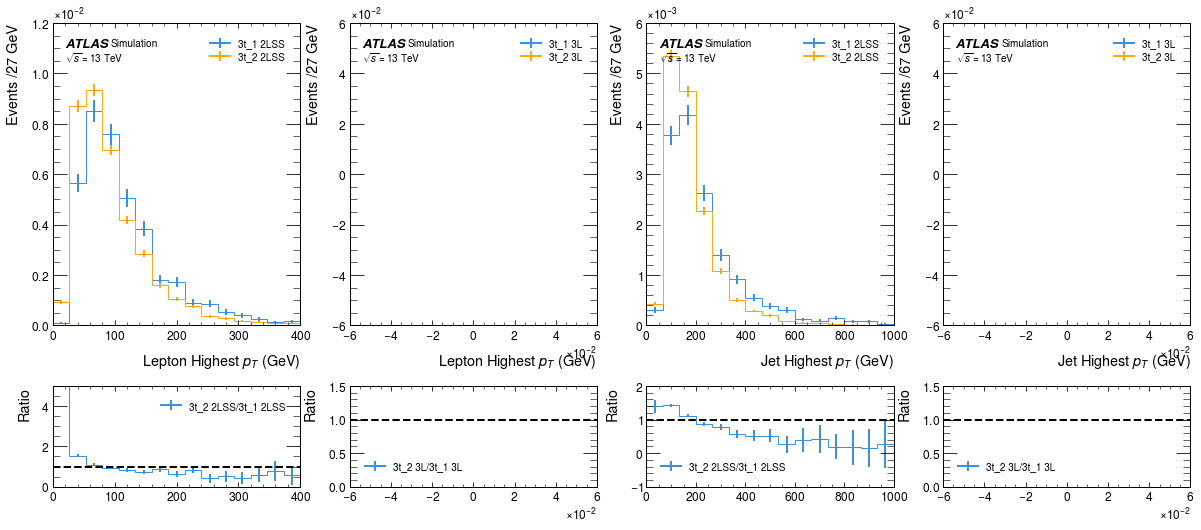

/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:21: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:22: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(

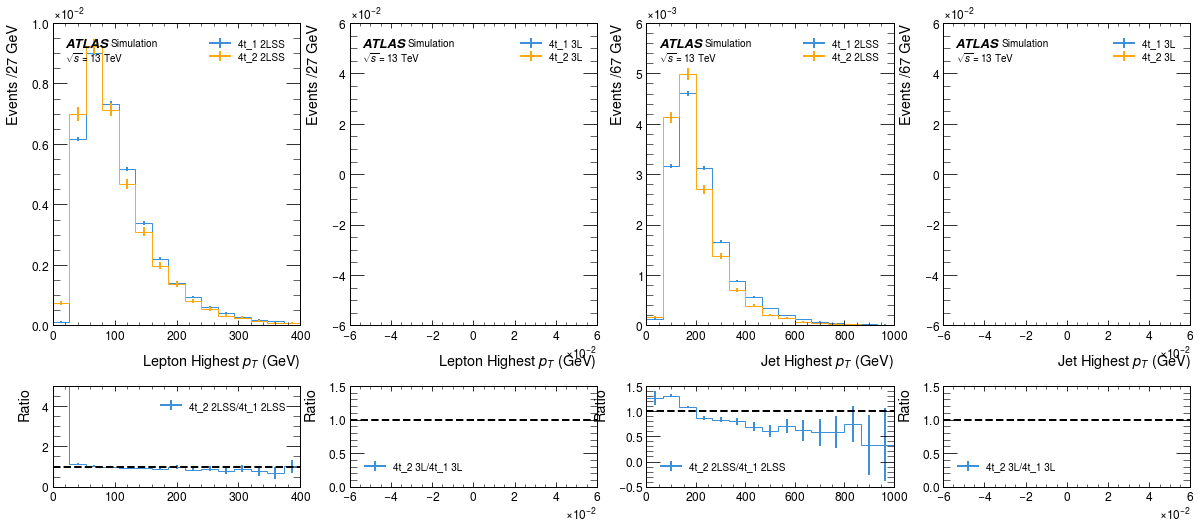

In [ ]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([highest_2LSS_pt_lepton_3t_1.pt, highest_2LSS_pt_lepton_3t_2.pt], 15, ['3t_1 2LSS','3t_2 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E3))
histogram([highest_3L_pt_lepton_3t_1.pt, highest_3L_pt_lepton_3t_2.pt], 15, ['3t_1 3L', '3t_2 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,0.4E3))
histogram([highest_2LSS_pt_jet_3t_1.pt, highest_2LSS_pt_jet_3t_2.pt], 15, ['3t_1 2LSS', '3t_2 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E3))
histogram([highest_3L_pt_jet_3t_1.pt, highest_3L_pt_jet_3t_2.pt], 15, ['3t_1 3L', '3t_2 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E3))
ax[0,0].set_xlabel(r'Lepton Highest $p_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Highest $p_T$ (GeV)')
ax[0,2].set_xlabel(r'Jet Highest $p_T$ (GeV)')
ax[0,3].set_xlabel(r'Jet Highest $p_T$ (GeV)')
plt.subplots_adjust(hspace=0.3)
plt.show()

fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([highest_2LSS_pt_lepton_4t_1.pt, highest_2LSS_pt_lepton_4t_2.pt], 15, ['4t_1 2LSS','4t_2 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E3))
histogram([highest_3L_pt_lepton_4t_1.pt, highest_3L_pt_lepton_4t_2.pt], 15, ['4t_1 3L', '4t_2 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,0.4E3))
histogram([highest_2LSS_pt_jet_4t_1.pt, highest_2LSS_pt_jet_4t_2.pt], 15, ['4t_1 2LSS', '4t_2 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E3))
histogram([highest_3L_pt_jet_4t_1.pt, highest_3L_pt_jet_4t_2.pt], 15, ['4t_1 3L', '4t_2 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E3))
ax[0,0].set_xlabel(r'Lepton Highest $p_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Highest $p_T$ (GeV)')
ax[0,2].set_xlabel(r'Jet Highest $p_T$ (GeV)')
ax[0,3].set_xlabel(r'Jet Highest $p_T$ (GeV)')
plt.subplots_adjust(hspace=0.3)
plt.show()

/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:21: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:22: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(

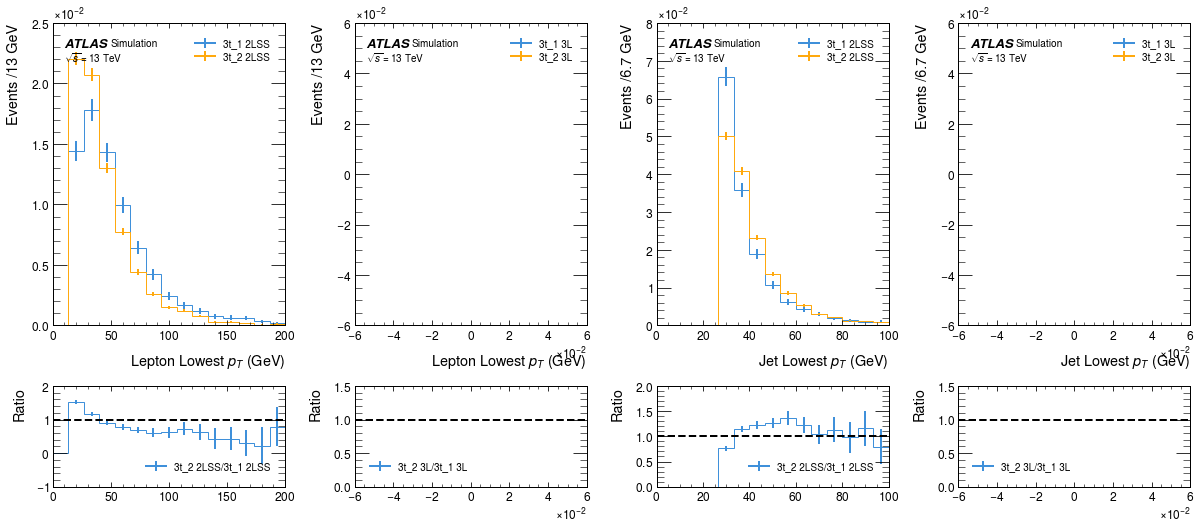

/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:21: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:22: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_21753/2208570116.py:19: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(

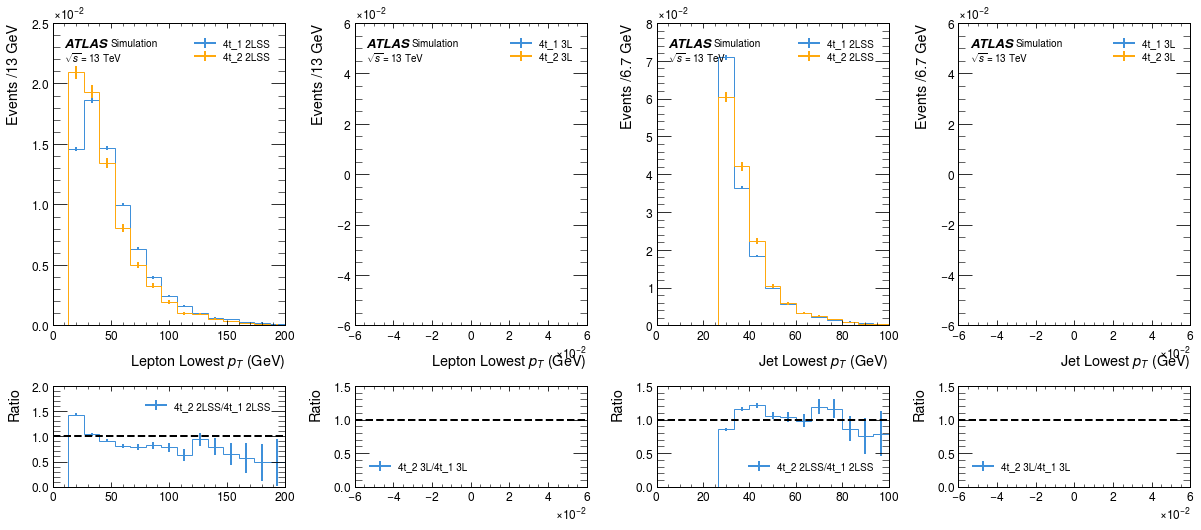

In [ ]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([lowest_2LSS_pt_lepton_3t_1.pt, lowest_2LSS_pt_lepton_3t_2.pt], 15, ['3t_1 2LSS','3t_2 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,2E2))
histogram([lowest_3L_pt_lepton_3t_1.pt, lowest_3L_pt_lepton_3t_2.pt], 15, ['3t_1 3L', '3t_2 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,2E2))
histogram([lowest_2LSS_pt_jet_3t_1.pt, lowest_2LSS_pt_jet_3t_2.pt], 15, ['3t_1 2LSS', '3t_2 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E2))
histogram([lowest_3L_pt_jet_3t_1.pt, lowest_3L_pt_jet_3t_2.pt], 15, ['3t_1 3L', '3t_2 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E2))
ax[0,0].set_xlabel(r'Lepton Lowest $p_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Lowest $p_T$ (GeV)')
ax[0,2].set_xlabel(r'Jet Lowest $p_T$ (GeV)')
ax[0,3].set_xlabel(r'Jet Lowest $p_T$ (GeV)')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([lowest_2LSS_pt_lepton_4t_1.pt, lowest_2LSS_pt_lepton_4t_2.pt], 15, ['4t_1 2LSS','4t_2 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,2E2))
histogram([lowest_3L_pt_lepton_4t_1.pt, lowest_3L_pt_lepton_4t_2.pt], 15, ['4t_1 3L', '4t_2 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,2E2))
histogram([lowest_2LSS_pt_jet_4t_1.pt, lowest_2LSS_pt_jet_4t_2.pt], 15, ['4t_1 2LSS', '4t_2 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E2))
histogram([lowest_3L_pt_jet_4t_1.pt, lowest_3L_pt_jet_4t_2.pt], 15, ['4t_1 3L', '4t_2 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E2))
ax[0,0].set_xlabel(r'Lepton Lowest $p_T$ (GeV)')
ax[0,1].set_xlabel(r'Lepton Lowest $p_T$ (GeV)')
ax[0,2].set_xlabel(r'Jet Lowest $p_T$ (GeV)')
ax[0,3].set_xlabel(r'Jet Lowest $p_T$ (GeV)')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

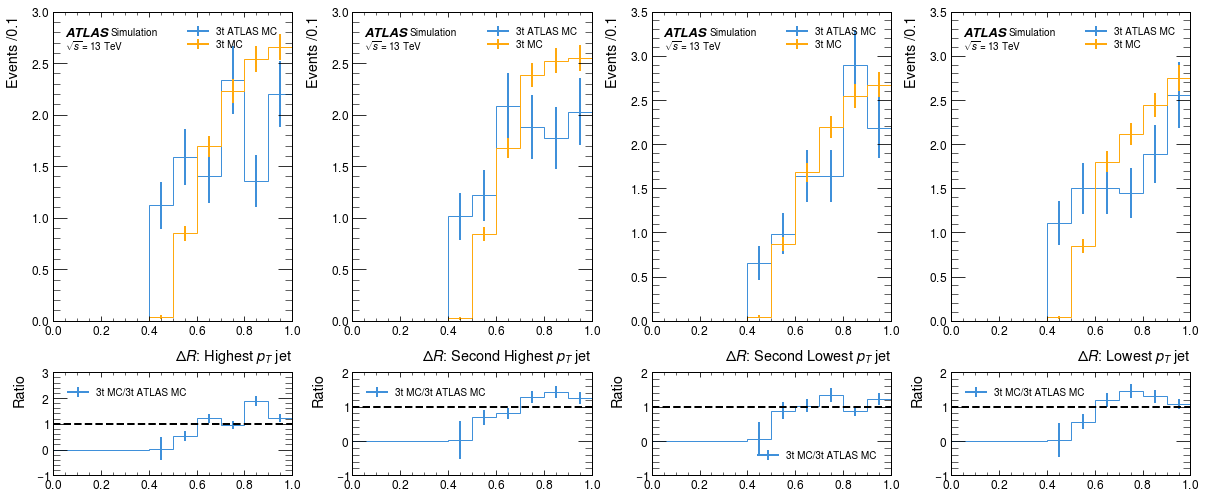

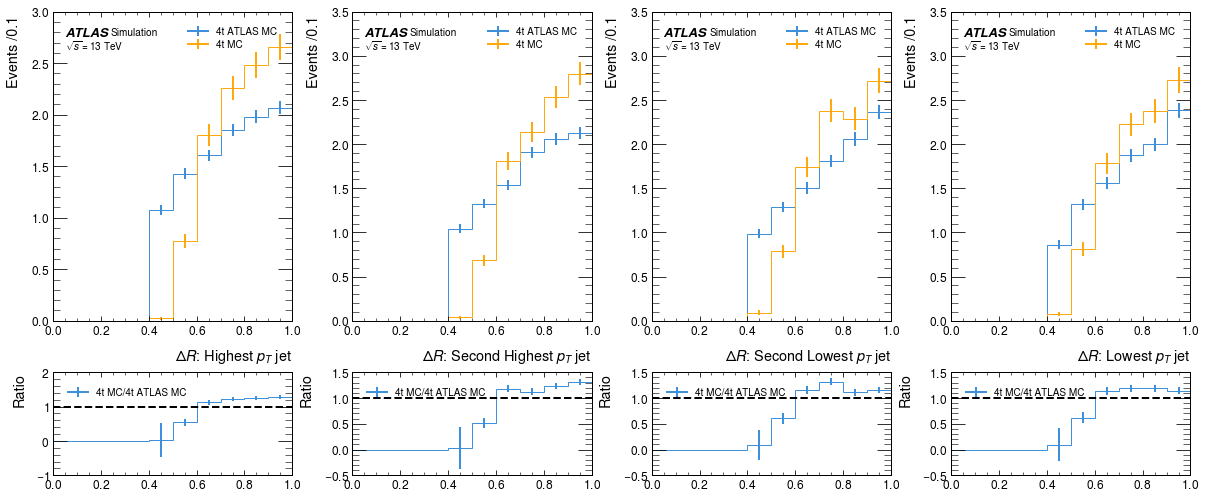

In [69]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([lowest_pt_lepton_3t_1.deltaR(highest_pt_jet_3t_1),lowest_pt_lepton_3t_2.deltaR(highest_pt_jet_3t_2)], 10, ['3t ATLAS MC','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,1))
histogram([lowest_pt_lepton_3t_1.deltaR(second_highest_pt_jet_3t_1),lowest_pt_lepton_3t_2.deltaR(second_highest_pt_jet_3t_2)], 10, ['3t ATLAS MC','3t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,1))
histogram([lowest_pt_lepton_3t_1.deltaR(second_lowest_pt_jet_3t_1),lowest_pt_lepton_3t_2.deltaR(second_lowest_pt_jet_3t_2)], 10, ['3t ATLAS MC','3t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='', set_range=(0,1))
histogram([lowest_pt_lepton_3t_1.deltaR(lowest_pt_jet_3t_1),lowest_pt_lepton_3t_2.deltaR(lowest_pt_jet_3t_2)], 10, ['3t ATLAS MC','3t MC'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, x_units='', set_range=(0,1))
ax[0,0].set_xlabel(r'$\Delta R$: Highest $p_T$ jet')
ax[0,1].set_xlabel(r'$\Delta R$: Second Highest $p_T$ jet')
ax[0,2].set_xlabel(r'$\Delta R$: Second Lowest $p_T$ jet')
ax[0,3].set_xlabel(r'$\Delta R$: Lowest $p_T$ jet')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([lowest_pt_lepton_4t_1.deltaR(highest_pt_jet_4t_1),lowest_pt_lepton_4t_2.deltaR(highest_pt_jet_4t_2)], 10, ['4t ATLAS MC','4t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,1))
histogram([lowest_pt_lepton_4t_1.deltaR(second_highest_pt_jet_4t_1),lowest_pt_lepton_4t_2.deltaR(second_highest_pt_jet_4t_2)], 10, ['4t ATLAS MC','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,1))
histogram([lowest_pt_lepton_4t_1.deltaR(second_lowest_pt_jet_4t_1),lowest_pt_lepton_4t_2.deltaR(second_lowest_pt_jet_4t_2)], 10, ['4t ATLAS MC','4t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='', set_range=(0,1))
histogram([lowest_pt_lepton_4t_1.deltaR(lowest_pt_jet_4t_1),lowest_pt_lepton_4t_2.deltaR(lowest_pt_jet_4t_2)], 10, ['4t ATLAS MC','4t MC'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, x_units='', set_range=(0,1))
ax[0,0].set_xlabel(r'$\Delta R$: Highest $p_T$ jet')
ax[0,1].set_xlabel(r'$\Delta R$: Second Highest $p_T$ jet')
ax[0,2].set_xlabel(r'$\Delta R$: Second Lowest $p_T$ jet')
ax[0,3].set_xlabel(r'$\Delta R$: Lowest $p_T$ jet')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

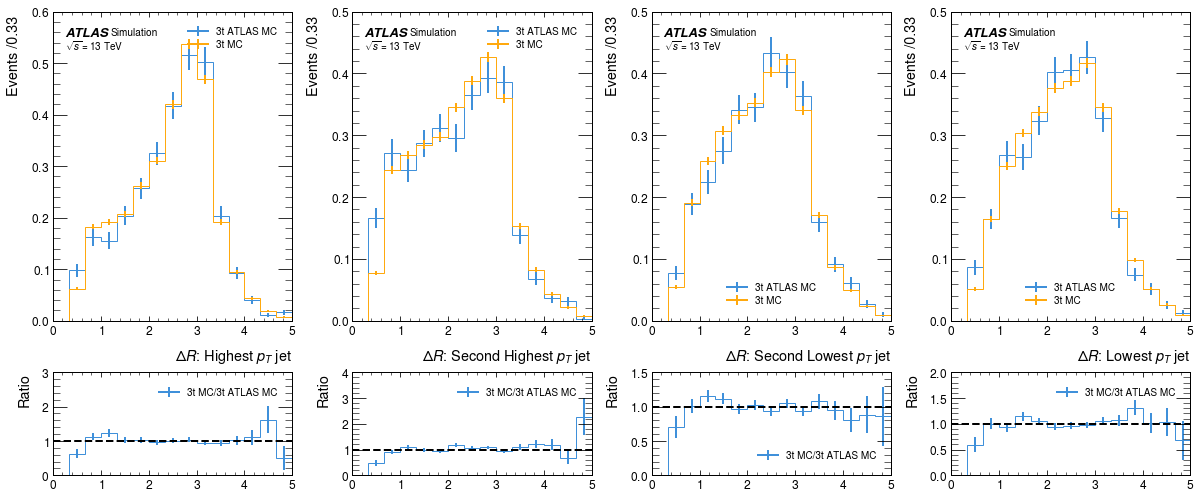

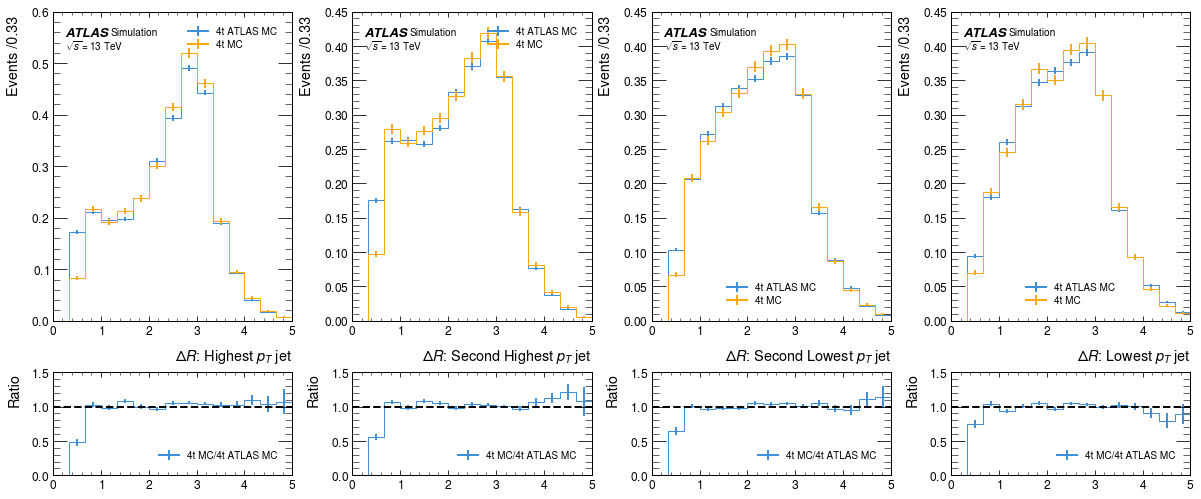

In [70]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([highest_pt_lepton_3t_1.deltaR(highest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaR(highest_pt_jet_3t_2)], 15, ['3t ATLAS MC','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,5))
histogram([highest_pt_lepton_3t_1.deltaR(second_highest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaR(second_highest_pt_jet_3t_2)], 15, ['3t ATLAS MC','3t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,5))
histogram([highest_pt_lepton_3t_1.deltaR(second_lowest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaR(second_lowest_pt_jet_3t_2)], 15, ['3t ATLAS MC','3t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='', set_range=(0,5))
histogram([highest_pt_lepton_3t_1.deltaR(lowest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaR(lowest_pt_jet_3t_2)], 15, ['3t ATLAS MC','3t MC'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, x_units='', set_range=(0,5))
ax[0,0].set_xlabel(r'$\Delta R$: Highest $p_T$ jet')
ax[0,1].set_xlabel(r'$\Delta R$: Second Highest $p_T$ jet')
ax[0,2].set_xlabel(r'$\Delta R$: Second Lowest $p_T$ jet')
ax[0,3].set_xlabel(r'$\Delta R$: Lowest $p_T$ jet')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([highest_pt_lepton_4t_1.deltaR(highest_pt_jet_4t_1),highest_pt_lepton_4t_2.deltaR(highest_pt_jet_4t_2)], 15, ['4t ATLAS MC','4t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,5))
histogram([highest_pt_lepton_4t_1.deltaR(second_highest_pt_jet_4t_1),highest_pt_lepton_4t_2.deltaR(second_highest_pt_jet_4t_2)], 15, ['4t ATLAS MC','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,5))
histogram([highest_pt_lepton_4t_1.deltaR(second_lowest_pt_jet_4t_1),highest_pt_lepton_4t_2.deltaR(second_lowest_pt_jet_4t_2)], 15, ['4t ATLAS MC','4t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='', set_range=(0,5))
histogram([highest_pt_lepton_4t_1.deltaR(lowest_pt_jet_4t_1),highest_pt_lepton_4t_2.deltaR(lowest_pt_jet_4t_2)], 15, ['4t ATLAS MC','4t MC'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, x_units='', set_range=(0,5))
ax[0,0].set_xlabel(r'$\Delta R$: Highest $p_T$ jet')
ax[0,1].set_xlabel(r'$\Delta R$: Second Highest $p_T$ jet')
ax[0,2].set_xlabel(r'$\Delta R$: Second Lowest $p_T$ jet')
ax[0,3].set_xlabel(r'$\Delta R$: Lowest $p_T$ jet')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

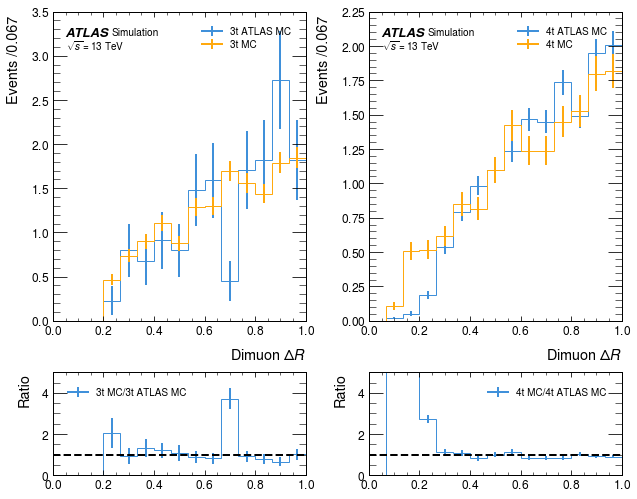

In [55]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_lepton_3t_1.deltaR(highest_pt_lepton_3t_1),lowest_pt_lepton_3t_2.deltaR(highest_pt_lepton_3t_2)], 15, ['3t ATLAS MC','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,1))
histogram([lowest_pt_lepton_4t_1.deltaR(highest_pt_lepton_4t_1),lowest_pt_lepton_4t_2.deltaR(highest_pt_lepton_4t_2)], 15, ['4t ATLAS MC','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,1))
ax[0,0].set_xlabel(r'Dimuon $\Delta R$')
ax[0,1].set_xlabel(r'Dimuon $\Delta R$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

In [ ]:
np.min(lowest_pt_lepton_4t_1.deltaR(highest_pt_lepton_4t_1))

0.09967877

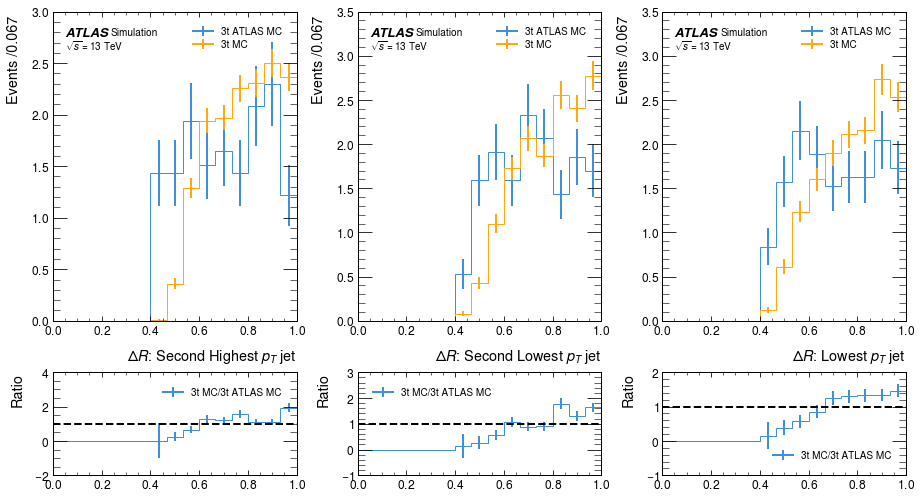

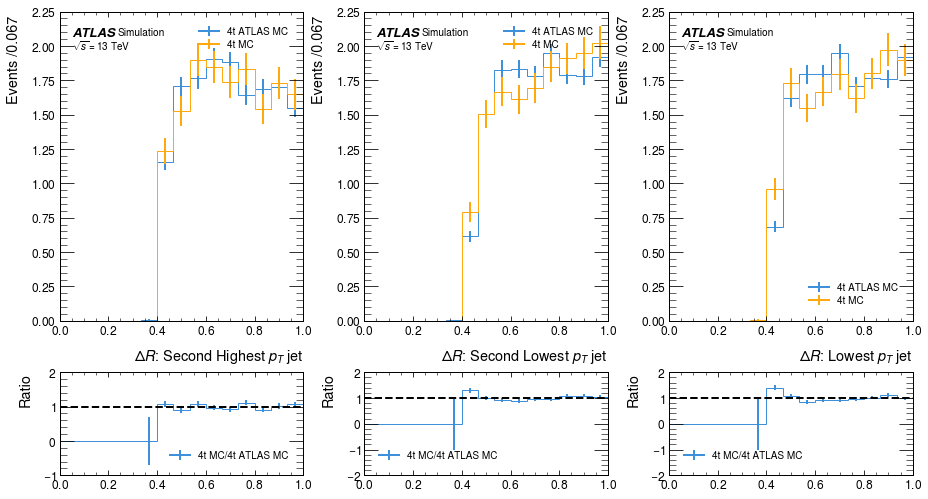

In [ ]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([highest_pt_jet_3t_1.deltaR(second_highest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaR(second_highest_pt_jet_3t_2)], 15, ['3t ATLAS MC','3t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,1))
histogram([highest_pt_jet_3t_1.deltaR(second_lowest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaR(second_lowest_pt_jet_3t_2)], 15, ['3t ATLAS MC','3t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,1))
histogram([highest_pt_jet_3t_1.deltaR(lowest_pt_jet_3t_1),highest_pt_lepton_3t_2.deltaR(lowest_pt_jet_3t_2)], 15, ['3t ATLAS MC','3t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='', set_range=(0,1))
ax[0,0].set_xlabel(r'$\Delta R$: Second Highest $p_T$ jet')
ax[0,1].set_xlabel(r'$\Delta R$: Second Lowest $p_T$ jet')
ax[0,2].set_xlabel(r'$\Delta R$: Lowest $p_T$ jet')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([highest_pt_jet_4t_1.deltaR(second_highest_pt_jet_4t_1),highest_pt_jet_4t_2.deltaR(second_highest_pt_jet_4t_2)], 15, ['4t ATLAS MC','4t MC'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='', set_range=(0,1))
histogram([highest_pt_jet_4t_1.deltaR(second_lowest_pt_jet_4t_1),highest_pt_jet_4t_2.deltaR(second_lowest_pt_jet_4t_2)], 15, ['4t ATLAS MC','4t MC'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='', set_range=(0,1))
histogram([highest_pt_jet_4t_1.deltaR(lowest_pt_jet_4t_1),highest_pt_jet_4t_2.deltaR(lowest_pt_jet_4t_2)], 15, ['4t ATLAS MC','4t MC'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, x_units='', set_range=(0,1))
ax[0,0].set_xlabel(r'$\Delta R$: Second Highest $p_T$ jet')
ax[0,1].set_xlabel(r'$\Delta R$: Second Lowest $p_T$ jet')
ax[0,2].set_xlabel(r'$\Delta R$: Lowest $p_T$ jet')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()